In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import enum
import simpy
import scipy as sc
import math
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import time
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr

from osgeo import gdal
from scipy import interpolate
from scipy.signal import correlate
from shapely.ops import transform,split,snap
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor
from opentnsim import regulations

# spatial libraries 
import shapely.geometry
from shapely.geometry import Point
import shapely.wkt
import pyproj
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate systemb
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

In [2]:
wgs = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:28992')
wgs_to_utm = pyproj.Transformer.from_crs(wgs,utm,always_xy=True).transform
utm_to_wgs = pyproj.Transformer.from_crs(utm,wgs,always_xy=True).transform

In [3]:
starting_hour = 1000/(60*60*4)
next_hours = np.arange(0.25,12.25,0.25)
hours = np.append(np.array([starting_hour]),next_hours)

In [4]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
coords = []

for hour in reversed(hours):
    coords.append(transform(utm_to_wgs,Point(155000-hour*60*60*4,463000)))
for hour in hours:
    coords.append(transform(utm_to_wgs,Point(155000+hour*60*60*4,463000)))

for index,coord in enumerate(coords):
    data_node = {"env": [],
                 "name": "Node_" + str(index+1),
                 "geometry": coord}
    node = Node(**data_node)
    nodes.append(node)
    
for i in range(len(nodes)-1):
    path.append([nodes[i],nodes[i+1]]) 
    path.append([nodes[i+1],nodes[i]])

FG = nx.MultiDiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    geometry = shapely.geometry.LineString([FG.nodes[edge[0].name]['geometry'],FG.nodes[edge[1].name]['geometry']])
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {},geometry=geometry)
    
for node in FG.nodes:
    FG.nodes[node]['Info'] = {}

In [5]:
for node in FG.nodes:
    FG.nodes[node]['geometry'] = transform(wgs_to_utm,FG.nodes[node]['geometry'])
    
for edge in FG.edges:
    geometry = transform(wgs_to_utm,FG.edges[edge]['geometry'])
    length = int(geometry.length)
    FG.edges[edge]['geometry'] = geometry
    FG.edges[edge]['Info']['geometry'] = geometry
    FG.edges[edge]['Info']['length'] = length

In [6]:
import pytz
simulation_start = datetime.datetime(2019,1,1,0,0,0)
duration = datetime.timedelta(seconds=14*24*60*60) #seconds

In [7]:
water_level = []
salinity = []

for nodes in enumerate(FG.nodes):
    water_level.append([[],[]])
    salinity.append([[],[]])

MBL = [11]*len(FG.nodes)
depth = MBL
times = np.arange(simulation_start,simulation_start+duration,datetime.timedelta(seconds=10*60))
stations = list(FG.nodes)

sea = True
for index,node in enumerate(list(FG.nodes)):
    if sea:
        water_level[index]=[1.0*np.sin(2*np.pi*((t-np.datetime64(0,'s'))/np.timedelta64(1, 's')-simulation_start.timestamp())/45000) for t in times]
        salinity[index]=[25.0 for t in times]
        if node == 'Node_49':
            sea = False
    else:
        water_level[index]=[0.0 for t in times]
        salinity[index]=[0.0 for t in times]

In [8]:
import xarray as xr
station_data = xr.DataArray(data=stations,
                         dims=["STATIONS"])

time_data = xr.DataArray(data=times,
                         dims=["TIME"])

MBL_data = xr.DataArray(data=MBL,
                        dims=["STATIONS"])

depth_data = xr.DataArray(data=depth,
                          dims=["STATIONS"])

water_level_data = xr.DataArray(data=[wlev for wlev in water_level],
                                dims=["STATIONS","TIME"])

salinity_data = xr.DataArray(data=[sal for sal in salinity],
                             dims=["STATIONS","TIME"])

hydrodynamic_data = xr.Dataset({'TIME':times,
                                'Stations':station_data,
                                'MBL':MBL_data,
                                'Depth':depth_data,
                                'Water level': water_level_data,
                                'Salinity':salinity_data})

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_21180\3095883058.py:5: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_21180\3095883058.py:20: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by con

In [9]:
sim = model.Simulation(graph=FG,simulation_start=simulation_start,simulation_duration=duration,hydrodynamic_data=hydrodynamic_data)
env = sim.environment

In [10]:
sim.environment.vessel_traffic_service

In [11]:
lock_1 = lock.IsLock(env = sim.environment, 
                     name = 'Lock',
                     distance_doors1_from_first_waiting_area=750,   
                     distance_doors2_from_second_waiting_area=FG.edges['Node_49','Node_50',0]['Info']['length']-1250,
                     node_doors1 = 'Node_49', node_doors2 = 'Node_50',time_step=60,
                     lock_length = 500, lock_width = 40, lock_depth = 10.5, 
                     doors_open = 600, doors_close = 600, disch_coeff = 0.8,
                     opening_area = 4.0, opening_depth = 5.0,node_open='Node_50',
                     detector_nodes=['Node_33','Node_66'], priority_rules = regulations.ConditionalRule('start_node','==','Node_50'))

lineup_area_1 = lock.IsLockLineUpArea(env = sim.environment, name = 'Lock', distance_to_lock_doors = 100,
                                      start_node = 'Node_49',end_node = 'Node_50', lineup_length = 500)

lineup_area_2 = lock.IsLockLineUpArea(env = sim.environment, name = "Lock", distance_to_lock_doors = 100,
                                      start_node = 'Node_50',end_node = 'Node_49', lineup_length = 500)

waiting_area_1 = lock.IsLockWaitingArea(env = sim.environment, name = 'Lock', distance_from_node=0,
                                        node = 'Node_49')
    
waiting_area_2 = lock.IsLockWaitingArea(env = sim.environment, name = "Lock", distance_from_node=0,
                                        node = 'Node_50')

c:\users\floorbakker\opentnsim\opentnsim\lock.py:342: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



In [12]:
lock_1.detector_nodes[0]

'Node_33'

In [13]:
Vessel = type('Vessel', 
              (core.SimpyObject, core.Identifiable, lock.HasWaitingArea, lock.HasLock, lock.HasLineUpArea, core.Movable, vessel.VesselProperties, output.HasOutput, vessel.ExtraMetadata), {})

In [14]:
def create_vessel(name,FG,origin,destination,length,beam,draught,height,v,arrival_time):
    vessel_input = { "name":name,
                     "geometry":FG.nodes[origin]['geometry'],
                     "origin":origin,
                     "destination":destination,
                     #"next_destination":next_destination,
                     "route":nx.dijkstra_path(FG,origin,destination),
                     "env":env,
                     "type":'Tanker',
                     "B":beam,
                     "L":length,
                     "T": draught,
                     "H":height,
                     #"t_berthing":berthing_time.total_seconds(),
                     #"t_(un)loading":[time.total_seconds() for time in unloading_time],
                     #"t_turning":[time.total_seconds() for time in turning_time],
                     #"ukc":ukc,
                     "v":v,
                     #"terminal_of_call": terminal_of_call,
                     #"berth_of_call": berth_of_call,
                     #"(un)loading": delta_draught,
                     #"max_waiting_time":datetime.timedelta(days=10).total_seconds(),
                     #"max_cross_current":max_cross_current,
                     "arrival_time":arrival_time,
                     #"arrival_delay":arrival_time,
                     #"priority": 0,
                     #"additional_waiting_time": additional_waiting_time/np.timedelta64(1, 's'),
                     #"bound":bound,
                     #"priority":False
                   }
    return vessel_input

In [15]:
random.seed(0)
month_reached = False
arrival_time = sim.environment.simulation_start
vessel_index = 0
while not month_reached:
    arrival_time += pd.Timedelta(random.uniform(0,4),'h')
    created_vessel = Vessel(**create_vessel(name = f'inbound_vessel_{vessel_index}',
                                            FG = FG,
                                            origin='Node_1',
                                            destination='Node_98',
                                            length=200,
                                            beam=35,
                                            draught=10,
                                            height=5,
                                            v=4,
                                            arrival_time=arrival_time))
    sim.add_vessels(vessel=created_vessel)
    vessel_index += 1
    if arrival_time > sim.environment.simulation_start + datetime.timedelta(days=14):
        month_reached = True

month_reached = False
arrival_time = sim.environment.simulation_start
vessel_index = 0
while not month_reached:
    arrival_time += pd.Timedelta(random.uniform(0,4),'h')
    created_vessel = Vessel(**create_vessel(name = f'outbound_vessel_{vessel_index}',
                                            FG = FG,
                                            origin='Node_98',
                                            destination='Node_1',
                                            length=200,
                                            beam=35,
                                            draught=10,
                                            height=5,
                                            v=4,
                                            arrival_time=arrival_time))
    sim.add_vessels(vessel=created_vessel)
    vessel_index += 1
    if arrival_time > sim.environment.simulation_start + datetime.timedelta(days=14):
        month_reached = True
    

In [16]:
waiting_area_1.resource.users

[]

In [17]:
t1 = timepy.time()
sim.run()
t2 = timepy.time()
print(t2-t1)

hi outbound_vessel_0 2019-01-01 09:01:33.438305
hi inbound_vessel_0 2019-01-01 11:22:39.674661
haiii outbound_vessel_0
haiii outbound_vessel_0
outbound_vessel_0 start waiting time 2019-01-01 13:00:14.271638
claim the lock doors outbound_vessel_0 2019-01-01 13:00:14.271638
formal request 1
lock is empty and not converting hihi haha ho ho ho outbound_vessel_0 2019-01-01 13:00:14.271638 0 2
outbound_vessel_0 0
lock doors claimed outbound_vessel_0 2019-01-01 13:00:14.271638
outbound_vessel_0 sail to assigned lock position
left doors1 outbound_vessel_0 2019-01-01 13:11:20.938305 0 [] ['outbound_vessel_0']
print doors outbound_vessel_0 ['outbound_vessel_0'] []
outbound_vessel_0 in lock ['outbound_vessel_0', 'outbound_vessel_1']
hii outbound_vessel_0 2019-01-01 13:11:20.938305
haiii outbound_vessel_1
haiii outbound_vessel_1
outbound_vessel_1 start waiting time 2019-01-01 15:05:14.735247
claim the lock doors outbound_vessel_1 2019-01-01 15:05:14.735247
lock not empty outbound_vessel_1 2019-01-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_1 hap is geconvert 2019-01-01 16:09:39.179692
100
0
waiting for others done outbound_vessel_0
yo yo yo outbound_vessel_0 2019-01-01 16:09:39.179692
left lock outbound_vessel_0 2019-01-01 16:09:39.179692
left lock outbound_vessel_1 2019-01-01 16:14:00.290803
400 give back
500 back
left doors2 outbound_vessel_1 2019-01-01 16:22:03.624136 0 [] []
doors requested inbound_vessel_0 2019-01-01 16:22:03.624136
claiming lock: priority doors2 not -1 inbound_vessel_0 2019-01-01 16:22:03.624136
inbound_vessel_0 sail to assigned lock position
left doors1 inbound_vessel_0 2019-01-01 16:33:10.290803 [] 1 ['inbound_vessel_0']
print doors inbound_vessel_0 [] ['inbound_vessel_0']
inbound_vessel_0 in lock ['inbound_vessel_0', 'inbound_vessel_1', 'inbound_vessel_2']
hii inbound_vessel_0 2019-01-01 16:33:10.290803
haiii outbound_vessel_2
haiii outbound_vessel_2
outbound_vessel_2 start waiting time 2019-01-01 17:40:01.880886
claim the lock doors outbound_vessel_2 2019-01-01 17:40:01.880886
a

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_1 hap is geconvert 2019-01-01 19:51:24.464899
100
0
waiting for others done inbound_vessel_0
yo yo yo inbound_vessel_0 2019-01-01 19:51:24.464899
left lock inbound_vessel_0 2019-01-01 19:51:24.464899
left lock inbound_vessel_1 2019-01-01 19:55:45.576010
haiii inbound_vessel_2
haiii inbound_vessel_2
inbound_vessel_2 start waiting time 2019-01-01 19:57:08.421658
400 give back
500 back
claim the lock doors inbound_vessel_2 2019-01-01 20:01:18.909343
approach node != node open
requesting approach: else inbound_vessel_2 2019-01-01 20:01:18.909343 0 [] ['inbound_vessel_1']
left doors2 inbound_vessel_1 2019-01-01 20:03:48.909343 1 [] []
doors requested outbound_vessel_2 2019-01-01 20:03:48.909343
claiming lock: priority doors2 not -1 outbound_vessel_2 2019-01-01 20:03:48.909343
outbound_vessel_2 sail to assigned lock position
left doors1 outbound_vessel_2 2019-01-01 20:14:55.576010 0 ['inbound_vessel_2'] ['outbound_vessel_2']
print doors outbound_vessel_2 ['outbound_vessel_2'] 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_3
haiii inbound_vessel_3
inbound_vessel_3 start waiting time 2019-01-01 21:52:39.113822
claim the lock doors inbound_vessel_3 2019-01-01 21:52:39.113822
lock not empty inbound_vessel_3 2019-01-01 21:52:39.113822 ['outbound_vessel_2', 'outbound_vessel_3']
lock is not empty (may be converting) inbound_vessel_3 2019-01-01 21:52:39.113822 True
outbound_vessel_3 hap is geconvert 2019-01-01 22:14:41.164565
100
0
waiting for others done outbound_vessel_2
yo yo yo outbound_vessel_2 2019-01-01 22:14:41.164565
left lock outbound_vessel_2 2019-01-01 22:14:41.164565
left lock outbound_vessel_3 2019-01-01 22:19:02.275676
400 give back
500 back
left doors2 outbound_vessel_3 2019-01-01 22:27:05.609009 0 [] []
doors requested inbound_vessel_2 2019-01-01 22:27:05.609009
claiming lock: priority doors2 not -1 inbound_vessel_2 2019-01-01 22:27:05.609009
inbound_vessel_2 sail to assigned lock position
left doors1 inbound_vessel_2 2019-01-01 22:38:12.275676 ['inbound_vessel_3'] 1 ['inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_3 hap is geconvert 2019-01-01 23:33:18.942343
100
0
waiting for others done inbound_vessel_2
yo yo yo inbound_vessel_2 2019-01-01 23:33:18.942343
left lock inbound_vessel_2 2019-01-01 23:33:18.942343
left doors2 inbound_vessel_2 2019-01-01 23:37:40.053454 1 [] []
left lock inbound_vessel_3 2019-01-01 23:37:40.053454
400 give back
500 back
left doors2 inbound_vessel_3 2019-01-01 23:45:43.386787 1 [] []
haiii outbound_vessel_4
haiii outbound_vessel_4
outbound_vessel_4 start waiting time 2019-01-02 00:33:34.572497
claim the lock doors outbound_vessel_4 2019-01-02 00:33:34.572497
formal request 3
lock is empty and not converting hihi haha outbound_vessel_4 2019-01-02 00:33:34.572497 0 3
lock doors claimed outbound_vessel_4 2019-01-02 00:33:34.572497
outbound_vessel_4 sail to assigned lock position
haiii outbound_vessel_5
haiii outbound_vessel_5
outbound_vessel_5 start waiting time 2019-01-02 00:43:20.123637
claim the lock doors outbound_vessel_5 2019-01-02 00:43:20.123637
fo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_5 hap is geconvert 2019-01-02 01:36:05.683609
100
0
waiting for others done outbound_vessel_4
yo yo yo outbound_vessel_4 2019-01-02 01:36:05.683609
left lock outbound_vessel_4 2019-01-02 01:36:05.683609
left lock outbound_vessel_5 2019-01-02 01:40:26.794720
haiii outbound_vessel_6
haiii outbound_vessel_6
outbound_vessel_6 start waiting time 2019-01-02 01:45:39.362745
400 give back
500 back
claim the lock doors outbound_vessel_6 2019-01-02 01:46:00.128053
approach node != node open
requesting approach: else outbound_vessel_6 2019-01-02 01:46:00.128053 0 [] ['outbound_vessel_5']
left doors2 outbound_vessel_5 2019-01-02 01:48:30.128053 0 [] []
doors requested inbound_vessel_4 2019-01-02 01:48:30.128053
claiming lock: priority doors2 not -1 inbound_vessel_4 2019-01-02 01:48:30.128053
inbound_vessel_4 sail to assigned lock position
left doors1 inbound_vessel_4 2019-01-02 01:59:36.794720 ['outbound_vessel_6'] 1 ['inbound_vessel_4']
print doors inbound_vessel_4 ['outbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_7
haiii outbound_vessel_7
outbound_vessel_7 start waiting time 2019-01-02 05:31:42.332859
claim the lock doors outbound_vessel_7 2019-01-02 05:31:42.332859
lock not empty outbound_vessel_7 2019-01-02 05:31:42.332859 ['inbound_vessel_4', 'inbound_vessel_5']
lock is not empty (may be converting) outbound_vessel_7 2019-01-02 05:31:42.332859 True
inbound_vessel_5 hap is geconvert 2019-01-02 05:46:33.244541
100
0
waiting for others done inbound_vessel_4
yo yo yo inbound_vessel_4 2019-01-02 05:46:33.244541
left lock inbound_vessel_4 2019-01-02 05:46:33.244541
left lock inbound_vessel_5 2019-01-02 05:50:54.355652
400 give back
500 back
left doors2 inbound_vessel_5 2019-01-02 05:58:57.688985 1 [] []
doors requested outbound_vessel_6 2019-01-02 05:58:57.688985
claiming lock: priority doors2 not -1 outbound_vessel_6 2019-01-02 05:58:57.688985
outbound_vessel_6 sail to assigned lock position
left doors1 outbound_vessel_6 2019-01-02 06:10:04.355652 0 ['outbound_vessel_7'] ['o

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_7 hap is geconvert 2019-01-02 06:48:11.022319
100
0
waiting for others done outbound_vessel_6
yo yo yo outbound_vessel_6 2019-01-02 06:48:11.022319
left lock outbound_vessel_6 2019-01-02 06:48:11.022319
left doors2 outbound_vessel_6 2019-01-02 06:52:32.133430 0 [] []
left lock outbound_vessel_7 2019-01-02 06:52:32.133430
400 give back
500 back
left doors2 outbound_vessel_7 2019-01-02 07:00:35.466763 0 [] []
haiii inbound_vessel_6
haiii inbound_vessel_6
inbound_vessel_6 start waiting time 2019-01-02 07:14:09.501464
claim the lock doors inbound_vessel_6 2019-01-02 07:14:09.501464
formal request 3
lock is empty and not converting hihi haha inbound_vessel_6 2019-01-02 07:14:09.501464 0 5
lock doors claimed inbound_vessel_6 2019-01-02 07:14:09.501464
inbound_vessel_6 sail to assigned lock position
left doors1 inbound_vessel_6 2019-01-02 07:25:16.168131 [] 1 ['inbound_vessel_6']
print doors inbound_vessel_6 [] ['inbound_vessel_6']
inbound_vessel_6 in lock ['inbound_vessel_6',

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_7 hap is geconvert 2019-01-02 09:09:59.521176
100
0
waiting for others done inbound_vessel_6
yo yo yo inbound_vessel_6 2019-01-02 09:09:59.521176
left lock inbound_vessel_6 2019-01-02 09:09:59.521176
haiii inbound_vessel_8
haiii inbound_vessel_8
inbound_vessel_8 start waiting time 2019-01-02 09:14:13.541690
left lock inbound_vessel_7 2019-01-02 09:14:20.632287
400 give back
500 back
claim the lock doors inbound_vessel_8 2019-01-02 09:19:53.965620
approach node != node open
requesting approach: else inbound_vessel_8 2019-01-02 09:19:53.965620 0 [] ['inbound_vessel_7']
left doors2 inbound_vessel_7 2019-01-02 09:22:23.965620 1 [] []
doors requested outbound_vessel_8 2019-01-02 09:22:23.965620
claiming lock: priority doors2 not -1 outbound_vessel_8 2019-01-02 09:22:23.965620
outbound_vessel_8 sail to assigned lock position
left doors1 outbound_vessel_8 2019-01-02 09:33:30.632287 0 ['outbound_vessel_9'] ['outbound_vessel_8']
print doors outbound_vessel_8 ['outbound_vessel_8']

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_9 hap is geconvert 2019-01-02 10:42:37.298954
100
0
waiting for others done outbound_vessel_8
yo yo yo outbound_vessel_8 2019-01-02 10:42:37.298954
left lock outbound_vessel_8 2019-01-02 10:42:37.298954
left lock outbound_vessel_9 2019-01-02 10:46:58.410065
400 give back
500 back
left doors2 outbound_vessel_9 2019-01-02 10:55:01.743398 0 [] []
doors requested inbound_vessel_8 2019-01-02 10:55:01.743398
claiming lock: priority doors2 not -1 inbound_vessel_8 2019-01-02 10:55:01.743398
inbound_vessel_8 sail to assigned lock position
left doors1 inbound_vessel_8 2019-01-02 11:06:08.410065 ['inbound_vessel_9'] 1 ['inbound_vessel_8']
print doors inbound_vessel_8 ['inbound_vessel_9'] ['inbound_vessel_8']
inbound_vessel_8 in lock ['inbound_vessel_8', 'inbound_vessel_9', 'inbound_vessel_10', 'inbound_vessel_11']
hii inbound_vessel_8 2019-01-02 11:06:08.410065
doors requested inbound_vessel_9 2019-01-02 11:06:08.410065
claiming lock: priority doors2 is -1 inbound_vessel_9 2019-01

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_10
haiii outbound_vessel_10
outbound_vessel_10 start waiting time 2019-01-02 11:49:46.722907
claim the lock doors outbound_vessel_10 2019-01-02 11:49:46.722907
lock not empty outbound_vessel_10 2019-01-02 11:49:46.722907 ['inbound_vessel_8', 'inbound_vessel_9']
lock is not empty (may be converting) outbound_vessel_10 2019-01-02 11:49:46.722907 True
inbound_vessel_9 hap is geconvert 2019-01-02 12:01:15.076732
100
0
waiting for others done inbound_vessel_8
yo yo yo inbound_vessel_8 2019-01-02 12:01:15.076732
left lock inbound_vessel_8 2019-01-02 12:01:15.076732
left lock inbound_vessel_9 2019-01-02 12:05:36.187843
400 give back
500 back
claim the lock doors inbound_vessel_10 2019-01-02 12:11:09.521176
approach node != node open
requesting approach: else inbound_vessel_10 2019-01-02 12:11:09.521176 0 [] ['inbound_vessel_9']
left doors2 inbound_vessel_9 2019-01-02 12:13:39.521176 1 [] []
requested first set of doors outbound_vessel_10 2019-01-02 12:13:39.521176
lock d

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_11 hap is geconvert 2019-01-02 15:30:28.378203
100
0
waiting for others done outbound_vessel_10
yo yo yo outbound_vessel_10 2019-01-02 15:30:28.378203
left lock outbound_vessel_10 2019-01-02 15:30:28.378203
left lock outbound_vessel_11 2019-01-02 15:34:49.489314
400 give back
500 back
left doors2 outbound_vessel_11 2019-01-02 15:42:52.822647 0 [] []
doors requested inbound_vessel_10 2019-01-02 15:42:52.822647
claiming lock: priority doors2 not -1 inbound_vessel_10 2019-01-02 15:42:52.822647
inbound_vessel_10 sail to assigned lock position
left doors1 inbound_vessel_10 2019-01-02 15:53:59.489314 ['inbound_vessel_11'] 1 ['inbound_vessel_10']
print doors inbound_vessel_10 ['inbound_vessel_11'] ['inbound_vessel_10']
inbound_vessel_10 in lock ['inbound_vessel_10', 'inbound_vessel_11', 'inbound_vessel_12', 'inbound_vessel_13', 'inbound_vessel_14']
hii inbound_vessel_10 2019-01-02 15:53:59.489314
doors requested inbound_vessel_11 2019-01-02 15:53:59.489314
claiming lock: prior

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_13
haiii inbound_vessel_13
inbound_vessel_13 start waiting time 2019-01-02 16:33:32.018031
haiii outbound_vessel_12
haiii outbound_vessel_12
outbound_vessel_12 start waiting time 2019-01-02 17:01:39.599495
claim the lock doors outbound_vessel_12 2019-01-02 17:01:39.599495
lock not empty outbound_vessel_12 2019-01-02 17:01:39.599495 ['inbound_vessel_10', 'inbound_vessel_11']
lock is not empty (may be converting) outbound_vessel_12 2019-01-02 17:01:39.599495 True
inbound_vessel_11 hap is geconvert 2019-01-02 17:02:06.155981
100
0
waiting for others done inbound_vessel_10
yo yo yo inbound_vessel_10 2019-01-02 17:02:06.155981
left lock inbound_vessel_10 2019-01-02 17:02:06.155981
left lock inbound_vessel_11 2019-01-02 17:06:27.267092
400 give back
500 back
claim the lock doors inbound_vessel_12 2019-01-02 17:12:00.600425
approach node != node open
requesting approach: else inbound_vessel_12 2019-01-02 17:12:00.600425 0 [] ['inbound_vessel_11']
claim the lock doors inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_13 hap is geconvert 2019-01-02 20:27:42.077217
100
0
waiting for others done outbound_vessel_12
yo yo yo outbound_vessel_12 2019-01-02 20:27:42.077217
left lock outbound_vessel_12 2019-01-02 20:27:42.077217
left lock outbound_vessel_13 2019-01-02 20:32:03.188328
400 give back
500 back
left doors2 outbound_vessel_13 2019-01-02 20:40:06.521661 0 [] []
doors requested inbound_vessel_12 2019-01-02 20:40:06.521661
claiming lock: priority doors2 not -1 inbound_vessel_12 2019-01-02 20:40:06.521661
inbound_vessel_12 sail to assigned lock position
left doors1 inbound_vessel_12 2019-01-02 20:51:13.188328 ['inbound_vessel_13'] 1 ['inbound_vessel_12']
print doors inbound_vessel_12 ['inbound_vessel_13'] ['inbound_vessel_12']
inbound_vessel_12 in lock ['inbound_vessel_12', 'inbound_vessel_13', 'inbound_vessel_14', 'inbound_vessel_15', 'inbound_vessel_16']
hii inbound_vessel_12 2019-01-02 20:51:13.188328
doors requested inbound_vessel_13 2019-01-02 20:51:13.188328
claiming lock: prior

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_13 hap is geconvert 2019-01-02 21:59:19.854995
100
0
waiting for others done inbound_vessel_12
yo yo yo inbound_vessel_12 2019-01-02 21:59:19.854995
left lock inbound_vessel_12 2019-01-02 21:59:19.854995
left lock inbound_vessel_13 2019-01-02 22:03:40.966106
400 give back
500 back
claim the lock doors inbound_vessel_14 2019-01-02 22:09:14.299439
approach node != node open
else: claiming lock: priority doors2 = -1 inbound_vessel_14 2019-01-02 22:09:14.299439 -1
requested first set of doors inbound_vessel_14 2019-01-02 22:09:14.299439
lock doors claimed inbound_vessel_14 2019-01-02 22:09:14.299439
empty conversion requested inbound_vessel_14 2019-01-02 22:09:14.299439
hi 2019-01-02 22:09:14.299439
2019-01-02 22:09:14.299439 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_15
haiii inbound_vessel_15
inbound_vessel_15 start waiting time 2019-01-02 22:52:48.418303
claim the lock doors inbound_vessel_15 2019-01-02 22:52:48.418303
formal request 1
haiii outbound_vessel_14
haiii outbound_vessel_14
outbound_vessel_14 start waiting time 2019-01-02 23:04:25.947305
claim the lock doors outbound_vessel_14 2019-01-02 23:04:25.947305
approach node != node open
requesting approach: else outbound_vessel_14 2019-01-02 23:04:25.947305 0 ['inbound_vessel_14'] ['inbound_vessel_14']
empty conversion done inbound_vessel_14 2019-01-02 23:07:14.299439
inbound_vessel_14 sail to assigned lock position
left doors1 inbound_vessel_14 2019-01-02 23:18:20.966106 ['inbound_vessel_15'] 1 ['inbound_vessel_14']
print doors inbound_vessel_14 ['inbound_vessel_15'] ['inbound_vessel_14']
inbound_vessel_14 in lock ['inbound_vessel_14', 'inbound_vessel_15', 'inbound_vessel_16', 'inbound_vessel_17']
hii inbound_vessel_14 2019-01-02 23:18:20.966106
lock is empty and not con

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_15
haiii outbound_vessel_15
outbound_vessel_15 start waiting time 2019-01-02 23:53:12.235732
claim the lock doors outbound_vessel_15 2019-01-02 23:53:12.235732
lock not empty outbound_vessel_15 2019-01-02 23:53:12.235732 ['inbound_vessel_14', 'inbound_vessel_15']
lock is not empty (may be converting) outbound_vessel_15 2019-01-02 23:53:12.235732 True
inbound_vessel_15 hap is geconvert 2019-01-03 00:17:27.632773
100
0
waiting for others done inbound_vessel_14
yo yo yo inbound_vessel_14 2019-01-03 00:17:27.632773
left lock inbound_vessel_14 2019-01-03 00:17:27.632773
left lock inbound_vessel_15 2019-01-03 00:21:48.743884
400 give back
500 back
left doors2 inbound_vessel_15 2019-01-03 00:29:52.077217 1 [] []
doors requested outbound_vessel_14 2019-01-03 00:29:52.077217
claiming lock: priority doors2 not -1 outbound_vessel_14 2019-01-03 00:29:52.077217
outbound_vessel_14 sail to assigned lock position
left doors1 outbound_vessel_14 2019-01-03 00:40:58.743884 0 ['outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_17 hap is geconvert 2019-01-03 03:09:32.979661
100
0
waiting for others done inbound_vessel_16
yo yo yo inbound_vessel_16 2019-01-03 03:09:32.979661
left lock inbound_vessel_16 2019-01-03 03:09:32.979661
left lock inbound_vessel_17 2019-01-03 03:13:54.090772
400 give back
500 back
left doors2 inbound_vessel_17 2019-01-03 03:21:57.424105 1 [] []
doors requested outbound_vessel_16 2019-01-03 03:21:57.424105
claiming lock: priority doors2 not -1 outbound_vessel_16 2019-01-03 03:21:57.424105
outbound_vessel_16 sail to assigned lock position
left doors1 outbound_vessel_16 2019-01-03 03:33:04.090772 0 ['outbound_vessel_17'] ['outbound_vessel_16']
print doors outbound_vessel_16 ['outbound_vessel_16'] ['outbound_vessel_17']
outbound_vessel_16 in lock ['outbound_vessel_16', 'outbound_vessel_17', 'outbound_vessel_18', 'outbound_vessel_19']
hii outbound_vessel_16 2019-01-03 03:33:04.090772
doors requested outbound_vessel_17 2019-01-03 03:33:04.090772
claiming lock: priority doors2 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_18
haiii inbound_vessel_18
inbound_vessel_18 start waiting time 2019-01-03 04:38:45.307633
claim the lock doors inbound_vessel_18 2019-01-03 04:38:45.307633
lock not empty inbound_vessel_18 2019-01-03 04:38:45.307633 ['outbound_vessel_16', 'outbound_vessel_17']
lock is not empty (may be converting) inbound_vessel_18 2019-01-03 04:38:45.307633 True
outbound_vessel_17 hap is geconvert 2019-01-03 04:43:10.757439
100
0
waiting for others done outbound_vessel_16
yo yo yo outbound_vessel_16 2019-01-03 04:43:10.757439
left lock outbound_vessel_16 2019-01-03 04:43:10.757439
left lock outbound_vessel_17 2019-01-03 04:47:31.868550
400 give back
500 back
claim the lock doors outbound_vessel_18 2019-01-03 04:53:05.201883
approach node != node open
requesting approach: else outbound_vessel_18 2019-01-03 04:53:05.201883 0 [] ['outbound_vessel_17']
left doors2 outbound_vessel_17 2019-01-03 04:55:35.201883 0 [] []
requested first set of doors inbound_vessel_18 2019-01-03 04:55:35.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_19
haiii outbound_vessel_19
outbound_vessel_19 start waiting time 2019-01-03 05:52:44.431539
claim the lock doors outbound_vessel_19 2019-01-03 05:52:44.431539
lock not empty outbound_vessel_19 2019-01-03 05:52:44.431539 ['inbound_vessel_18', 'inbound_vessel_19']
lock is not empty (may be converting) outbound_vessel_19 2019-01-03 05:52:44.431539 True
inbound_vessel_19 hap is geconvert 2019-01-03 06:24:14.231671
100
0
waiting for others done inbound_vessel_18
yo yo yo inbound_vessel_18 2019-01-03 06:24:14.231671
left lock inbound_vessel_18 2019-01-03 06:24:14.231671
left lock inbound_vessel_19 2019-01-03 06:28:35.342782
400 give back
500 back
left doors2 inbound_vessel_19 2019-01-03 06:36:38.676115 1 [] []
doors requested outbound_vessel_18 2019-01-03 06:36:38.676115
claiming lock: priority doors2 not -1 outbound_vessel_18 2019-01-03 06:36:38.676115
outbound_vessel_18 sail to assigned lock position
left doors1 outbound_vessel_18 2019-01-03 06:47:45.342782 0 ['outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_19 hap is geconvert 2019-01-03 07:19:52.009449
100
0
waiting for others done outbound_vessel_18
yo yo yo outbound_vessel_18 2019-01-03 07:19:52.009449
left lock outbound_vessel_18 2019-01-03 07:19:52.009449
haiii inbound_vessel_20
haiii inbound_vessel_20
inbound_vessel_20 start waiting time 2019-01-03 07:22:18.728008
claim the lock doors inbound_vessel_20 2019-01-03 07:22:18.728008
lock not empty inbound_vessel_20 2019-01-03 07:22:18.728008 ['outbound_vessel_19']
lock is not empty (may be converting) inbound_vessel_20 2019-01-03 07:22:18.728008 True
left doors2 outbound_vessel_18 2019-01-03 07:24:13.120560 0 [] []
left lock outbound_vessel_19 2019-01-03 07:24:13.120560
400 give back
500 back
left doors2 outbound_vessel_19 2019-01-03 07:32:16.453893 0 [] []
requested first set of doors inbound_vessel_20 2019-01-03 07:32:16.453893
lock doors claimed inbound_vessel_20 2019-01-03 07:32:16.453893
inbound_vessel_20 sail to assigned lock position
left doors1 inbound_vessel_20 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_21 hap is geconvert 2019-01-03 10:31:50.664784
100
0
waiting for others done inbound_vessel_20
yo yo yo inbound_vessel_20 2019-01-03 10:31:50.664784
left lock inbound_vessel_20 2019-01-03 10:31:50.664784
left lock inbound_vessel_21 2019-01-03 10:36:11.775895
400 give back
500 back
left doors2 inbound_vessel_21 2019-01-03 10:44:15.109228 1 [] []
doors requested outbound_vessel_20 2019-01-03 10:44:15.109228
claiming lock: priority doors2 not -1 outbound_vessel_20 2019-01-03 10:44:15.109228
outbound_vessel_20 sail to assigned lock position
left doors1 outbound_vessel_20 2019-01-03 10:55:21.775895 0 ['outbound_vessel_21'] ['outbound_vessel_20']
print doors outbound_vessel_20 ['outbound_vessel_20'] ['outbound_vessel_21']
outbound_vessel_20 in lock ['outbound_vessel_20', 'outbound_vessel_21', 'outbound_vessel_22', 'outbound_vessel_23', 'outbound_vessel_24']
hii outbound_vessel_20 2019-01-03 10:55:21.775895
doors requested outbound_vessel_21 2019-01-03 10:55:21.775895
claiming 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_21 hap is geconvert 2019-01-03 12:02:28.442562
100
0
waiting for others done outbound_vessel_20
yo yo yo outbound_vessel_20 2019-01-03 12:02:28.442562
left lock outbound_vessel_20 2019-01-03 12:02:28.442562
left lock outbound_vessel_21 2019-01-03 12:06:49.553673
400 give back
500 back
claim the lock doors outbound_vessel_22 2019-01-03 12:12:22.887006
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_22 2019-01-03 12:12:22.887006 -1
claim the lock doors outbound_vessel_23 2019-01-03 12:12:22.887006
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_23 2019-01-03 12:12:22.887006 -1
requested first set of doors outbound_vessel_22 2019-01-03 12:12:22.887006
lock doors claimed outbound_vessel_22 2019-01-03 12:12:22.887006
empty conversion requested outbound_vessel_22 2019-01-03 12:12:22.887006
hi 2019-01-03 12:12:22.887006
2019-01-03 12:12:22.887006 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_22
haiii inbound_vessel_22
inbound_vessel_22 start waiting time 2019-01-03 12:40:38.621047
claim the lock doors inbound_vessel_22 2019-01-03 12:40:38.621047
approach node != node open
requesting approach: else inbound_vessel_22 2019-01-03 12:40:38.621047 0 ['outbound_vessel_22'] ['outbound_vessel_22']
empty conversion done outbound_vessel_22 2019-01-03 12:58:22.887006
outbound_vessel_22 sail to assigned lock position
left doors1 outbound_vessel_22 2019-01-03 13:09:29.553673 0 ['outbound_vessel_23'] ['outbound_vessel_22']
print doors outbound_vessel_22 ['outbound_vessel_22'] ['outbound_vessel_23']
outbound_vessel_22 in lock ['outbound_vessel_22', 'outbound_vessel_23', 'outbound_vessel_24', 'outbound_vessel_25']
hii outbound_vessel_22 2019-01-03 13:09:29.553673
requested first set of doors outbound_vessel_23 2019-01-03 13:09:29.553673
lock doors claimed outbound_vessel_23 2019-01-03 13:09:29.553673
outbound_vessel_23 sail to assigned lock position
left doors1 outboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_23 hap is geconvert 2019-01-03 17:26:53.386009
100
0
waiting for others done inbound_vessel_22
yo yo yo inbound_vessel_22 2019-01-03 17:26:53.386009
left lock inbound_vessel_22 2019-01-03 17:26:53.386009
left lock inbound_vessel_23 2019-01-03 17:31:14.497120
400 give back
500 back
left doors2 inbound_vessel_23 2019-01-03 17:39:17.830453 1 [] []
doors requested outbound_vessel_24 2019-01-03 17:39:17.830453
claiming lock: priority doors2 not -1 outbound_vessel_24 2019-01-03 17:39:17.830453
outbound_vessel_24 sail to assigned lock position
left doors1 outbound_vessel_24 2019-01-03 17:50:24.497120 0 ['outbound_vessel_25'] ['outbound_vessel_24']
print doors outbound_vessel_24 ['outbound_vessel_24'] ['outbound_vessel_25']
outbound_vessel_24 in lock ['outbound_vessel_24', 'outbound_vessel_25', 'outbound_vessel_26', 'outbound_vessel_27']
hii outbound_vessel_24 2019-01-03 17:50:24.497120
doors requested outbound_vessel_25 2019-01-03 17:50:24.497120
claiming lock: priority doors2 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_25 hap is geconvert 2019-01-03 18:52:31.163787
100
0
waiting for others done outbound_vessel_24
yo yo yo outbound_vessel_24 2019-01-03 18:52:31.163787
left lock outbound_vessel_24 2019-01-03 18:52:31.163787
left lock outbound_vessel_25 2019-01-03 18:56:52.274898
haiii outbound_vessel_26
haiii outbound_vessel_26
outbound_vessel_26 start waiting time 2019-01-03 18:59:19.396844
400 give back
500 back
claim the lock doors outbound_vessel_26 2019-01-03 19:02:25.608231
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_26 2019-01-03 19:02:25.608231 -1
requested first set of doors outbound_vessel_26 2019-01-03 19:02:25.608231
lock doors claimed outbound_vessel_26 2019-01-03 19:02:25.608231
empty conversion requested outbound_vessel_26 2019-01-03 19:02:25.608231
hi 2019-01-03 19:02:25.608231
2019-01-03 19:02:25.608231 Node_49 Node_50 Lock doors closing start
haiii outbound_vessel_27
haiii outbound_vessel_27
outbound_vessel_27 start waiting time

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_24
haiii inbound_vessel_24
inbound_vessel_24 start waiting time 2019-01-03 19:13:12.689048
claim the lock doors inbound_vessel_24 2019-01-03 19:13:12.689048
approach node != node open
requesting approach: else inbound_vessel_24 2019-01-03 19:13:12.689048 0 ['outbound_vessel_26'] ['outbound_vessel_26']
empty conversion done outbound_vessel_26 2019-01-03 19:38:25.608231
outbound_vessel_26 sail to assigned lock position
left doors1 outbound_vessel_26 2019-01-03 19:49:32.274898 0 ['outbound_vessel_27'] ['outbound_vessel_26']
print doors outbound_vessel_26 ['outbound_vessel_26'] ['outbound_vessel_27']
outbound_vessel_26 in lock ['outbound_vessel_26', 'outbound_vessel_27', 'outbound_vessel_28', 'outbound_vessel_29']
hii outbound_vessel_26 2019-01-03 19:49:32.274898
requested first set of doors outbound_vessel_27 2019-01-03 19:49:32.274898
lock doors claimed outbound_vessel_27 2019-01-03 19:49:32.274898
outbound_vessel_27 sail to assigned lock position
left doors1 outboun

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_27 hap is geconvert 2019-01-03 20:32:38.941565
100
0
waiting for others done outbound_vessel_26
yo yo yo outbound_vessel_26 2019-01-03 20:32:38.941565
left lock outbound_vessel_26 2019-01-03 20:32:38.941565
left lock outbound_vessel_27 2019-01-03 20:37:00.052676
400 give back
500 back
left doors2 outbound_vessel_27 2019-01-03 20:45:03.386009 0 [] []
doors requested inbound_vessel_24 2019-01-03 20:45:03.386009
claiming lock: priority doors2 not -1 inbound_vessel_24 2019-01-03 20:45:03.386009
inbound_vessel_24 sail to assigned lock position
left doors1 inbound_vessel_24 2019-01-03 20:56:10.052676 [] 1 ['inbound_vessel_24']
print doors inbound_vessel_24 [] ['inbound_vessel_24']
inbound_vessel_24 in lock ['inbound_vessel_24', 'inbound_vessel_25', 'inbound_vessel_26']
hii inbound_vessel_24 2019-01-03 20:56:10.052676
haiii inbound_vessel_25
haiii inbound_vessel_25
inbound_vessel_25 start waiting time 2019-01-03 22:03:40.338348
claim the lock doors inbound_vessel_25 2019-01-03

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_28
haiii outbound_vessel_28
outbound_vessel_28 start waiting time 2019-01-03 22:36:35.615205
claim the lock doors outbound_vessel_28 2019-01-03 22:36:35.615205
lock not empty outbound_vessel_28 2019-01-03 22:36:35.615205 ['inbound_vessel_24', 'inbound_vessel_25']
lock is not empty (may be converting) outbound_vessel_28 2019-01-03 22:36:35.615205 True
haiii outbound_vessel_29
haiii outbound_vessel_29
outbound_vessel_29 start waiting time 2019-01-03 22:52:29.374069
claim the lock doors outbound_vessel_29 2019-01-03 22:52:29.374069
lock not empty outbound_vessel_29 2019-01-03 22:52:29.374069 ['inbound_vessel_24', 'inbound_vessel_25']
lock is not empty (may be converting) outbound_vessel_29 2019-01-03 22:52:29.374069 True
inbound_vessel_25 hap is geconvert 2019-01-03 23:09:04.782793
100
0
waiting for others done inbound_vessel_24
yo yo yo inbound_vessel_24 2019-01-03 23:09:04.782793
left lock inbound_vessel_24 2019-01-03 23:09:04.782793
left lock inbound_vessel_25 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_29 hap is geconvert 2019-01-04 00:39:42.560571
100
0
waiting for others done outbound_vessel_28
yo yo yo outbound_vessel_28 2019-01-04 00:39:42.560571
left lock outbound_vessel_28 2019-01-04 00:39:42.560571
haiii inbound_vessel_26
haiii inbound_vessel_26
inbound_vessel_26 start waiting time 2019-01-04 00:44:01.744445
claim the lock doors inbound_vessel_26 2019-01-04 00:44:01.744445
lock not empty inbound_vessel_26 2019-01-04 00:44:01.744445 ['outbound_vessel_29']
lock is not empty (may be converting) inbound_vessel_26 2019-01-04 00:44:01.744445 True
left doors2 outbound_vessel_28 2019-01-04 00:44:03.671682 0 [] []
left lock outbound_vessel_29 2019-01-04 00:44:03.671682
400 give back
500 back
left doors2 outbound_vessel_29 2019-01-04 00:52:07.005015 0 [] []
requested first set of doors inbound_vessel_26 2019-01-04 00:52:07.005015
lock doors claimed inbound_vessel_26 2019-01-04 00:52:07.005015
inbound_vessel_26 sail to assigned lock position
left doors1 inbound_vessel_26 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_31
haiii outbound_vessel_31
outbound_vessel_31 start waiting time 2019-01-04 03:52:33.425431
claim the lock doors outbound_vessel_31 2019-01-04 03:52:33.425431
lock not empty outbound_vessel_31 2019-01-04 03:52:33.425431 ['inbound_vessel_26', 'inbound_vessel_27']
lock is not empty (may be converting) outbound_vessel_31 2019-01-04 03:52:33.425431 True
inbound_vessel_27 hap is geconvert 2019-01-04 04:08:17.506911
100
0
waiting for others done inbound_vessel_26
yo yo yo inbound_vessel_26 2019-01-04 04:08:17.506911
left lock inbound_vessel_26 2019-01-04 04:08:17.506911
left lock inbound_vessel_27 2019-01-04 04:12:38.618022
400 give back
500 back
left doors2 inbound_vessel_27 2019-01-04 04:20:41.951355 1 [] []
doors requested outbound_vessel_30 2019-01-04 04:20:41.951355
claiming lock: priority doors2 not -1 outbound_vessel_30 2019-01-04 04:20:41.951355
outbound_vessel_30 sail to assigned lock position
left doors1 outbound_vessel_30 2019-01-04 04:31:48.618022 0 ['outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_31 hap is geconvert 2019-01-04 05:41:55.284689
100
0
waiting for others done outbound_vessel_30
yo yo yo outbound_vessel_30 2019-01-04 05:41:55.284689
left lock outbound_vessel_30 2019-01-04 05:41:55.284689
left doors2 outbound_vessel_30 2019-01-04 05:46:16.395800 0 [] []
left lock outbound_vessel_31 2019-01-04 05:46:16.395800
400 give back
500 back
left doors2 outbound_vessel_31 2019-01-04 05:54:19.729133 0 [] []
haiii outbound_vessel_32
haiii outbound_vessel_32
outbound_vessel_32 start waiting time 2019-01-04 06:08:16.043937
claim the lock doors outbound_vessel_32 2019-01-04 06:08:16.043937
approach node != node open
else: claiming lock: priority doors2 not -1 outbound_vessel_32 2019-01-04 06:08:16.043937 0
requested first set of doors outbound_vessel_32 2019-01-04 06:08:16.043937
lock doors claimed, empty conversion requested outbound_vessel_32 2019-01-04 06:08:16.043937
empty conversion requested outbound_vessel_32 2019-01-04 06:08:16.043937
hi 2019-01-04 06:08:16.0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_28
haiii inbound_vessel_28
inbound_vessel_28 start waiting time 2019-01-04 06:39:06.542433
claim the lock doors inbound_vessel_28 2019-01-04 06:39:06.542433
approach node != node open
requesting approach: else inbound_vessel_28 2019-01-04 06:39:06.542433 0 ['outbound_vessel_32'] ['outbound_vessel_32']
empty conversion done outbound_vessel_32 2019-01-04 07:02:16.043937
outbound_vessel_32 sail to assigned lock position
left doors1 outbound_vessel_32 2019-01-04 07:13:22.710604 0 ['inbound_vessel_28'] ['outbound_vessel_32']
print doors outbound_vessel_32 ['outbound_vessel_32'] ['inbound_vessel_28']
outbound_vessel_32 in lock ['outbound_vessel_32', 'outbound_vessel_33']
hii outbound_vessel_32 2019-01-04 07:13:22.710604
doors request inbound_vessel_28 2019-01-04 07:13:22.710604
haiii outbound_vessel_33
haiii outbound_vessel_33
outbound_vessel_33 start waiting time 2019-01-04 08:02:01.710913
claim the lock doors outbound_vessel_33 2019-01-04 08:02:01.710913
lock not empty

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_33 hap is geconvert 2019-01-04 08:30:26.155358
100
0
waiting for others done outbound_vessel_32
yo yo yo outbound_vessel_32 2019-01-04 08:30:26.155358
left lock outbound_vessel_32 2019-01-04 08:30:26.155358
left lock outbound_vessel_33 2019-01-04 08:34:47.266469
400 give back
500 back
left doors2 outbound_vessel_33 2019-01-04 08:42:50.599802 0 [] []
doors requested inbound_vessel_28 2019-01-04 08:42:50.599802
claiming lock: priority doors2 not -1 inbound_vessel_28 2019-01-04 08:42:50.599802
inbound_vessel_28 sail to assigned lock position
left doors1 inbound_vessel_28 2019-01-04 08:53:57.266469 [] 1 ['inbound_vessel_28']
print doors inbound_vessel_28 [] ['inbound_vessel_28']
inbound_vessel_28 in lock ['inbound_vessel_28', 'inbound_vessel_29']
hii inbound_vessel_28 2019-01-04 08:53:57.266469
haiii inbound_vessel_29
haiii inbound_vessel_29
inbound_vessel_29 start waiting time 2019-01-04 09:34:22.553932
claim the lock doors inbound_vessel_29 2019-01-04 09:34:22.553932
lock

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_29 hap is geconvert 2019-01-04 10:32:46.998377
100
0
waiting for others done inbound_vessel_28
yo yo yo inbound_vessel_28 2019-01-04 10:32:46.998377
left lock inbound_vessel_28 2019-01-04 10:32:46.998377
left lock inbound_vessel_29 2019-01-04 10:37:08.109488
400 give back
500 back
left doors2 inbound_vessel_29 2019-01-04 10:45:11.442821 1 [] []
haiii outbound_vessel_34
haiii outbound_vessel_34
outbound_vessel_34 start waiting time 2019-01-04 11:13:31.101712
claim the lock doors outbound_vessel_34 2019-01-04 11:13:31.101712
formal request 3
lock is empty and not converting hihi haha outbound_vessel_34 2019-01-04 11:13:31.101712 0 4
lock doors claimed outbound_vessel_34 2019-01-04 11:13:31.101712
outbound_vessel_34 sail to assigned lock position
left doors1 outbound_vessel_34 2019-01-04 11:24:37.768379 0 [] ['outbound_vessel_34']
print doors outbound_vessel_34 ['outbound_vessel_34'] []
outbound_vessel_34 in lock ['outbound_vessel_34', 'outbound_vessel_35', 'outbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_30
haiii inbound_vessel_30
inbound_vessel_30 start waiting time 2019-01-04 13:03:17.339674
claim the lock doors inbound_vessel_30 2019-01-04 13:03:17.339674
lock not empty inbound_vessel_30 2019-01-04 13:03:17.339674 ['outbound_vessel_34', 'outbound_vessel_35']
lock is not empty (may be converting) inbound_vessel_30 2019-01-04 13:03:17.339674 True
haiii outbound_vessel_36
haiii outbound_vessel_36
outbound_vessel_36 start waiting time 2019-01-04 13:03:50.200772
outbound_vessel_35 hap is geconvert 2019-01-04 13:35:24.129105
100
0
waiting for others done outbound_vessel_34
yo yo yo outbound_vessel_34 2019-01-04 13:35:24.129105
left lock outbound_vessel_34 2019-01-04 13:35:24.129105
left lock outbound_vessel_35 2019-01-04 13:39:45.240216
400 give back
500 back
claim the lock doors outbound_vessel_36 2019-01-04 13:45:18.573549
approach node != node open
requesting approach: else outbound_vessel_36 2019-01-04 13:45:18.573549 0 [] ['outbound_vessel_35']
left doors2 outbou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_32
haiii inbound_vessel_32
inbound_vessel_32 start waiting time 2019-01-04 17:40:38.482201
inbound_vessel_31 hap is geconvert 2019-01-04 17:48:46.857274
100
0
waiting for others done inbound_vessel_30
yo yo yo inbound_vessel_30 2019-01-04 17:48:46.857274
left lock inbound_vessel_30 2019-01-04 17:48:46.857274
left lock inbound_vessel_31 2019-01-04 17:53:07.968385
400 give back
500 back
claim the lock doors inbound_vessel_32 2019-01-04 17:58:41.301718
approach node != node open
requesting approach: else inbound_vessel_32 2019-01-04 17:58:41.301718 0 [] ['inbound_vessel_31']
left doors2 inbound_vessel_31 2019-01-04 18:01:11.301718 1 [] []
doors requested outbound_vessel_36 2019-01-04 18:01:11.301718
claiming lock: priority doors2 not -1 outbound_vessel_36 2019-01-04 18:01:11.301718
outbound_vessel_36 sail to assigned lock position
left doors1 outbound_vessel_36 2019-01-04 18:12:17.968385 0 ['outbound_vessel_37'] ['outbound_vessel_36']
print doors outbound_vessel_36 ['

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_37 hap is geconvert 2019-01-04 19:20:24.635052
100
0
waiting for others done outbound_vessel_36
yo yo yo outbound_vessel_36 2019-01-04 19:20:24.635052
left lock outbound_vessel_36 2019-01-04 19:20:24.635052
left lock outbound_vessel_37 2019-01-04 19:24:45.746163
400 give back
500 back
claim the lock doors outbound_vessel_38 2019-01-04 19:30:19.079496
approach node != node open
requesting approach: else outbound_vessel_38 2019-01-04 19:30:19.079496 0 [] ['outbound_vessel_37']
left doors2 outbound_vessel_37 2019-01-04 19:32:49.079496 0 [] []
doors requested inbound_vessel_32 2019-01-04 19:32:49.079496
claiming lock: priority doors2 not -1 inbound_vessel_32 2019-01-04 19:32:49.079496
inbound_vessel_32 sail to assigned lock position
haiii outbound_vessel_39
haiii outbound_vessel_39
outbound_vessel_39 start waiting time 2019-01-04 19:40:10.179083
claim the lock doors outbound_vessel_39 2019-01-04 19:40:10.179083
approach node != node open
requesting approach: else outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_33 hap is geconvert 2019-01-04 20:31:02.412830
100
0
waiting for others done inbound_vessel_32
yo yo yo inbound_vessel_32 2019-01-04 20:31:02.412830
left lock inbound_vessel_32 2019-01-04 20:31:02.412830
left lock inbound_vessel_33 2019-01-04 20:35:23.523941
400 give back
500 back
claim the lock doors inbound_vessel_34 2019-01-04 20:40:56.857274
approach node != node open
requesting approach: else inbound_vessel_34 2019-01-04 20:40:56.857274 0 [] ['inbound_vessel_33']
left doors2 inbound_vessel_33 2019-01-04 20:43:26.857274 1 [] []
doors requested outbound_vessel_38 2019-01-04 20:43:26.857274
claiming lock: priority doors2 not -1 outbound_vessel_38 2019-01-04 20:43:26.857274
outbound_vessel_38 sail to assigned lock position
left doors1 outbound_vessel_38 2019-01-04 20:54:33.523941 0 ['outbound_vessel_39'] ['outbound_vessel_38']
print doors outbound_vessel_38 ['outbound_vessel_38'] ['outbound_vessel_39']
outbound_vessel_38 in lock ['outbound_vessel_38', 'outbound_vessel_3

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_39 hap is geconvert 2019-01-04 21:41:40.190608
100
0
waiting for others done outbound_vessel_38
yo yo yo outbound_vessel_38 2019-01-04 21:41:40.190608
left lock outbound_vessel_38 2019-01-04 21:41:40.190608
left lock outbound_vessel_39 2019-01-04 21:46:01.301719
haiii outbound_vessel_41
haiii outbound_vessel_41
outbound_vessel_41 start waiting time 2019-01-04 21:50:16.815415
400 give back
500 back
claim the lock doors outbound_vessel_40 2019-01-04 21:51:34.635052
approach node != node open
requesting approach: else outbound_vessel_40 2019-01-04 21:51:34.635052 0 [] ['outbound_vessel_39']
claim the lock doors outbound_vessel_41 2019-01-04 21:51:34.635052
approach node != node open
requesting approach: else outbound_vessel_41 2019-01-04 21:51:34.635052 0 [] ['outbound_vessel_39']
left doors2 outbound_vessel_39 2019-01-04 21:54:04.635052 0 [] []
doors requested inbound_vessel_34 2019-01-04 21:54:04.635052
claiming lock: priority doors2 not -1 inbound_vessel_34 2019-01-04 2

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_35 hap is geconvert 2019-01-05 01:06:07.998117
100
0
waiting for others done inbound_vessel_34
yo yo yo inbound_vessel_34 2019-01-05 01:06:07.998117
left lock inbound_vessel_34 2019-01-05 01:06:07.998117
left lock inbound_vessel_35 2019-01-05 01:10:29.109228
400 give back
500 back
left doors2 inbound_vessel_35 2019-01-05 01:18:32.442561 1 [] []
doors requested outbound_vessel_40 2019-01-05 01:18:32.442561
claiming lock: priority doors2 not -1 outbound_vessel_40 2019-01-05 01:18:32.442561
outbound_vessel_40 sail to assigned lock position
left doors1 outbound_vessel_40 2019-01-05 01:29:39.109228 0 ['outbound_vessel_41'] ['outbound_vessel_40']
print doors outbound_vessel_40 ['outbound_vessel_40'] ['outbound_vessel_41']
outbound_vessel_40 in lock ['outbound_vessel_40', 'outbound_vessel_41', 'outbound_vessel_42', 'outbound_vessel_43', 'outbound_vessel_44', 'outbound_vessel_45', 'outbound_vessel_46']
hii outbound_vessel_40 2019-01-05 01:29:39.109228
doors requested outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_36
haiii inbound_vessel_36
inbound_vessel_36 start waiting time 2019-01-05 02:02:37.898924
claim the lock doors inbound_vessel_36 2019-01-05 02:02:37.898924
lock not empty inbound_vessel_36 2019-01-05 02:02:37.898924 ['outbound_vessel_40', 'outbound_vessel_41']
lock is not empty (may be converting) inbound_vessel_36 2019-01-05 02:02:37.898924 True
haiii outbound_vessel_43
haiii outbound_vessel_43
outbound_vessel_43 start waiting time 2019-01-05 02:04:02.431154
outbound_vessel_41 hap is geconvert 2019-01-05 02:26:45.775895
100
0
waiting for others done outbound_vessel_40
yo yo yo outbound_vessel_40 2019-01-05 02:26:45.775895
left lock outbound_vessel_40 2019-01-05 02:26:45.775895
left lock outbound_vessel_41 2019-01-05 02:31:06.887006
400 give back
500 back
claim the lock doors outbound_vessel_42 2019-01-05 02:36:40.220339
approach node != node open
requesting approach: else outbound_vessel_42 2019-01-05 02:36:40.220339 0 [] ['outbound_vessel_41']
claim the lock doo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_37 hap is geconvert 2019-01-05 04:55:28.073017
100
0
waiting for others done inbound_vessel_36
yo yo yo inbound_vessel_36 2019-01-05 04:55:28.073017
left lock inbound_vessel_36 2019-01-05 04:55:28.073017
left lock inbound_vessel_37 2019-01-05 04:59:49.184128
400 give back
500 back
left doors2 inbound_vessel_37 2019-01-05 05:07:52.517461 1 [] []
doors requested outbound_vessel_42 2019-01-05 05:07:52.517461
claiming lock: priority doors2 not -1 outbound_vessel_42 2019-01-05 05:07:52.517461
outbound_vessel_42 sail to assigned lock position
left doors1 outbound_vessel_42 2019-01-05 05:18:59.184128 0 ['outbound_vessel_43'] ['outbound_vessel_42']
print doors outbound_vessel_42 ['outbound_vessel_42'] ['outbound_vessel_43']
outbound_vessel_42 in lock ['outbound_vessel_42', 'outbound_vessel_43', 'outbound_vessel_44', 'outbound_vessel_45', 'outbound_vessel_46', 'outbound_vessel_47', 'outbound_vessel_48']
hii outbound_vessel_42 2019-01-05 05:18:59.184128
doors requested outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_38
haiii inbound_vessel_38
inbound_vessel_38 start waiting time 2019-01-05 06:12:21.876915
claim the lock doors inbound_vessel_38 2019-01-05 06:12:21.876915
lock not empty inbound_vessel_38 2019-01-05 06:12:21.876915 ['outbound_vessel_42', 'outbound_vessel_43']
lock is not empty (may be converting) inbound_vessel_38 2019-01-05 06:12:21.876915 True
outbound_vessel_43 hap is geconvert 2019-01-05 06:28:05.850795
100
0
waiting for others done outbound_vessel_42
yo yo yo outbound_vessel_42 2019-01-05 06:28:05.850795
left lock outbound_vessel_42 2019-01-05 06:28:05.850795
left lock outbound_vessel_43 2019-01-05 06:32:26.961906
400 give back
500 back
claim the lock doors outbound_vessel_44 2019-01-05 06:38:00.295239
approach node != node open
requesting approach: else outbound_vessel_44 2019-01-05 06:38:00.295239 0 [] ['outbound_vessel_43']
claim the lock doors outbound_vessel_45 2019-01-05 06:38:00.295239
approach node != node open
requesting approach: else outbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_39 hap is geconvert 2019-01-05 07:58:43.628573
100
0
waiting for others done inbound_vessel_38
yo yo yo inbound_vessel_38 2019-01-05 07:58:43.628573
left lock inbound_vessel_38 2019-01-05 07:58:43.628573
left lock inbound_vessel_39 2019-01-05 08:03:04.739684
400 give back
500 back
left doors2 inbound_vessel_39 2019-01-05 08:11:08.073017 1 [] []
doors requested outbound_vessel_44 2019-01-05 08:11:08.073017
claiming lock: priority doors2 not -1 outbound_vessel_44 2019-01-05 08:11:08.073017
outbound_vessel_44 sail to assigned lock position
left doors1 outbound_vessel_44 2019-01-05 08:22:14.739684 0 ['outbound_vessel_45'] ['outbound_vessel_44']
print doors outbound_vessel_44 ['outbound_vessel_44'] ['outbound_vessel_45']
outbound_vessel_44 in lock ['outbound_vessel_44', 'outbound_vessel_45', 'outbound_vessel_46', 'outbound_vessel_47', 'outbound_vessel_48', 'outbound_vessel_49']
hii outbound_vessel_44 2019-01-05 08:22:14.739684
doors requested outbound_vessel_45 2019-01-05 08:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_45 hap is geconvert 2019-01-05 09:09:21.406351
100
0
waiting for others done outbound_vessel_44
yo yo yo outbound_vessel_44 2019-01-05 09:09:21.406351
left lock outbound_vessel_44 2019-01-05 09:09:21.406351
left lock outbound_vessel_45 2019-01-05 09:13:42.517462
400 give back
500 back
claim the lock doors outbound_vessel_46 2019-01-05 09:19:15.850795
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_46 2019-01-05 09:19:15.850795 -1
claim the lock doors outbound_vessel_47 2019-01-05 09:19:15.850795
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_47 2019-01-05 09:19:15.850795 -1
requested first set of doors outbound_vessel_46 2019-01-05 09:19:15.850795
lock doors claimed outbound_vessel_46 2019-01-05 09:19:15.850795
empty conversion requested outbound_vessel_46 2019-01-05 09:19:15.850795
hi 2019-01-05 09:19:15.850795
2019-01-05 09:19:15.850795 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_46 2019-01-05 09:46:15.850795
outbound_vessel_46 sail to assigned lock position
left doors1 outbound_vessel_46 2019-01-05 09:57:22.517462 0 ['outbound_vessel_47'] ['outbound_vessel_46']
print doors outbound_vessel_46 ['outbound_vessel_46'] ['outbound_vessel_47']
outbound_vessel_46 in lock ['outbound_vessel_46', 'outbound_vessel_47', 'outbound_vessel_48', 'outbound_vessel_49', 'outbound_vessel_50']
hii outbound_vessel_46 2019-01-05 09:57:22.517462
requested first set of doors outbound_vessel_47 2019-01-05 09:57:22.517462
lock doors claimed outbound_vessel_47 2019-01-05 09:57:22.517462
haiii inbound_vessel_40
haiii inbound_vessel_40
inbound_vessel_40 start waiting time 2019-01-05 09:57:47.474036
claim the lock doors inbound_vessel_40 2019-01-05 09:57:47.474036
approach node != node open
requesting approach: else inbound_vessel_40 2019-01-05 09:57:47.474036 1 ['outbound_vessel_47'] ['outbound_vessel_47']
outbound_vessel_47 sail to assigned lock positi

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_41
haiii inbound_vessel_41
inbound_vessel_41 start waiting time 2019-01-05 10:45:26.914045
claim the lock doors inbound_vessel_41 2019-01-05 10:45:26.914045
lock not empty inbound_vessel_41 2019-01-05 10:45:26.914045 ['outbound_vessel_46', 'outbound_vessel_47']
lock is not empty (may be converting) inbound_vessel_41 2019-01-05 10:45:26.914045 True
outbound_vessel_47 hap is geconvert 2019-01-05 10:53:29.184129
100
0
waiting for others done outbound_vessel_46
yo yo yo outbound_vessel_46 2019-01-05 10:53:29.184129
left lock outbound_vessel_46 2019-01-05 10:53:29.184129
left lock outbound_vessel_47 2019-01-05 10:57:50.295240
400 give back
500 back
claim the lock doors outbound_vessel_48 2019-01-05 11:03:23.628573
approach node != node open
requesting approach: else outbound_vessel_48 2019-01-05 11:03:23.628573 0 [] ['outbound_vessel_47']
left doors2 outbound_vessel_47 2019-01-05 11:05:53.628573 0 [] []
doors requested inbound_vessel_40 2019-01-05 11:05:53.628573
claimi

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_41 hap is geconvert 2019-01-05 12:25:06.961906
100
0
waiting for others done inbound_vessel_40
yo yo yo inbound_vessel_40 2019-01-05 12:25:06.961906
left lock inbound_vessel_40 2019-01-05 12:25:06.961906
left doors2 inbound_vessel_40 2019-01-05 12:29:28.073018 1 [] []
left lock inbound_vessel_41 2019-01-05 12:29:28.073018
400 give back
500 back
left doors2 inbound_vessel_41 2019-01-05 12:37:31.406351 1 [] []
doors requested outbound_vessel_48 2019-01-05 12:37:31.406351
claiming lock: priority doors2 not -1 outbound_vessel_48 2019-01-05 12:37:31.406351
outbound_vessel_48 sail to assigned lock position
left doors1 outbound_vessel_48 2019-01-05 12:48:38.073018 0 ['outbound_vessel_49'] ['outbound_vessel_48']
print doors outbound_vessel_48 ['outbound_vessel_48'] ['outbound_vessel_49']
outbound_vessel_48 in lock ['outbound_vessel_48', 'outbound_vessel_49', 'outbound_vessel_50', 'outbound_vessel_51']
hii outbound_vessel_48 2019-01-05 12:48:38.073018
doors requested outbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_42
haiii inbound_vessel_42
inbound_vessel_42 start waiting time 2019-01-05 13:11:19.453753
claim the lock doors inbound_vessel_42 2019-01-05 13:11:19.453753
lock not empty inbound_vessel_42 2019-01-05 13:11:19.453753 ['outbound_vessel_48', 'outbound_vessel_49']
lock is not empty (may be converting) inbound_vessel_42 2019-01-05 13:11:19.453753 True
haiii outbound_vessel_51
haiii outbound_vessel_51
outbound_vessel_51 start waiting time 2019-01-05 13:56:05.835295
outbound_vessel_49 hap is geconvert 2019-01-05 13:56:44.739684
100
0
waiting for others done outbound_vessel_48
yo yo yo outbound_vessel_48 2019-01-05 13:56:44.739684
left lock outbound_vessel_48 2019-01-05 13:56:44.739684
left lock outbound_vessel_49 2019-01-05 14:01:05.850796
400 give back
500 back
claim the lock doors outbound_vessel_50 2019-01-05 14:06:39.184129
approach node != node open
requesting approach: else outbound_vessel_50 2019-01-05 14:06:39.184129 0 [] ['outbound_vessel_49']
claim the lock doo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_43 hap is geconvert 2019-01-05 15:08:46.162802
100
0
waiting for others done inbound_vessel_42
yo yo yo inbound_vessel_42 2019-01-05 15:08:46.162802
left lock inbound_vessel_42 2019-01-05 15:08:46.162802
left lock inbound_vessel_43 2019-01-05 15:13:07.273913
400 give back
500 back
left doors2 inbound_vessel_43 2019-01-05 15:21:10.607246 1 [] []
doors requested outbound_vessel_50 2019-01-05 15:21:10.607246
claiming lock: priority doors2 not -1 outbound_vessel_50 2019-01-05 15:21:10.607246
outbound_vessel_50 sail to assigned lock position
left doors1 outbound_vessel_50 2019-01-05 15:32:17.273913 0 ['outbound_vessel_51'] ['outbound_vessel_50']
print doors outbound_vessel_50 ['outbound_vessel_50'] ['outbound_vessel_51']
outbound_vessel_50 in lock ['outbound_vessel_50', 'outbound_vessel_51', 'outbound_vessel_52']
hii outbound_vessel_50 2019-01-05 15:32:17.273913
doors requested outbound_vessel_51 2019-01-05 15:32:17.273913
claiming lock: priority doors2 is -1 outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_51 hap is geconvert 2019-01-05 16:13:23.940580
100
0
waiting for others done outbound_vessel_50
yo yo yo outbound_vessel_50 2019-01-05 16:13:23.940580
left lock outbound_vessel_50 2019-01-05 16:13:23.940580
left lock outbound_vessel_51 2019-01-05 16:17:45.051691
400 give back
500 back
left doors2 outbound_vessel_51 2019-01-05 16:25:48.385024 0 [] []
haiii inbound_vessel_44
haiii inbound_vessel_44
inbound_vessel_44 start waiting time 2019-01-05 16:43:28.249163
claim the lock doors inbound_vessel_44 2019-01-05 16:43:28.249163
formal request 3
lock is empty and not converting hihi haha inbound_vessel_44 2019-01-05 16:43:28.249163 0 3
lock doors claimed inbound_vessel_44 2019-01-05 16:43:28.249163
inbound_vessel_44 sail to assigned lock position
left doors1 inbound_vessel_44 2019-01-05 16:54:34.915830 [] 1 ['inbound_vessel_44']
print doors inbound_vessel_44 [] ['inbound_vessel_44']
inbound_vessel_44 in lock ['inbound_vessel_44', 'inbound_vessel_45', 'inbound_vessel_46']
hii

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_45 hap is geconvert 2019-01-05 19:05:58.168215
100
0
waiting for others done inbound_vessel_44
yo yo yo inbound_vessel_44 2019-01-05 19:05:58.168215
left lock inbound_vessel_44 2019-01-05 19:05:58.168215
haiii inbound_vessel_46
haiii inbound_vessel_46
inbound_vessel_46 start waiting time 2019-01-05 19:09:14.468604
left lock inbound_vessel_45 2019-01-05 19:10:19.279326
400 give back
500 back
claim the lock doors inbound_vessel_46 2019-01-05 19:15:52.612659
approach node != node open
requesting approach: else inbound_vessel_46 2019-01-05 19:15:52.612659 0 [] ['inbound_vessel_45']
left doors2 inbound_vessel_45 2019-01-05 19:18:22.612659 1 [] []
doors requested outbound_vessel_52 2019-01-05 19:18:22.612659
claiming lock: priority doors2 not -1 outbound_vessel_52 2019-01-05 19:18:22.612659
outbound_vessel_52 sail to assigned lock position
left doors1 outbound_vessel_52 2019-01-05 19:29:29.279326 0 ['inbound_vessel_46'] ['outbound_vessel_52']
print doors outbound_vessel_52 ['o

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_53 hap is geconvert 2019-01-05 21:42:54.324139
100
0
waiting for others done outbound_vessel_52
yo yo yo outbound_vessel_52 2019-01-05 21:42:54.324139
left lock outbound_vessel_52 2019-01-05 21:42:54.324139
left lock outbound_vessel_53 2019-01-05 21:47:15.435250
haiii outbound_vessel_54
haiii outbound_vessel_54
outbound_vessel_54 start waiting time 2019-01-05 21:49:33.887861
400 give back
500 back
claim the lock doors outbound_vessel_54 2019-01-05 21:52:48.768583
approach node != node open
requesting approach: else outbound_vessel_54 2019-01-05 21:52:48.768583 0 [] ['outbound_vessel_53']
left doors2 outbound_vessel_53 2019-01-05 21:55:18.768583 0 [] []
doors requested inbound_vessel_46 2019-01-05 21:55:18.768583
claiming lock: priority doors2 not -1 inbound_vessel_46 2019-01-05 21:55:18.768583
inbound_vessel_46 sail to assigned lock position
haiii outbound_vessel_55
haiii outbound_vessel_55
outbound_vessel_55 start waiting time 2019-01-05 22:03:46.775659
claim the lock 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_47 hap is geconvert 2019-01-05 23:15:48.040941
100
0
waiting for others done inbound_vessel_46
yo yo yo inbound_vessel_46 2019-01-05 23:15:48.040941
left lock inbound_vessel_46 2019-01-05 23:15:48.040941
left lock inbound_vessel_47 2019-01-05 23:20:09.152052
400 give back
500 back
left doors2 inbound_vessel_47 2019-01-05 23:28:12.485385 1 [] []
doors requested outbound_vessel_54 2019-01-05 23:28:12.485385
claiming lock: priority doors2 not -1 outbound_vessel_54 2019-01-05 23:28:12.485385
outbound_vessel_54 sail to assigned lock position
left doors1 outbound_vessel_54 2019-01-05 23:39:19.152052 0 ['outbound_vessel_55'] ['outbound_vessel_54']
print doors outbound_vessel_54 ['outbound_vessel_54'] ['outbound_vessel_55']
outbound_vessel_54 in lock ['outbound_vessel_54', 'outbound_vessel_55', 'outbound_vessel_56']
hii outbound_vessel_54 2019-01-05 23:39:19.152052
doors requested outbound_vessel_55 2019-01-05 23:39:19.152052
claiming lock: priority doors2 is -1 outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_55 hap is geconvert 2019-01-06 00:47:25.818719
100
0
waiting for others done outbound_vessel_54
yo yo yo outbound_vessel_54 2019-01-06 00:47:25.818719
left lock outbound_vessel_54 2019-01-06 00:47:25.818719
left lock outbound_vessel_55 2019-01-06 00:51:46.929830
haiii inbound_vessel_48
haiii inbound_vessel_48
inbound_vessel_48 start waiting time 2019-01-06 00:53:27.530286
claim the lock doors inbound_vessel_48 2019-01-06 00:53:27.530286
lock not empty inbound_vessel_48 2019-01-06 00:53:27.530286 ['outbound_vessel_55']
lock is not empty (may be converting) inbound_vessel_48 2019-01-06 00:53:27.530286 True
400 give back
500 back
left doors2 outbound_vessel_55 2019-01-06 00:59:50.263163 0 [] []
requested first set of doors inbound_vessel_48 2019-01-06 00:59:50.263163
lock doors claimed inbound_vessel_48 2019-01-06 00:59:50.263163
inbound_vessel_48 sail to assigned lock position
left doors1 inbound_vessel_48 2019-01-06 01:10:56.929830 [] 1 ['inbound_vessel_48']
print doors 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_50
haiii inbound_vessel_50
inbound_vessel_50 start waiting time 2019-01-06 02:17:25.810491
haiii inbound_vessel_51
haiii inbound_vessel_51
inbound_vessel_51 start waiting time 2019-01-06 02:47:34.375912
inbound_vessel_49 hap is geconvert 2019-01-06 02:57:16.784135
100
0
waiting for others done inbound_vessel_48
yo yo yo inbound_vessel_48 2019-01-06 02:57:16.784135
left lock inbound_vessel_48 2019-01-06 02:57:16.784135
left lock inbound_vessel_49 2019-01-06 03:01:37.895246
400 give back
500 back
claim the lock doors inbound_vessel_50 2019-01-06 03:07:11.228579
approach node != node open
requesting approach: else inbound_vessel_50 2019-01-06 03:07:11.228579 0 [] ['inbound_vessel_49']
claim the lock doors inbound_vessel_51 2019-01-06 03:07:11.228579
approach node != node open
requesting approach: else inbound_vessel_51 2019-01-06 03:07:11.228579 0 [] ['inbound_vessel_49']
left doors2 inbound_vessel_49 2019-01-06 03:09:41.228579 1 [] []
doors requested outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_57 hap is geconvert 2019-01-06 06:01:42.406096
100
0
waiting for others done outbound_vessel_56
yo yo yo outbound_vessel_56 2019-01-06 06:01:42.406096
left lock outbound_vessel_56 2019-01-06 06:01:42.406096
left lock outbound_vessel_57 2019-01-06 06:06:03.517207
400 give back
500 back
left doors2 outbound_vessel_57 2019-01-06 06:14:06.850540 0 [] []
doors requested inbound_vessel_50 2019-01-06 06:14:06.850540
claiming lock: priority doors2 not -1 inbound_vessel_50 2019-01-06 06:14:06.850540
inbound_vessel_50 sail to assigned lock position
left doors1 inbound_vessel_50 2019-01-06 06:25:13.517207 ['inbound_vessel_51'] 1 ['inbound_vessel_50']
print doors inbound_vessel_50 ['inbound_vessel_51'] ['inbound_vessel_50']
inbound_vessel_50 in lock ['inbound_vessel_50', 'inbound_vessel_51', 'inbound_vessel_52', 'inbound_vessel_53']
hii inbound_vessel_50 2019-01-06 06:25:13.517207
doors requested inbound_vessel_51 2019-01-06 06:25:13.517207
claiming lock: priority doors2 is -1 inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_53
haiii inbound_vessel_53
inbound_vessel_53 start waiting time 2019-01-06 06:48:26.638318
inbound_vessel_51 hap is geconvert 2019-01-06 07:35:20.183874
100
0
waiting for others done inbound_vessel_50
yo yo yo inbound_vessel_50 2019-01-06 07:35:20.183874
left lock inbound_vessel_50 2019-01-06 07:35:20.183874
left lock inbound_vessel_51 2019-01-06 07:39:41.294985
400 give back
500 back
claim the lock doors inbound_vessel_52 2019-01-06 07:45:14.628318
approach node != node open
else: claiming lock: priority doors2 = -1 inbound_vessel_52 2019-01-06 07:45:14.628318 -1
claim the lock doors inbound_vessel_53 2019-01-06 07:45:14.628318
approach node != node open
else: claiming lock: priority doors2 = -1 inbound_vessel_53 2019-01-06 07:45:14.628318 -1
requested first set of doors inbound_vessel_52 2019-01-06 07:45:14.628318
lock doors claimed inbound_vessel_52 2019-01-06 07:45:14.628318
empty conversion requested inbound_vessel_52 2019-01-06 07:45:14.628318
hi 2019-01-06 0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_58
haiii outbound_vessel_58
outbound_vessel_58 start waiting time 2019-01-06 08:06:53.074629
claim the lock doors outbound_vessel_58 2019-01-06 08:06:53.074629
approach node != node open
requesting approach: else outbound_vessel_58 2019-01-06 08:06:53.074629 0 ['inbound_vessel_52'] ['inbound_vessel_52']
haiii outbound_vessel_59
haiii outbound_vessel_59
outbound_vessel_59 start waiting time 2019-01-06 08:34:18.716089
claim the lock doors outbound_vessel_59 2019-01-06 08:34:18.716089
approach node != node open
requesting approach: else outbound_vessel_59 2019-01-06 08:34:18.716089 0 ['inbound_vessel_52'] ['inbound_vessel_52']
empty conversion done inbound_vessel_52 2019-01-06 08:42:14.628318
inbound_vessel_52 sail to assigned lock position
left doors1 inbound_vessel_52 2019-01-06 08:53:21.294985 ['inbound_vessel_53'] 1 ['inbound_vessel_52']
print doors inbound_vessel_52 ['inbound_vessel_53'] ['inbound_vessel_52']
inbound_vessel_52 in lock ['inbound_vessel_52', 'inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_53 hap is geconvert 2019-01-06 09:49:27.961652
100
0
waiting for others done inbound_vessel_52
yo yo yo inbound_vessel_52 2019-01-06 09:49:27.961652
left lock inbound_vessel_52 2019-01-06 09:49:27.961652
left lock inbound_vessel_53 2019-01-06 09:53:49.072763
400 give back
500 back
left doors2 inbound_vessel_53 2019-01-06 10:01:52.406096 1 [] []
doors requested outbound_vessel_58 2019-01-06 10:01:52.406096
claiming lock: priority doors2 not -1 outbound_vessel_58 2019-01-06 10:01:52.406096
outbound_vessel_58 sail to assigned lock position
left doors1 outbound_vessel_58 2019-01-06 10:12:59.072763 0 ['outbound_vessel_59'] ['outbound_vessel_58']
print doors outbound_vessel_58 ['outbound_vessel_58'] ['outbound_vessel_59']
outbound_vessel_58 in lock ['outbound_vessel_58', 'outbound_vessel_59', 'outbound_vessel_60', 'outbound_vessel_61', 'outbound_vessel_62', 'outbound_vessel_63']
hii outbound_vessel_58 2019-01-06 10:12:59.072763
doors requested outbound_vessel_59 2019-01-06 10:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_59 hap is geconvert 2019-01-06 10:51:05.739430
100
0
waiting for others done outbound_vessel_58
yo yo yo outbound_vessel_58 2019-01-06 10:51:05.739430
left lock outbound_vessel_58 2019-01-06 10:51:05.739430
left lock outbound_vessel_59 2019-01-06 10:55:26.850541
400 give back
500 back
claim the lock doors outbound_vessel_60 2019-01-06 11:01:00.183874
approach node != node open
requesting approach: else outbound_vessel_60 2019-01-06 11:01:00.183874 0 [] ['outbound_vessel_59']
claim the lock doors outbound_vessel_61 2019-01-06 11:01:00.183874
approach node != node open
requesting approach: else outbound_vessel_61 2019-01-06 11:01:00.183874 0 [] ['outbound_vessel_59']
left doors2 outbound_vessel_59 2019-01-06 11:03:30.183874 0 [] []
doors requested inbound_vessel_54 2019-01-06 11:03:30.183874
claiming lock: priority doors2 not -1 inbound_vessel_54 2019-01-06 11:03:30.183874
inbound_vessel_54 sail to assigned lock position
left doors1 inbound_vessel_54 2019-01-06 11:14:36.8

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_55 hap is geconvert 2019-01-06 14:21:32.513312
100
0
waiting for others done inbound_vessel_54
yo yo yo inbound_vessel_54 2019-01-06 14:21:32.513312
left lock inbound_vessel_54 2019-01-06 14:21:32.513312
left lock inbound_vessel_55 2019-01-06 14:25:53.624423
400 give back
500 back
left doors2 inbound_vessel_55 2019-01-06 14:33:56.957756 1 [] []
doors requested outbound_vessel_60 2019-01-06 14:33:56.957756
claiming lock: priority doors2 not -1 outbound_vessel_60 2019-01-06 14:33:56.957756
outbound_vessel_60 sail to assigned lock position
left doors1 outbound_vessel_60 2019-01-06 14:45:03.624423 0 ['outbound_vessel_61'] ['outbound_vessel_60']
print doors outbound_vessel_60 ['outbound_vessel_60'] ['outbound_vessel_61']
outbound_vessel_60 in lock ['outbound_vessel_60', 'outbound_vessel_61', 'outbound_vessel_62', 'outbound_vessel_63', 'outbound_vessel_64', 'outbound_vessel_65', 'outbound_vessel_66']
hii outbound_vessel_60 2019-01-06 14:45:03.624423
doors requested outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_61 hap is geconvert 2019-01-06 15:44:10.291090
100
0
waiting for others done outbound_vessel_60
yo yo yo outbound_vessel_60 2019-01-06 15:44:10.291090
left lock outbound_vessel_60 2019-01-06 15:44:10.291090
left lock outbound_vessel_61 2019-01-06 15:48:31.402201
400 give back
500 back
claim the lock doors outbound_vessel_62 2019-01-06 15:54:04.735534
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_62 2019-01-06 15:54:04.735534 -1
claim the lock doors outbound_vessel_63 2019-01-06 15:54:04.735534
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_63 2019-01-06 15:54:04.735534 -1
requested first set of doors outbound_vessel_62 2019-01-06 15:54:04.735534
lock doors claimed outbound_vessel_62 2019-01-06 15:54:04.735534
empty conversion requested outbound_vessel_62 2019-01-06 15:54:04.735534
hi 2019-01-06 15:54:04.735534
2019-01-06 15:54:04.735534 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_56
haiii inbound_vessel_56
inbound_vessel_56 start waiting time 2019-01-06 16:04:24.149824
claim the lock doors inbound_vessel_56 2019-01-06 16:04:24.149824
approach node != node open
requesting approach: else inbound_vessel_56 2019-01-06 16:04:24.149824 0 ['outbound_vessel_62'] ['outbound_vessel_62']
empty conversion done outbound_vessel_62 2019-01-06 16:28:04.735534
outbound_vessel_62 sail to assigned lock position
left doors1 outbound_vessel_62 2019-01-06 16:39:11.402201 0 ['outbound_vessel_63'] ['outbound_vessel_62']
print doors outbound_vessel_62 ['outbound_vessel_62'] ['outbound_vessel_63']
outbound_vessel_62 in lock ['outbound_vessel_62', 'outbound_vessel_63', 'outbound_vessel_64', 'outbound_vessel_65', 'outbound_vessel_66']
hii outbound_vessel_62 2019-01-06 16:39:11.402201
requested first set of doors outbound_vessel_63 2019-01-06 16:39:11.402201
lock doors claimed outbound_vessel_63 2019-01-06 16:39:11.402201
outbound_vessel_63 sail to assigned lock positi

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_63 hap is geconvert 2019-01-06 17:24:18.068868
100
0
waiting for others done outbound_vessel_62
yo yo yo outbound_vessel_62 2019-01-06 17:24:18.068868
left lock outbound_vessel_62 2019-01-06 17:24:18.068868
left lock outbound_vessel_63 2019-01-06 17:28:39.179979
haiii outbound_vessel_65
haiii outbound_vessel_65
outbound_vessel_65 start waiting time 2019-01-06 17:33:37.936931
400 give back
500 back
claim the lock doors outbound_vessel_64 2019-01-06 17:34:12.513312
approach node != node open
requesting approach: else outbound_vessel_64 2019-01-06 17:34:12.513312 0 [] ['outbound_vessel_63']
claim the lock doors outbound_vessel_65 2019-01-06 17:34:12.513312
approach node != node open
requesting approach: else outbound_vessel_65 2019-01-06 17:34:12.513312 0 [] ['outbound_vessel_63']
left doors2 outbound_vessel_63 2019-01-06 17:36:42.513312 0 [] []
doors requested inbound_vessel_56 2019-01-06 17:36:42.513312
claiming lock: priority doors2 not -1 inbound_vessel_56 2019-01-06 1

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_57 hap is geconvert 2019-01-06 19:12:02.371719
100
0
waiting for others done inbound_vessel_56
yo yo yo inbound_vessel_56 2019-01-06 19:12:02.371719
left lock inbound_vessel_56 2019-01-06 19:12:02.371719
left lock inbound_vessel_57 2019-01-06 19:16:23.482830
400 give back
500 back
left doors2 inbound_vessel_57 2019-01-06 19:24:26.816163 1 [] []
doors requested outbound_vessel_64 2019-01-06 19:24:26.816163
claiming lock: priority doors2 not -1 outbound_vessel_64 2019-01-06 19:24:26.816163
outbound_vessel_64 sail to assigned lock position
left doors1 outbound_vessel_64 2019-01-06 19:35:33.482830 0 ['outbound_vessel_65'] ['outbound_vessel_64']
print doors outbound_vessel_64 ['outbound_vessel_64'] ['outbound_vessel_65']
outbound_vessel_64 in lock ['outbound_vessel_64', 'outbound_vessel_65', 'outbound_vessel_66', 'outbound_vessel_67']
hii outbound_vessel_64 2019-01-06 19:35:33.482830
doors requested outbound_vessel_65 2019-01-06 19:35:33.482830
claiming lock: priority doors2 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_65 hap is geconvert 2019-01-06 20:45:40.149497
100
0
waiting for others done outbound_vessel_64
yo yo yo outbound_vessel_64 2019-01-06 20:45:40.149497
left lock outbound_vessel_64 2019-01-06 20:45:40.149497
left lock outbound_vessel_65 2019-01-06 20:50:01.260608
400 give back
500 back
claim the lock doors outbound_vessel_66 2019-01-06 20:55:34.593941
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_66 2019-01-06 20:55:34.593941 -1
requested first set of doors outbound_vessel_66 2019-01-06 20:55:34.593941
lock doors claimed outbound_vessel_66 2019-01-06 20:55:34.593941
empty conversion requested outbound_vessel_66 2019-01-06 20:55:34.593941
hi 2019-01-06 20:55:34.593941
2019-01-06 20:55:34.593941 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_58
haiii inbound_vessel_58
inbound_vessel_58 start waiting time 2019-01-06 21:33:30.525172
claim the lock doors inbound_vessel_58 2019-01-06 21:33:30.525172
approach node != node open
requesting approach: else inbound_vessel_58 2019-01-06 21:33:30.525172 0 ['outbound_vessel_66'] ['outbound_vessel_66']
empty conversion done outbound_vessel_66 2019-01-06 21:46:34.593941
outbound_vessel_66 sail to assigned lock position
haiii outbound_vessel_67
haiii outbound_vessel_67
outbound_vessel_67 start waiting time 2019-01-06 21:55:47.994689
claim the lock doors outbound_vessel_67 2019-01-06 21:55:47.994689
formal request 1
left doors1 outbound_vessel_66 2019-01-06 21:57:41.260608 0 ['inbound_vessel_58'] ['outbound_vessel_66']
print doors outbound_vessel_66 ['outbound_vessel_66'] ['inbound_vessel_58']
outbound_vessel_66 in lock ['outbound_vessel_66', 'outbound_vessel_67', 'outbound_vessel_68']
hii outbound_vessel_66 2019-01-06 21:57:41.260608
doors request inbound_vessel_58 20

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_67 hap is geconvert 2019-01-06 22:37:05.705053
100
0
waiting for others done outbound_vessel_66
yo yo yo outbound_vessel_66 2019-01-06 22:37:05.705053
left lock outbound_vessel_66 2019-01-06 22:37:05.705053
left lock outbound_vessel_67 2019-01-06 22:41:26.816164
400 give back
500 back
left doors2 outbound_vessel_67 2019-01-06 22:49:30.149497 0 [] []
doors requested inbound_vessel_58 2019-01-06 22:49:30.149497
claiming lock: priority doors2 not -1 inbound_vessel_58 2019-01-06 22:49:30.149497
inbound_vessel_58 sail to assigned lock position
left doors1 inbound_vessel_58 2019-01-06 23:00:36.816164 [] 1 ['inbound_vessel_58']
print doors inbound_vessel_58 [] ['inbound_vessel_58']
inbound_vessel_58 in lock ['inbound_vessel_58', 'inbound_vessel_59']
hii inbound_vessel_58 2019-01-06 23:00:36.816164
haiii outbound_vessel_68
haiii outbound_vessel_68
outbound_vessel_68 start waiting time 2019-01-07 00:11:08.213975
claim the lock doors outbound_vessel_68 2019-01-07 00:11:08.213975


c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_59 hap is geconvert 2019-01-07 01:16:59.400374
100
0
waiting for others done inbound_vessel_58
yo yo yo inbound_vessel_58 2019-01-07 01:16:59.400374
left lock inbound_vessel_58 2019-01-07 01:16:59.400374
left lock inbound_vessel_59 2019-01-07 01:21:20.511485
400 give back
500 back
left doors2 inbound_vessel_59 2019-01-07 01:29:23.844818 1 [] []
doors requested outbound_vessel_68 2019-01-07 01:29:23.844818
claiming lock: priority doors2 not -1 outbound_vessel_68 2019-01-07 01:29:23.844818
outbound_vessel_68 sail to assigned lock position
left doors1 outbound_vessel_68 2019-01-07 01:40:30.511485 0 [] ['outbound_vessel_68']
print doors outbound_vessel_68 ['outbound_vessel_68'] []
outbound_vessel_68 in lock ['outbound_vessel_68', 'outbound_vessel_69', 'outbound_vessel_70']
hii outbound_vessel_68 2019-01-07 01:40:30.511485
haiii outbound_vessel_69
haiii outbound_vessel_69
outbound_vessel_69 start waiting time 2019-01-07 02:54:19.198531
claim the lock doors outbound_vessel_69 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_69 hap is geconvert 2019-01-07 03:55:43.642976
100
0
waiting for others done outbound_vessel_68
yo yo yo outbound_vessel_68 2019-01-07 03:55:43.642976
left lock outbound_vessel_68 2019-01-07 03:55:43.642976
left lock outbound_vessel_69 2019-01-07 04:00:04.754087
haiii inbound_vessel_60
haiii inbound_vessel_60
inbound_vessel_60 start waiting time 2019-01-07 04:04:31.570103
claim the lock doors inbound_vessel_60 2019-01-07 04:04:31.570103
lock not empty inbound_vessel_60 2019-01-07 04:04:31.570103 ['outbound_vessel_69']
lock is not empty (may be converting) inbound_vessel_60 2019-01-07 04:04:31.570103 True
400 give back
500 back
left doors2 outbound_vessel_69 2019-01-07 04:08:08.087420 0 [] []
requested first set of doors inbound_vessel_60 2019-01-07 04:08:08.087420
lock doors claimed inbound_vessel_60 2019-01-07 04:08:08.087420
inbound_vessel_60 sail to assigned lock position
left doors1 inbound_vessel_60 2019-01-07 04:19:14.754087 [] 1 ['inbound_vessel_60']
print doors 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_61 hap is geconvert 2019-01-07 05:51:59.050299
100
0
waiting for others done inbound_vessel_60
yo yo yo inbound_vessel_60 2019-01-07 05:51:59.050299
left lock inbound_vessel_60 2019-01-07 05:51:59.050299
left lock inbound_vessel_61 2019-01-07 05:56:20.161410
400 give back
500 back
left doors2 inbound_vessel_61 2019-01-07 06:04:23.494743 1 [] []
doors requested outbound_vessel_70 2019-01-07 06:04:23.494743
claiming lock: priority doors2 not -1 outbound_vessel_70 2019-01-07 06:04:23.494743
outbound_vessel_70 sail to assigned lock position
left doors1 outbound_vessel_70 2019-01-07 06:15:30.161410 0 [] ['outbound_vessel_70']
print doors outbound_vessel_70 ['outbound_vessel_70'] []
outbound_vessel_70 in lock ['outbound_vessel_70', 'outbound_vessel_71']
hii outbound_vessel_70 2019-01-07 06:15:30.161410
haiii inbound_vessel_62
haiii inbound_vessel_62
inbound_vessel_62 start waiting time 2019-01-07 07:49:02.139306
claim the lock doors inbound_vessel_62 2019-01-07 07:49:02.139306

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_71 hap is geconvert 2019-01-07 09:43:54.807550
100
0
waiting for others done outbound_vessel_70
yo yo yo outbound_vessel_70 2019-01-07 09:43:54.807550
left lock outbound_vessel_70 2019-01-07 09:43:54.807550
left lock outbound_vessel_71 2019-01-07 09:48:15.918661
400 give back
500 back
left doors2 outbound_vessel_71 2019-01-07 09:56:19.251994 0 [] []
doors requested inbound_vessel_62 2019-01-07 09:56:19.251994
claiming lock: priority doors2 not -1 inbound_vessel_62 2019-01-07 09:56:19.251994
inbound_vessel_62 sail to assigned lock position
left doors1 inbound_vessel_62 2019-01-07 10:07:25.918661 [] 1 ['inbound_vessel_62']
print doors inbound_vessel_62 [] ['inbound_vessel_62']
inbound_vessel_62 in lock ['inbound_vessel_62', 'inbound_vessel_63', 'inbound_vessel_64']
hii inbound_vessel_62 2019-01-07 10:07:25.918661
haiii inbound_vessel_63
haiii inbound_vessel_63
inbound_vessel_63 start waiting time 2019-01-07 10:37:05.386851
claim the lock doors inbound_vessel_63 2019-01-07

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_63 hap is geconvert 2019-01-07 11:16:29.831296
100
0
waiting for others done inbound_vessel_62
yo yo yo inbound_vessel_62 2019-01-07 11:16:29.831296
left lock inbound_vessel_62 2019-01-07 11:16:29.831296
left lock inbound_vessel_63 2019-01-07 11:20:50.942407
400 give back
500 back
left doors2 inbound_vessel_63 2019-01-07 11:28:54.275740 1 [] []
haiii outbound_vessel_72
haiii outbound_vessel_72
outbound_vessel_72 start waiting time 2019-01-07 11:59:33.245496
claim the lock doors outbound_vessel_72 2019-01-07 11:59:33.245496
formal request 3
lock is empty and not converting hihi haha outbound_vessel_72 2019-01-07 11:59:33.245496 0 2
lock doors claimed outbound_vessel_72 2019-01-07 11:59:33.245496
outbound_vessel_72 sail to assigned lock position
left doors1 outbound_vessel_72 2019-01-07 12:10:39.912163 0 [] ['outbound_vessel_72']
print doors outbound_vessel_72 ['outbound_vessel_72'] []
outbound_vessel_72 in lock ['outbound_vessel_72', 'outbound_vessel_73']
hii outbound_ves

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_65
haiii inbound_vessel_65
inbound_vessel_65 start waiting time 2019-01-07 15:04:12.879140
claim the lock doors inbound_vessel_65 2019-01-07 15:04:12.879140
lock not empty inbound_vessel_65 2019-01-07 15:04:12.879140 ['outbound_vessel_72', 'outbound_vessel_73']
lock is not empty (may be converting) inbound_vessel_65 2019-01-07 15:04:12.879140 True
outbound_vessel_73 hap is geconvert 2019-01-07 15:05:38.200863
100
0
waiting for others done outbound_vessel_72
yo yo yo outbound_vessel_72 2019-01-07 15:05:38.200863
left lock outbound_vessel_72 2019-01-07 15:05:38.200863
left lock outbound_vessel_73 2019-01-07 15:09:59.311974
400 give back
500 back
left doors2 outbound_vessel_73 2019-01-07 15:18:02.645307 0 [] []
doors requested inbound_vessel_64 2019-01-07 15:18:02.645307
claiming lock: priority doors2 not -1 inbound_vessel_64 2019-01-07 15:18:02.645307
inbound_vessel_64 sail to assigned lock position
left doors1 inbound_vessel_64 2019-01-07 15:29:09.311974 ['inbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_65 hap is geconvert 2019-01-07 16:32:15.978641
100
0
waiting for others done inbound_vessel_64
yo yo yo inbound_vessel_64 2019-01-07 16:32:15.978641
left lock inbound_vessel_64 2019-01-07 16:32:15.978641
left doors2 inbound_vessel_64 2019-01-07 16:36:37.089752 1 [] []
left lock inbound_vessel_65 2019-01-07 16:36:37.089752
400 give back
500 back
left doors2 inbound_vessel_65 2019-01-07 16:44:40.423085 1 [] []
haiii inbound_vessel_66
haiii inbound_vessel_66
inbound_vessel_66 start waiting time 2019-01-07 17:02:04.342314
claim the lock doors inbound_vessel_66 2019-01-07 17:02:04.342314
approach node != node open
else: claiming lock: priority doors2 not -1 inbound_vessel_66 2019-01-07 17:02:04.342314 0
requested first set of doors inbound_vessel_66 2019-01-07 17:02:04.342314
lock doors claimed, empty conversion requested inbound_vessel_66 2019-01-07 17:02:04.342314
empty conversion requested inbound_vessel_66 2019-01-07 17:02:04.342314
hi 2019-01-07 17:02:04.342314
2019-01-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_74
haiii outbound_vessel_74
outbound_vessel_74 start waiting time 2019-01-07 17:29:09.422097
claim the lock doors outbound_vessel_74 2019-01-07 17:29:09.422097
approach node != node open
requesting approach: else outbound_vessel_74 2019-01-07 17:29:09.422097 0 ['inbound_vessel_66'] ['inbound_vessel_66']
empty conversion done inbound_vessel_66 2019-01-07 17:32:04.342314
inbound_vessel_66 sail to assigned lock position
left doors1 inbound_vessel_66 2019-01-07 17:43:11.008981 ['outbound_vessel_74'] 1 ['inbound_vessel_66']
print doors inbound_vessel_66 ['outbound_vessel_74'] ['inbound_vessel_66']
inbound_vessel_66 in lock ['inbound_vessel_66', 'inbound_vessel_67', 'inbound_vessel_68', 'inbound_vessel_69', 'inbound_vessel_70']
hii inbound_vessel_66 2019-01-07 17:43:11.008981
doors request outbound_vessel_74 2019-01-07 17:43:11.008981
haiii inbound_vessel_67
haiii inbound_vessel_67
inbound_vessel_67 start waiting time 2019-01-07 18:22:32.237199
claim the lock doors inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_67 hap is geconvert 2019-01-07 19:15:56.681644
100
0
waiting for others done inbound_vessel_66
yo yo yo inbound_vessel_66 2019-01-07 19:15:56.681644
left lock inbound_vessel_66 2019-01-07 19:15:56.681644
left lock inbound_vessel_67 2019-01-07 19:20:17.792755
haiii inbound_vessel_68
haiii inbound_vessel_68
inbound_vessel_68 start waiting time 2019-01-07 19:20:51.950156
400 give back
500 back
claim the lock doors inbound_vessel_68 2019-01-07 19:25:51.126088
approach node != node open
requesting approach: else inbound_vessel_68 2019-01-07 19:25:51.126088 0 [] ['inbound_vessel_67']
left doors2 inbound_vessel_67 2019-01-07 19:28:21.126088 1 [] []
doors requested outbound_vessel_74 2019-01-07 19:28:21.126088
claiming lock: priority doors2 not -1 outbound_vessel_74 2019-01-07 19:28:21.126088
outbound_vessel_74 sail to assigned lock position
left doors1 outbound_vessel_74 2019-01-07 19:39:27.792755 0 ['inbound_vessel_68'] ['outbound_vessel_74']
print doors outbound_vessel_74 ['o

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_69
haiii inbound_vessel_69
inbound_vessel_69 start waiting time 2019-01-07 20:24:48.230105
claim the lock doors inbound_vessel_69 2019-01-07 20:24:48.230105
lock not empty inbound_vessel_69 2019-01-07 20:24:48.230105 ['outbound_vessel_74', 'outbound_vessel_75']
lock is not empty (may be converting) inbound_vessel_69 2019-01-07 20:24:48.230105 True
outbound_vessel_75 hap is geconvert 2019-01-07 21:00:54.563332
100
0
waiting for others done outbound_vessel_74
yo yo yo outbound_vessel_74 2019-01-07 21:00:54.563332
left lock outbound_vessel_74 2019-01-07 21:00:54.563332
left lock outbound_vessel_75 2019-01-07 21:05:15.674443
400 give back
500 back
claim the lock doors outbound_vessel_76 2019-01-07 21:10:49.007776
approach node != node open
requesting approach: else outbound_vessel_76 2019-01-07 21:10:49.007776 0 [] ['outbound_vessel_75']
left doors2 outbound_vessel_75 2019-01-07 21:13:19.007776 0 [] []
doors requested inbound_vessel_68 2019-01-07 21:13:19.007776
claimi

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_71
haiii inbound_vessel_71
inbound_vessel_71 start waiting time 2019-01-07 21:58:37.799376
inbound_vessel_69 hap is geconvert 2019-01-07 22:29:32.341110
100
0
waiting for others done inbound_vessel_68
yo yo yo inbound_vessel_68 2019-01-07 22:29:32.341110
left lock inbound_vessel_68 2019-01-07 22:29:32.341110
left doors2 inbound_vessel_68 2019-01-07 22:33:53.452221 1 [] []
left lock inbound_vessel_69 2019-01-07 22:33:53.452221
400 give back
500 back
claim the lock doors inbound_vessel_70 2019-01-07 22:39:26.785554
approach node != node open
requesting approach: else inbound_vessel_70 2019-01-07 22:39:26.785554 0 [] ['inbound_vessel_69']
claim the lock doors inbound_vessel_71 2019-01-07 22:39:26.785554
approach node != node open
requesting approach: else inbound_vessel_71 2019-01-07 22:39:26.785554 0 [] ['inbound_vessel_69']
left doors2 inbound_vessel_69 2019-01-07 22:41:56.785554 1 [] []
doors requested outbound_vessel_76 2019-01-07 22:41:56.785554
claiming lock: pr

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_77 hap is geconvert 2019-01-08 00:28:15.267497
100
0
waiting for others done outbound_vessel_76
yo yo yo outbound_vessel_76 2019-01-08 00:28:15.267497
left lock outbound_vessel_76 2019-01-08 00:28:15.267497
left lock outbound_vessel_77 2019-01-08 00:32:36.378608
400 give back
500 back
left doors2 outbound_vessel_77 2019-01-08 00:40:39.711941 0 [] []
doors requested inbound_vessel_70 2019-01-08 00:40:39.711941
claiming lock: priority doors2 not -1 inbound_vessel_70 2019-01-08 00:40:39.711941
inbound_vessel_70 sail to assigned lock position
left doors1 inbound_vessel_70 2019-01-08 00:51:46.378608 ['inbound_vessel_71'] 1 ['inbound_vessel_70']
print doors inbound_vessel_70 ['inbound_vessel_71'] ['inbound_vessel_70']
inbound_vessel_70 in lock ['inbound_vessel_70', 'inbound_vessel_71', 'inbound_vessel_72', 'inbound_vessel_73']
hii inbound_vessel_70 2019-01-08 00:51:46.378608
doors requested inbound_vessel_71 2019-01-08 00:51:46.378608
claiming lock: priority doors2 is -1 inbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_72
haiii inbound_vessel_72
inbound_vessel_72 start waiting time 2019-01-08 01:15:33.614632
inbound_vessel_71 hap is geconvert 2019-01-08 01:51:53.045275
100
0
waiting for others done inbound_vessel_70
yo yo yo inbound_vessel_70 2019-01-08 01:51:53.045275
left lock inbound_vessel_70 2019-01-08 01:51:53.045275
left lock inbound_vessel_71 2019-01-08 01:56:14.156386
400 give back
500 back
claim the lock doors inbound_vessel_72 2019-01-08 02:01:47.489719
approach node != node open
requesting approach: else inbound_vessel_72 2019-01-08 02:01:47.489719 0 [] ['inbound_vessel_71']
left doors2 inbound_vessel_71 2019-01-08 02:04:17.489719 1 [] []
doors requested outbound_vessel_78 2019-01-08 02:04:17.489719
claiming lock: priority doors2 not -1 outbound_vessel_78 2019-01-08 02:04:17.489719
outbound_vessel_78 sail to assigned lock position
left doors1 outbound_vessel_78 2019-01-08 02:15:24.156386 0 ['outbound_vessel_79'] ['outbound_vessel_78']
print doors outbound_vessel_78 ['

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_79 hap is geconvert 2019-01-08 03:25:30.823053
100
0
waiting for others done outbound_vessel_78
yo yo yo outbound_vessel_78 2019-01-08 03:25:30.823053
left lock outbound_vessel_78 2019-01-08 03:25:30.823053
left lock outbound_vessel_79 2019-01-08 03:29:51.934164
400 give back
500 back
left doors2 outbound_vessel_79 2019-01-08 03:37:55.267497 0 [] []
doors requested inbound_vessel_72 2019-01-08 03:37:55.267497
claiming lock: priority doors2 not -1 inbound_vessel_72 2019-01-08 03:37:55.267497
inbound_vessel_72 sail to assigned lock position
left doors1 inbound_vessel_72 2019-01-08 03:49:01.934164 [] 1 ['inbound_vessel_72']
print doors inbound_vessel_72 [] ['inbound_vessel_72']
inbound_vessel_72 in lock ['inbound_vessel_72', 'inbound_vessel_73', 'inbound_vessel_74']
hii inbound_vessel_72 2019-01-08 03:49:01.934164
haiii inbound_vessel_73
haiii inbound_vessel_73
inbound_vessel_73 start waiting time 2019-01-08 04:23:30.521173
claim the lock doors inbound_vessel_73 2019-01-08

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_80
haiii outbound_vessel_80
outbound_vessel_80 start waiting time 2019-01-08 04:43:37.060880
claim the lock doors outbound_vessel_80 2019-01-08 04:43:37.060880
lock not empty outbound_vessel_80 2019-01-08 04:43:37.060880 ['inbound_vessel_72', 'inbound_vessel_73']
lock is not empty (may be converting) outbound_vessel_80 2019-01-08 04:43:37.060880 True
inbound_vessel_73 hap is geconvert 2019-01-08 05:18:54.965618
100
0
waiting for others done inbound_vessel_72
yo yo yo inbound_vessel_72 2019-01-08 05:18:54.965618
left lock inbound_vessel_72 2019-01-08 05:18:54.965618
left lock inbound_vessel_73 2019-01-08 05:23:16.076729
400 give back
500 back
left doors2 inbound_vessel_73 2019-01-08 05:31:19.410062 1 [] []
requested first set of doors outbound_vessel_80 2019-01-08 05:31:19.410062
lock doors claimed outbound_vessel_80 2019-01-08 05:31:19.410062
outbound_vessel_80 sail to assigned lock position
left doors1 outbound_vessel_80 2019-01-08 05:42:26.076729 0 [] ['outbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_81 hap is geconvert 2019-01-08 08:55:13.503906
100
0
waiting for others done outbound_vessel_80
yo yo yo outbound_vessel_80 2019-01-08 08:55:13.503906
left lock outbound_vessel_80 2019-01-08 08:55:13.503906
left lock outbound_vessel_81 2019-01-08 08:59:34.615017
400 give back
500 back
left doors2 outbound_vessel_81 2019-01-08 09:07:37.948350 0 [] []
doors requested inbound_vessel_74 2019-01-08 09:07:37.948350
claiming lock: priority doors2 not -1 inbound_vessel_74 2019-01-08 09:07:37.948350
inbound_vessel_74 sail to assigned lock position
left doors1 inbound_vessel_74 2019-01-08 09:18:44.615017 [] 1 ['inbound_vessel_74']
print doors inbound_vessel_74 [] ['inbound_vessel_74']
inbound_vessel_74 in lock ['inbound_vessel_74', 'inbound_vessel_75']
hii inbound_vessel_74 2019-01-08 09:18:44.615017
haiii outbound_vessel_82
haiii outbound_vessel_82
outbound_vessel_82 start waiting time 2019-01-08 09:22:46.733025
claim the lock doors outbound_vessel_82 2019-01-08 09:22:46.733025


c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_75 hap is geconvert 2019-01-08 11:25:27.955199
100
0
waiting for others done inbound_vessel_74
yo yo yo inbound_vessel_74 2019-01-08 11:25:27.955199
left lock inbound_vessel_74 2019-01-08 11:25:27.955199
left lock inbound_vessel_75 2019-01-08 11:29:49.066310
400 give back
500 back
left doors2 inbound_vessel_75 2019-01-08 11:37:52.399643 1 [] []
doors requested outbound_vessel_82 2019-01-08 11:37:52.399643
claiming lock: priority doors2 not -1 outbound_vessel_82 2019-01-08 11:37:52.399643
outbound_vessel_82 sail to assigned lock position
left doors1 outbound_vessel_82 2019-01-08 11:48:59.066310 0 [] ['outbound_vessel_82']
print doors outbound_vessel_82 ['outbound_vessel_82'] []
outbound_vessel_82 in lock ['outbound_vessel_82', 'outbound_vessel_83', 'outbound_vessel_84', 'outbound_vessel_85']
hii outbound_vessel_82 2019-01-08 11:48:59.066310
haiii outbound_vessel_83
haiii outbound_vessel_83
outbound_vessel_83 start waiting time 2019-01-08 12:15:07.828810
claim the lock doo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_83 hap is geconvert 2019-01-08 12:49:32.273255
100
0
waiting for others done outbound_vessel_82
yo yo yo outbound_vessel_82 2019-01-08 12:49:32.273255
left lock outbound_vessel_82 2019-01-08 12:49:32.273255
left lock outbound_vessel_83 2019-01-08 12:53:53.384366
400 give back
500 back
left doors2 outbound_vessel_83 2019-01-08 13:01:56.717699 0 [] []
haiii inbound_vessel_76
haiii inbound_vessel_76
inbound_vessel_76 start waiting time 2019-01-08 14:05:27.741365
claim the lock doors inbound_vessel_76 2019-01-08 14:05:27.741365
formal request 3
lock is empty and not converting hihi haha inbound_vessel_76 2019-01-08 14:05:27.741365 0 4
lock doors claimed inbound_vessel_76 2019-01-08 14:05:27.741365
inbound_vessel_76 sail to assigned lock position
haiii outbound_vessel_84
haiii outbound_vessel_84
outbound_vessel_84 start waiting time 2019-01-08 14:08:02.040688
claim the lock doors outbound_vessel_84 2019-01-08 14:08:02.040688
approach node != node open
requesting approach: el

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii inbound_vessel_79
haiii inbound_vessel_79
inbound_vessel_79 start waiting time 2019-01-08 17:20:31.460520
inbound_vessel_77 hap is geconvert 2019-01-08 17:29:23.440827
100
0
waiting for others done inbound_vessel_76
yo yo yo inbound_vessel_76 2019-01-08 17:29:23.440827
left lock inbound_vessel_76 2019-01-08 17:29:23.440827
left lock inbound_vessel_77 2019-01-08 17:33:44.551938
400 give back
500 back
claim the lock doors inbound_vessel_78 2019-01-08 17:39:17.885271
approach node != node open
requesting approach: else inbound_vessel_78 2019-01-08 17:39:17.885271 0 [] ['inbound_vessel_77']
claim the lock doors inbound_vessel_79 2019-01-08 17:39:17.885271
approach node != node open
requesting approach: else inbound_vessel_79 2019-01-08 17:39:17.885271 0 [] ['inbound_vessel_77']
left doors2 inbound_vessel_77 2019-01-08 17:41:47.885271 1 [] []
doors requested outbound_vessel_84 2019-01-08 17:41:47.885271
claiming lock: priority doors2 not -1 outbound_vessel_84 2019-01-08 17:41:47.88527

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_85 hap is geconvert 2019-01-08 18:34:01.218605
100
0
waiting for others done outbound_vessel_84
yo yo yo outbound_vessel_84 2019-01-08 18:34:01.218605
left lock outbound_vessel_84 2019-01-08 18:34:01.218605
left lock outbound_vessel_85 2019-01-08 18:38:22.329716
400 give back
500 back
claim the lock doors outbound_vessel_86 2019-01-08 18:43:55.663049
approach node != node open
requesting approach: else outbound_vessel_86 2019-01-08 18:43:55.663049 0 [] ['outbound_vessel_85']
left doors2 outbound_vessel_85 2019-01-08 18:46:25.663049 0 [] []
doors requested inbound_vessel_78 2019-01-08 18:46:25.663049
claiming lock: priority doors2 not -1 inbound_vessel_78 2019-01-08 18:46:25.663049
inbound_vessel_78 sail to assigned lock position
left doors1 inbound_vessel_78 2019-01-08 18:57:32.329716 ['inbound_vessel_79'] 1 ['inbound_vessel_78']
print doors inbound_vessel_78 ['inbound_vessel_79'] ['inbound_vessel_78']
inbound_vessel_78 in lock ['inbound_vessel_78', 'inbound_vessel_79',

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_80
haiii inbound_vessel_80
inbound_vessel_80 start waiting time 2019-01-08 19:39:51.849637
inbound_vessel_79 hap is geconvert 2019-01-08 19:49:38.996383
100
0
waiting for others done inbound_vessel_78
yo yo yo inbound_vessel_78 2019-01-08 19:49:38.996383
left lock inbound_vessel_78 2019-01-08 19:49:38.996383
left lock inbound_vessel_79 2019-01-08 19:54:00.107494
400 give back
500 back
claim the lock doors inbound_vessel_80 2019-01-08 19:59:33.440827
approach node != node open
requesting approach: else inbound_vessel_80 2019-01-08 19:59:33.440827 0 [] ['inbound_vessel_79']
haiii inbound_vessel_81
haiii inbound_vessel_81
inbound_vessel_81 start waiting time 2019-01-08 20:00:43.241656
claim the lock doors inbound_vessel_81 2019-01-08 20:00:43.241656
approach node != node open
requesting approach: else inbound_vessel_81 2019-01-08 20:00:43.241656 0 [] ['inbound_vessel_79']
left doors2 inbound_vessel_79 2019-01-08 20:02:03.440827 1 [] []
doors requested outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_87 hap is geconvert 2019-01-08 21:19:16.774161
100
0
waiting for others done outbound_vessel_86
yo yo yo outbound_vessel_86 2019-01-08 21:19:16.774161
left lock outbound_vessel_86 2019-01-08 21:19:16.774161
left lock outbound_vessel_87 2019-01-08 21:23:37.885272
400 give back
500 back
claim the lock doors outbound_vessel_88 2019-01-08 21:29:11.218605
approach node != node open
requesting approach: else outbound_vessel_88 2019-01-08 21:29:11.218605 0 [] ['outbound_vessel_87']
left doors2 outbound_vessel_87 2019-01-08 21:31:41.218605 0 [] []
doors requested inbound_vessel_80 2019-01-08 21:31:41.218605
claiming lock: priority doors2 not -1 inbound_vessel_80 2019-01-08 21:31:41.218605
inbound_vessel_80 sail to assigned lock position
left doors1 inbound_vessel_80 2019-01-08 21:42:47.885272 ['inbound_vessel_81'] 1 ['inbound_vessel_80']
print doors inbound_vessel_80 ['inbound_vessel_81'] ['inbound_vessel_80']
inbound_vessel_80 in lock ['inbound_vessel_80', 'inbound_vessel_81',

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_81 hap is geconvert 2019-01-08 22:52:54.551939
100
0
waiting for others done inbound_vessel_80
yo yo yo inbound_vessel_80 2019-01-08 22:52:54.551939
left lock inbound_vessel_80 2019-01-08 22:52:54.551939
left lock inbound_vessel_81 2019-01-08 22:57:15.663050
400 give back
500 back
left doors2 inbound_vessel_81 2019-01-08 23:05:18.996383 1 [] []
doors requested outbound_vessel_88 2019-01-08 23:05:18.996383
claiming lock: priority doors2 not -1 outbound_vessel_88 2019-01-08 23:05:18.996383
outbound_vessel_88 sail to assigned lock position
left doors1 outbound_vessel_88 2019-01-08 23:16:25.663050 0 [] ['outbound_vessel_88']
print doors outbound_vessel_88 ['outbound_vessel_88'] []
outbound_vessel_88 in lock ['outbound_vessel_88', 'outbound_vessel_89', 'outbound_vessel_90']
hii outbound_vessel_88 2019-01-08 23:16:25.663050
haiii outbound_vessel_89
haiii outbound_vessel_89
outbound_vessel_89 start waiting time 2019-01-08 23:36:45.015598
claim the lock doors outbound_vessel_89 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_82
haiii inbound_vessel_82
inbound_vessel_82 start waiting time 2019-01-08 23:57:09.348091
claim the lock doors inbound_vessel_82 2019-01-08 23:57:09.348091
lock not empty inbound_vessel_82 2019-01-08 23:57:09.348091 ['outbound_vessel_88', 'outbound_vessel_89']
lock is not empty (may be converting) inbound_vessel_82 2019-01-08 23:57:09.348091 True
outbound_vessel_89 hap is geconvert 2019-01-09 00:26:09.460043
100
0
waiting for others done outbound_vessel_88
yo yo yo outbound_vessel_88 2019-01-09 00:26:09.460043
left lock outbound_vessel_88 2019-01-09 00:26:09.460043
left lock outbound_vessel_89 2019-01-09 00:30:30.571154
400 give back
500 back
left doors2 outbound_vessel_89 2019-01-09 00:38:33.904487 0 [] []
requested first set of doors inbound_vessel_82 2019-01-09 00:38:33.904487
lock doors claimed inbound_vessel_82 2019-01-09 00:38:33.904487
inbound_vessel_82 sail to assigned lock position
left doors1 inbound_vessel_82 2019-01-09 00:49:40.571154 [] 1 ['inbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_90
haiii outbound_vessel_90
outbound_vessel_90 start waiting time 2019-01-09 03:03:36.424349
claim the lock doors outbound_vessel_90 2019-01-09 03:03:36.424349
lock not empty outbound_vessel_90 2019-01-09 03:03:36.424349 ['inbound_vessel_82', 'inbound_vessel_83']
lock is not empty (may be converting) outbound_vessel_90 2019-01-09 03:03:36.424349 True
inbound_vessel_83 hap is geconvert 2019-01-09 03:23:53.052587
100
0
waiting for others done inbound_vessel_82
yo yo yo inbound_vessel_82 2019-01-09 03:23:53.052587
left lock inbound_vessel_82 2019-01-09 03:23:53.052587
left lock inbound_vessel_83 2019-01-09 03:28:14.163698
400 give back
500 back
left doors2 inbound_vessel_83 2019-01-09 03:36:17.497031 1 [] []
requested first set of doors outbound_vessel_90 2019-01-09 03:36:17.497031
lock doors claimed outbound_vessel_90 2019-01-09 03:36:17.497031
outbound_vessel_90 sail to assigned lock position
haiii outbound_vessel_91
haiii outbound_vessel_91
outbound_vessel_91 star

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_91 hap is geconvert 2019-01-09 04:53:48.608143
100
0
waiting for others done outbound_vessel_90
yo yo yo outbound_vessel_90 2019-01-09 04:53:48.608143
left lock outbound_vessel_90 2019-01-09 04:53:48.608143
left lock outbound_vessel_91 2019-01-09 04:58:09.719254
400 give back
500 back
left doors2 outbound_vessel_91 2019-01-09 05:06:13.052587 0 [] []
haiii outbound_vessel_92
haiii outbound_vessel_92
outbound_vessel_92 start waiting time 2019-01-09 05:29:54.010410
claim the lock doors outbound_vessel_92 2019-01-09 05:29:54.010410
approach node != node open
else: claiming lock: priority doors2 not -1 outbound_vessel_92 2019-01-09 05:29:54.010410 0
requested first set of doors outbound_vessel_92 2019-01-09 05:29:54.010410
lock doors claimed, empty conversion requested outbound_vessel_92 2019-01-09 05:29:54.010410
empty conversion requested outbound_vessel_92 2019-01-09 05:29:54.010410
hi 2019-01-09 05:29:54.010410
2019-01-09 05:29:54.010410 Node_49 Node_50 Lock doors closin

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_84
haiii inbound_vessel_84
inbound_vessel_84 start waiting time 2019-01-09 06:13:07.458577
claim the lock doors inbound_vessel_84 2019-01-09 06:13:07.458577
approach node != node open
requesting approach: else inbound_vessel_84 2019-01-09 06:13:07.458577 0 ['outbound_vessel_92'] ['outbound_vessel_92']
empty conversion done outbound_vessel_92 2019-01-09 06:17:54.010410
outbound_vessel_92 sail to assigned lock position
left doors1 outbound_vessel_92 2019-01-09 06:29:00.677077 0 ['inbound_vessel_84'] ['outbound_vessel_92']
print doors outbound_vessel_92 ['outbound_vessel_92'] ['inbound_vessel_84']
outbound_vessel_92 in lock ['outbound_vessel_92', 'outbound_vessel_93', 'outbound_vessel_94']
hii outbound_vessel_92 2019-01-09 06:29:00.677077
doors request inbound_vessel_84 2019-01-09 06:29:00.677077
haiii outbound_vessel_93
haiii outbound_vessel_93
outbound_vessel_93 start waiting time 2019-01-09 07:31:06.005983
claim the lock doors outbound_vessel_93 2019-01-09 07:31:06

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_93 hap is geconvert 2019-01-09 08:19:30.450428
100
0
waiting for others done outbound_vessel_92
yo yo yo outbound_vessel_92 2019-01-09 08:19:30.450428
left lock outbound_vessel_92 2019-01-09 08:19:30.450428
left lock outbound_vessel_93 2019-01-09 08:23:51.561539
400 give back
500 back
left doors2 outbound_vessel_93 2019-01-09 08:31:54.894872 0 [] []
doors requested inbound_vessel_84 2019-01-09 08:31:54.894872
claiming lock: priority doors2 not -1 inbound_vessel_84 2019-01-09 08:31:54.894872
inbound_vessel_84 sail to assigned lock position
left doors1 inbound_vessel_84 2019-01-09 08:43:01.561539 [] 1 ['inbound_vessel_84']
print doors inbound_vessel_84 [] ['inbound_vessel_84']
inbound_vessel_84 in lock ['inbound_vessel_84', 'inbound_vessel_85', 'inbound_vessel_86', 'inbound_vessel_87', 'inbound_vessel_88']
hii inbound_vessel_84 2019-01-09 08:43:01.561539
haiii inbound_vessel_85
haiii inbound_vessel_85
inbound_vessel_85 start waiting time 2019-01-09 09:05:28.290478
claim t

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_94
haiii outbound_vessel_94
outbound_vessel_94 start waiting time 2019-01-09 09:38:15.236297
claim the lock doors outbound_vessel_94 2019-01-09 09:38:15.236297
lock not empty outbound_vessel_94 2019-01-09 09:38:15.236297 ['inbound_vessel_84', 'inbound_vessel_85']
lock is not empty (may be converting) outbound_vessel_94 2019-01-09 09:38:15.236297 True
haiii inbound_vessel_86
haiii inbound_vessel_86
inbound_vessel_86 start waiting time 2019-01-09 09:56:00.592220
haiii inbound_vessel_87
haiii inbound_vessel_87
inbound_vessel_87 start waiting time 2019-01-09 10:09:33.548054
inbound_vessel_85 hap is geconvert 2019-01-09 10:09:52.734923
100
0
waiting for others done inbound_vessel_84
yo yo yo inbound_vessel_84 2019-01-09 10:09:52.734923
left lock inbound_vessel_84 2019-01-09 10:09:52.734923
left lock inbound_vessel_85 2019-01-09 10:14:13.846034
400 give back
500 back
claim the lock doors inbound_vessel_86 2019-01-09 10:19:47.179367
approach node != node open
requesting 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_95 hap is geconvert 2019-01-09 12:48:23.444417
100
0
waiting for others done outbound_vessel_94
yo yo yo outbound_vessel_94 2019-01-09 12:48:23.444417
left lock outbound_vessel_94 2019-01-09 12:48:23.444417
left lock outbound_vessel_95 2019-01-09 12:52:44.555528
400 give back
500 back
left doors2 outbound_vessel_95 2019-01-09 13:00:47.888861 0 [] []
doors requested inbound_vessel_86 2019-01-09 13:00:47.888861
claiming lock: priority doors2 not -1 inbound_vessel_86 2019-01-09 13:00:47.888861
inbound_vessel_86 sail to assigned lock position
left doors1 inbound_vessel_86 2019-01-09 13:11:54.555528 ['inbound_vessel_87'] 1 ['inbound_vessel_86']
print doors inbound_vessel_86 ['inbound_vessel_87'] ['inbound_vessel_86']
inbound_vessel_86 in lock ['inbound_vessel_86', 'inbound_vessel_87', 'inbound_vessel_88', 'inbound_vessel_89', 'inbound_vessel_90', 'inbound_vessel_91', 'inbound_vessel_92', 'inbound_vessel_93', 'inbound_vessel_94']
hii inbound_vessel_86 2019-01-09 13:11:54.5555

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_87 hap is geconvert 2019-01-09 13:50:01.222195
100
0
waiting for others done inbound_vessel_86
yo yo yo inbound_vessel_86 2019-01-09 13:50:01.222195
left lock inbound_vessel_86 2019-01-09 13:50:01.222195
left lock inbound_vessel_87 2019-01-09 13:54:22.333306
400 give back
500 back
claim the lock doors inbound_vessel_88 2019-01-09 13:59:55.666639
approach node != node open
else: claiming lock: priority doors2 = -1 inbound_vessel_88 2019-01-09 13:59:55.666639 -1
claim the lock doors inbound_vessel_89 2019-01-09 13:59:55.666639
approach node != node open
else: claiming lock: priority doors2 = -1 inbound_vessel_89 2019-01-09 13:59:55.666639 -1
requested first set of doors inbound_vessel_88 2019-01-09 13:59:55.666639
lock doors claimed inbound_vessel_88 2019-01-09 13:59:55.666639
empty conversion requested inbound_vessel_88 2019-01-09 13:59:55.666639
hi 2019-01-09 13:59:55.666639
2019-01-09 13:59:55.666639 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_88 2019-01-09 14:41:55.666639
inbound_vessel_88 sail to assigned lock position
left doors1 inbound_vessel_88 2019-01-09 14:53:02.333306 ['inbound_vessel_89'] 1 ['inbound_vessel_88']
print doors inbound_vessel_88 ['inbound_vessel_89'] ['inbound_vessel_88']
inbound_vessel_88 in lock ['inbound_vessel_88', 'inbound_vessel_89', 'inbound_vessel_90', 'inbound_vessel_91', 'inbound_vessel_92', 'inbound_vessel_93', 'inbound_vessel_94', 'inbound_vessel_95']
hii inbound_vessel_88 2019-01-09 14:53:02.333306
requested first set of doors inbound_vessel_89 2019-01-09 14:53:02.333306
lock doors claimed inbound_vessel_89 2019-01-09 14:53:02.333306
inbound_vessel_89 sail to assigned lock position
haiii inbound_vessel_90
haiii inbound_vessel_90
inbound_vessel_90 start waiting time 2019-01-09 15:03:13.444417
left doors1 inbound_vessel_89 2019-01-09 15:04:08.999973 [] 1 ['inbound_vessel_89']
print doors inbound_vessel_89 [] ['inbound_vessel_89']
inbound_vessel_89 in lock

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_89 hap is geconvert 2019-01-09 15:58:08.999973
100
0
waiting for others done inbound_vessel_88
yo yo yo inbound_vessel_88 2019-01-09 15:58:08.999973
left lock inbound_vessel_88 2019-01-09 15:58:08.999973
left lock inbound_vessel_89 2019-01-09 16:02:30.111084
400 give back
500 back
claim the lock doors inbound_vessel_90 2019-01-09 16:08:03.444417
approach node != node open
requesting approach: else inbound_vessel_90 2019-01-09 16:08:03.444417 0 [] ['inbound_vessel_89']
claim the lock doors inbound_vessel_91 2019-01-09 16:08:03.444417
approach node != node open
requesting approach: else inbound_vessel_91 2019-01-09 16:08:03.444417 0 [] ['inbound_vessel_89']
left doors2 inbound_vessel_89 2019-01-09 16:10:33.444417 1 [] []
doors requested outbound_vessel_96 2019-01-09 16:10:33.444417
claiming lock: priority doors2 not -1 outbound_vessel_96 2019-01-09 16:10:33.444417
outbound_vessel_96 sail to assigned lock position
left doors1 outbound_vessel_96 2019-01-09 16:21:40.111084 0 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_98
haiii outbound_vessel_98
outbound_vessel_98 start waiting time 2019-01-09 18:26:47.234902
outbound_vessel_97 hap is geconvert 2019-01-09 18:59:52.122595
100
0
waiting for others done outbound_vessel_96
yo yo yo outbound_vessel_96 2019-01-09 18:59:52.122595
left lock outbound_vessel_96 2019-01-09 18:59:52.122595
left lock outbound_vessel_97 2019-01-09 19:04:13.233706
400 give back
500 back
claim the lock doors outbound_vessel_98 2019-01-09 19:09:46.567039
approach node != node open
requesting approach: else outbound_vessel_98 2019-01-09 19:09:46.567039 0 [] ['outbound_vessel_97']
left doors2 outbound_vessel_97 2019-01-09 19:12:16.567039 0 [] []
doors requested inbound_vessel_90 2019-01-09 19:12:16.567039
claiming lock: priority doors2 not -1 inbound_vessel_90 2019-01-09 19:12:16.567039
inbound_vessel_90 sail to assigned lock position
left doors1 inbound_vessel_90 2019-01-09 19:23:23.233706 ['inbound_vessel_91'] 1 ['inbound_vessel_90']
print doors inbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_91 hap is geconvert 2019-01-09 19:58:29.900373
100
0
waiting for others done inbound_vessel_90
yo yo yo inbound_vessel_90 2019-01-09 19:58:29.900373
left lock inbound_vessel_90 2019-01-09 19:58:29.900373
left lock inbound_vessel_91 2019-01-09 20:02:51.011484
400 give back
500 back
claim the lock doors inbound_vessel_92 2019-01-09 20:08:24.344817
approach node != node open
requesting approach: else inbound_vessel_92 2019-01-09 20:08:24.344817 0 [] ['inbound_vessel_91']
claim the lock doors inbound_vessel_93 2019-01-09 20:08:24.344817
approach node != node open
requesting approach: else inbound_vessel_93 2019-01-09 20:08:24.344817 0 [] ['inbound_vessel_91']
left doors2 inbound_vessel_91 2019-01-09 20:10:54.344817 1 [] []
doors requested outbound_vessel_98 2019-01-09 20:10:54.344817
claiming lock: priority doors2 not -1 outbound_vessel_98 2019-01-09 20:10:54.344817
outbound_vessel_98 sail to assigned lock position
left doors1 outbound_vessel_98 2019-01-09 20:22:01.011484 0 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_99 hap is geconvert 2019-01-09 23:10:34.921763
100
0
waiting for others done outbound_vessel_98
yo yo yo outbound_vessel_98 2019-01-09 23:10:34.921763
left lock outbound_vessel_98 2019-01-09 23:10:34.921763
haiii outbound_vessel_100
haiii outbound_vessel_100
outbound_vessel_100 start waiting time 2019-01-09 23:13:41.640910
left lock outbound_vessel_99 2019-01-09 23:14:56.032874
400 give back
500 back
claim the lock doors outbound_vessel_100 2019-01-09 23:20:29.366207
approach node != node open
requesting approach: else outbound_vessel_100 2019-01-09 23:20:29.366207 0 [] ['outbound_vessel_99']
left doors2 outbound_vessel_99 2019-01-09 23:22:59.366207 0 [] []
doors requested inbound_vessel_92 2019-01-09 23:22:59.366207
claiming lock: priority doors2 not -1 inbound_vessel_92 2019-01-09 23:22:59.366207
inbound_vessel_92 sail to assigned lock position
left doors1 inbound_vessel_92 2019-01-09 23:34:06.032874 ['inbound_vessel_93'] 1 ['inbound_vessel_92']
print doors inbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_93 hap is geconvert 2019-01-10 00:38:12.699541
100
0
waiting for others done inbound_vessel_92
yo yo yo inbound_vessel_92 2019-01-10 00:38:12.699541
left lock inbound_vessel_92 2019-01-10 00:38:12.699541
left lock inbound_vessel_93 2019-01-10 00:42:33.810652
400 give back
500 back
claim the lock doors inbound_vessel_94 2019-01-10 00:48:07.143985
approach node != node open
requesting approach: else inbound_vessel_94 2019-01-10 00:48:07.143985 0 [] ['inbound_vessel_93']
left doors2 inbound_vessel_93 2019-01-10 00:50:37.143985 1 [] []
doors requested outbound_vessel_100 2019-01-10 00:50:37.143985
claiming lock: priority doors2 not -1 outbound_vessel_100 2019-01-10 00:50:37.143985
outbound_vessel_100 sail to assigned lock position
left doors1 outbound_vessel_100 2019-01-10 01:01:43.810652 0 ['inbound_vessel_94'] ['outbound_vessel_100']
print doors outbound_vessel_100 ['outbound_vessel_100'] ['inbound_vessel_94']
outbound_vessel_100 in lock ['outbound_vessel_100', 'outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_101 hap is geconvert 2019-01-10 02:05:46.130751
100
0
waiting for others done outbound_vessel_100
yo yo yo outbound_vessel_100 2019-01-10 02:05:46.130751
left lock outbound_vessel_100 2019-01-10 02:05:46.130751
left lock outbound_vessel_101 2019-01-10 02:10:07.241862
400 give back
500 back
left doors2 outbound_vessel_101 2019-01-10 02:18:10.575195 0 [] []
doors requested inbound_vessel_94 2019-01-10 02:18:10.575195
claiming lock: priority doors2 not -1 inbound_vessel_94 2019-01-10 02:18:10.575195
inbound_vessel_94 sail to assigned lock position
haiii inbound_vessel_95
haiii inbound_vessel_95
inbound_vessel_95 start waiting time 2019-01-10 02:28:21.686306
claim the lock doors inbound_vessel_95 2019-01-10 02:28:21.686306
formal request 1
left doors1 inbound_vessel_94 2019-01-10 02:29:17.241862 ['inbound_vessel_95'] 1 ['inbound_vessel_94']
print doors inbound_vessel_94 ['inbound_vessel_95'] ['inbound_vessel_94']
inbound_vessel_94 in lock ['inbound_vessel_94', 'inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_95 hap is geconvert 2019-01-10 03:21:41.686307
100
0
waiting for others done inbound_vessel_94
yo yo yo inbound_vessel_94 2019-01-10 03:21:41.686307
left lock inbound_vessel_94 2019-01-10 03:21:41.686307
left lock inbound_vessel_95 2019-01-10 03:26:02.797418
400 give back
500 back
claim the lock doors inbound_vessel_96 2019-01-10 03:31:36.130751
approach node != node open
else: claiming lock: priority doors2 = -1 inbound_vessel_96 2019-01-10 03:31:36.130751 -1
requested first set of doors inbound_vessel_96 2019-01-10 03:31:36.130751
lock doors claimed inbound_vessel_96 2019-01-10 03:31:36.130751
empty conversion requested inbound_vessel_96 2019-01-10 03:31:36.130751
hi 2019-01-10 03:31:36.130751
2019-01-10 03:31:36.130751 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_96 2019-01-10 04:25:36.130751
inbound_vessel_96 sail to assigned lock position
haiii inbound_vessel_97
haiii inbound_vessel_97
inbound_vessel_97 start waiting time 2019-01-10 04:35:47.241862
claim the lock doors inbound_vessel_97 2019-01-10 04:35:47.241862
formal request 1
left doors1 inbound_vessel_96 2019-01-10 04:36:42.797418 ['inbound_vessel_97'] 1 ['inbound_vessel_96']
print doors inbound_vessel_96 ['inbound_vessel_97'] ['inbound_vessel_96']
inbound_vessel_96 in lock ['inbound_vessel_96', 'inbound_vessel_97', 'inbound_vessel_98', 'inbound_vessel_99', 'inbound_vessel_100']
hii inbound_vessel_96 2019-01-10 04:36:42.797418
lock is empty and not converting hihi haha ho ho ho inbound_vessel_97 2019-01-10 04:36:42.797418 1 5
inbound_vessel_97 0
lock doors claimed inbound_vessel_97 2019-01-10 04:36:42.797418
inbound_vessel_97 sail to assigned lock position
left doors1 inbound_vessel_97 2019-01-10 04:44:07.241863 [] 1 ['inbound_vessel_97']
print doors 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_102
haiii outbound_vessel_102
outbound_vessel_102 start waiting time 2019-01-10 05:30:46.384860
claim the lock doors outbound_vessel_102 2019-01-10 05:30:46.384860
lock not empty outbound_vessel_102 2019-01-10 05:30:46.384860 ['inbound_vessel_96', 'inbound_vessel_97']
lock is not empty (may be converting) outbound_vessel_102 2019-01-10 05:30:46.384860 True
inbound_vessel_97 hap is geconvert 2019-01-10 05:43:07.241863
100
0
waiting for others done inbound_vessel_96
yo yo yo inbound_vessel_96 2019-01-10 05:43:07.241863
left lock inbound_vessel_96 2019-01-10 05:43:07.241863
left lock inbound_vessel_97 2019-01-10 05:47:28.352974
400 give back
500 back
claim the lock doors inbound_vessel_98 2019-01-10 05:53:01.686307
approach node != node open
requesting approach: else inbound_vessel_98 2019-01-10 05:53:01.686307 0 [] ['inbound_vessel_97']
claim the lock doors inbound_vessel_99 2019-01-10 05:53:01.686307
approach node != node open
requesting approach: else inbound_vess

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_103 hap is geconvert 2019-01-10 09:32:01.808353
100
0
waiting for others done outbound_vessel_102
yo yo yo outbound_vessel_102 2019-01-10 09:32:01.808353
left lock outbound_vessel_102 2019-01-10 09:32:01.808353
left lock outbound_vessel_103 2019-01-10 09:36:22.919464
400 give back
500 back
left doors2 outbound_vessel_103 2019-01-10 09:44:26.252797 0 [] []
doors requested inbound_vessel_98 2019-01-10 09:44:26.252797
claiming lock: priority doors2 not -1 inbound_vessel_98 2019-01-10 09:44:26.252797
inbound_vessel_98 sail to assigned lock position
left doors1 inbound_vessel_98 2019-01-10 09:55:32.919464 ['inbound_vessel_99'] 1 ['inbound_vessel_98']
print doors inbound_vessel_98 ['inbound_vessel_99'] ['inbound_vessel_98']
inbound_vessel_98 in lock ['inbound_vessel_98', 'inbound_vessel_99', 'inbound_vessel_100', 'inbound_vessel_101', 'inbound_vessel_102', 'inbound_vessel_103']
hii inbound_vessel_98 2019-01-10 09:55:32.919464
doors requested inbound_vessel_99 2019-01-10 09:55

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_101
haiii inbound_vessel_101
inbound_vessel_101 start waiting time 2019-01-10 10:28:04.519581
inbound_vessel_99 hap is geconvert 2019-01-10 11:03:39.586131
100
0
waiting for others done inbound_vessel_98
yo yo yo inbound_vessel_98 2019-01-10 11:03:39.586131
left lock inbound_vessel_98 2019-01-10 11:03:39.586131
haiii outbound_vessel_104
haiii outbound_vessel_104
outbound_vessel_104 start waiting time 2019-01-10 11:06:24.354627
claim the lock doors outbound_vessel_104 2019-01-10 11:06:24.354627
lock not empty outbound_vessel_104 2019-01-10 11:06:24.354627 ['inbound_vessel_99']
lock is not empty (may be converting) outbound_vessel_104 2019-01-10 11:06:24.354627 True
left lock inbound_vessel_99 2019-01-10 11:08:00.697242
400 give back
500 back
claim the lock doors inbound_vessel_100 2019-01-10 11:13:34.030575
approach node != node open
requesting approach: else inbound_vessel_100 2019-01-10 11:13:34.030575 0 [] ['inbound_vessel_99']
claim the lock doors inbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_105 hap is geconvert 2019-01-10 15:14:07.758219
100
0
waiting for others done outbound_vessel_104
yo yo yo outbound_vessel_104 2019-01-10 15:14:07.758219
left lock outbound_vessel_104 2019-01-10 15:14:07.758219
left lock outbound_vessel_105 2019-01-10 15:18:28.869330
400 give back
500 back
claim the lock doors outbound_vessel_106 2019-01-10 15:24:02.202663
approach node != node open
requesting approach: else outbound_vessel_106 2019-01-10 15:24:02.202663 0 [] ['outbound_vessel_105']
claim the lock doors outbound_vessel_107 2019-01-10 15:24:02.202663
approach node != node open
requesting approach: else outbound_vessel_107 2019-01-10 15:24:02.202663 0 [] ['outbound_vessel_105']
left doors2 outbound_vessel_105 2019-01-10 15:26:32.202663 0 [] []
doors requested inbound_vessel_100 2019-01-10 15:26:32.202663
claiming lock: priority doors2 not -1 inbound_vessel_100 2019-01-10 15:26:32.202663
inbound_vessel_100 sail to assigned lock position
left doors1 inbound_vessel_100 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_101 hap is geconvert 2019-01-10 16:41:45.535997
100
0
waiting for others done inbound_vessel_100
yo yo yo inbound_vessel_100 2019-01-10 16:41:45.535997
left lock inbound_vessel_100 2019-01-10 16:41:45.535997
left lock inbound_vessel_101 2019-01-10 16:46:06.647108
400 give back
500 back
claim the lock doors inbound_vessel_102 2019-01-10 16:51:39.980441
approach node != node open
requesting approach: else inbound_vessel_102 2019-01-10 16:51:39.980441 0 [] ['inbound_vessel_101']
claim the lock doors inbound_vessel_103 2019-01-10 16:51:39.980441
approach node != node open
requesting approach: else inbound_vessel_103 2019-01-10 16:51:39.980441 0 [] ['inbound_vessel_101']
left doors2 inbound_vessel_101 2019-01-10 16:54:09.980441 1 [] []
doors requested outbound_vessel_106 2019-01-10 16:54:09.980441
claiming lock: priority doors2 not -1 outbound_vessel_106 2019-01-10 16:54:09.980441
outbound_vessel_106 sail to assigned lock position
left doors1 outbound_vessel_106 2019-01-10 17

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_107 hap is geconvert 2019-01-10 18:15:23.313775
100
0
waiting for others done outbound_vessel_106
yo yo yo outbound_vessel_106 2019-01-10 18:15:23.313775
left lock outbound_vessel_106 2019-01-10 18:15:23.313775
left lock outbound_vessel_107 2019-01-10 18:19:44.424886
400 give back
500 back
claim the lock doors outbound_vessel_108 2019-01-10 18:25:17.758219
approach node != node open
requesting approach: else outbound_vessel_108 2019-01-10 18:25:17.758219 0 [] ['outbound_vessel_107']
claim the lock doors outbound_vessel_109 2019-01-10 18:25:17.758219
approach node != node open
requesting approach: else outbound_vessel_109 2019-01-10 18:25:17.758219 0 [] ['outbound_vessel_107']
left doors2 outbound_vessel_107 2019-01-10 18:27:47.758219 0 [] []
doors requested inbound_vessel_102 2019-01-10 18:27:47.758219
claiming lock: priority doors2 not -1 inbound_vessel_102 2019-01-10 18:27:47.758219
inbound_vessel_102 sail to assigned lock position
left doors1 inbound_vessel_102 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_103 hap is geconvert 2019-01-10 19:40:01.091553
100
0
waiting for others done inbound_vessel_102
yo yo yo inbound_vessel_102 2019-01-10 19:40:01.091553
left lock inbound_vessel_102 2019-01-10 19:40:01.091553
left lock inbound_vessel_103 2019-01-10 19:44:22.202664
400 give back
500 back
claim the lock doors inbound_vessel_104 2019-01-10 19:49:55.535997
approach node != node open
requesting approach: else inbound_vessel_104 2019-01-10 19:49:55.535997 0 [] ['inbound_vessel_103']
claim the lock doors inbound_vessel_105 2019-01-10 19:49:55.535997
approach node != node open
requesting approach: else inbound_vessel_105 2019-01-10 19:49:55.535997 0 [] ['inbound_vessel_103']
left doors2 inbound_vessel_103 2019-01-10 19:52:25.535997 1 [] []
doors requested outbound_vessel_108 2019-01-10 19:52:25.535997
claiming lock: priority doors2 not -1 outbound_vessel_108 2019-01-10 19:52:25.535997
outbound_vessel_108 sail to assigned lock position
left doors1 outbound_vessel_108 2019-01-10 20

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_109 hap is geconvert 2019-01-10 20:38:38.869331
100
0
waiting for others done outbound_vessel_108
yo yo yo outbound_vessel_108 2019-01-10 20:38:38.869331
left lock outbound_vessel_108 2019-01-10 20:38:38.869331
left lock outbound_vessel_109 2019-01-10 20:42:59.980442
400 give back
500 back
claim the lock doors outbound_vessel_110 2019-01-10 20:48:33.313775
approach node != node open
requesting approach: else outbound_vessel_110 2019-01-10 20:48:33.313775 0 [] ['outbound_vessel_109']
left doors2 outbound_vessel_109 2019-01-10 20:51:03.313775 0 [] []
doors requested inbound_vessel_104 2019-01-10 20:51:03.313775
claiming lock: priority doors2 not -1 inbound_vessel_104 2019-01-10 20:51:03.313775
inbound_vessel_104 sail to assigned lock position
left doors1 inbound_vessel_104 2019-01-10 21:02:09.980442 ['inbound_vessel_105'] 1 ['inbound_vessel_104']
print doors inbound_vessel_104 ['inbound_vessel_105'] ['inbound_vessel_104']
inbound_vessel_104 in lock ['inbound_vessel_104', 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_105 hap is geconvert 2019-01-10 21:54:16.647109
100
0
waiting for others done inbound_vessel_104
yo yo yo inbound_vessel_104 2019-01-10 21:54:16.647109
left lock inbound_vessel_104 2019-01-10 21:54:16.647109
haiii inbound_vessel_107
haiii inbound_vessel_107
inbound_vessel_107 start waiting time 2019-01-10 21:56:00.128753
left lock inbound_vessel_105 2019-01-10 21:58:37.758220
400 give back
500 back
claim the lock doors inbound_vessel_106 2019-01-10 22:04:11.091553
approach node != node open
requesting approach: else inbound_vessel_106 2019-01-10 22:04:11.091553 0 [] ['inbound_vessel_105']
claim the lock doors inbound_vessel_107 2019-01-10 22:04:11.091553
approach node != node open
requesting approach: else inbound_vessel_107 2019-01-10 22:04:11.091553 0 [] ['inbound_vessel_105']
left doors2 inbound_vessel_105 2019-01-10 22:06:41.091553 1 [] []
doors requested outbound_vessel_110 2019-01-10 22:06:41.091553
claiming lock: priority doors2 not -1 outbound_vessel_110 2019-01-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_111 hap is geconvert 2019-01-10 23:38:30.524196
100
0
waiting for others done outbound_vessel_110
yo yo yo outbound_vessel_110 2019-01-10 23:38:30.524196
left lock outbound_vessel_110 2019-01-10 23:38:30.524196
left lock outbound_vessel_111 2019-01-10 23:42:51.635307
400 give back
500 back
left doors2 outbound_vessel_111 2019-01-10 23:50:54.968640 0 [] []
doors requested inbound_vessel_106 2019-01-10 23:50:54.968640
claiming lock: priority doors2 not -1 inbound_vessel_106 2019-01-10 23:50:54.968640
inbound_vessel_106 sail to assigned lock position
left doors1 inbound_vessel_106 2019-01-11 00:02:01.635307 ['inbound_vessel_107'] 1 ['inbound_vessel_106']
print doors inbound_vessel_106 ['inbound_vessel_107'] ['inbound_vessel_106']
inbound_vessel_106 in lock ['inbound_vessel_106', 'inbound_vessel_107', 'inbound_vessel_108', 'inbound_vessel_109']
hii inbound_vessel_106 2019-01-11 00:02:01.635307
doors requested inbound_vessel_107 2019-01-11 00:02:01.635307
claiming lock: prio

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_107 hap is geconvert 2019-01-11 01:10:08.301974
100
0
waiting for others done inbound_vessel_106
yo yo yo inbound_vessel_106 2019-01-11 01:10:08.301974
left lock inbound_vessel_106 2019-01-11 01:10:08.301974
left lock inbound_vessel_107 2019-01-11 01:14:29.413085
400 give back
500 back
claim the lock doors inbound_vessel_108 2019-01-11 01:20:02.746418
approach node != node open
else: claiming lock: priority doors2 = -1 inbound_vessel_108 2019-01-11 01:20:02.746418 -1
requested first set of doors inbound_vessel_108 2019-01-11 01:20:02.746418
lock doors claimed inbound_vessel_108 2019-01-11 01:20:02.746418
empty conversion requested inbound_vessel_108 2019-01-11 01:20:02.746418
hi 2019-01-11 01:20:02.746418
2019-01-11 01:20:02.746418 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_112
haiii outbound_vessel_112
outbound_vessel_112 start waiting time 2019-01-11 01:39:29.793991
claim the lock doors outbound_vessel_112 2019-01-11 01:39:29.793991
approach node != node open
requesting approach: else outbound_vessel_112 2019-01-11 01:39:29.793991 0 ['inbound_vessel_108'] ['inbound_vessel_108']
empty conversion done inbound_vessel_108 2019-01-11 02:07:02.746418
inbound_vessel_108 sail to assigned lock position
left doors1 inbound_vessel_108 2019-01-11 02:18:09.413085 ['outbound_vessel_112'] 1 ['inbound_vessel_108']
print doors inbound_vessel_108 ['outbound_vessel_112'] ['inbound_vessel_108']
inbound_vessel_108 in lock ['inbound_vessel_108', 'inbound_vessel_109', 'inbound_vessel_110']
hii inbound_vessel_108 2019-01-11 02:18:09.413085
doors request outbound_vessel_112 2019-01-11 02:18:09.413085
haiii inbound_vessel_109
haiii inbound_vessel_109
inbound_vessel_109 start waiting time 2019-01-11 03:53:54.179035
claim the lock doors inbound_vessel_109 201

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_109 hap is geconvert 2019-01-11 04:50:18.623480
100
0
waiting for others done inbound_vessel_108
yo yo yo inbound_vessel_108 2019-01-11 04:50:18.623480
left lock inbound_vessel_108 2019-01-11 04:50:18.623480
haiii outbound_vessel_113
haiii outbound_vessel_113
outbound_vessel_113 start waiting time 2019-01-11 04:52:47.667811
claim the lock doors outbound_vessel_113 2019-01-11 04:52:47.667811
lock not empty outbound_vessel_113 2019-01-11 04:52:47.667811 ['inbound_vessel_109']
lock is not empty (may be converting) outbound_vessel_113 2019-01-11 04:52:47.667811 True
left lock inbound_vessel_109 2019-01-11 04:54:39.734591
400 give back
500 back
left doors2 inbound_vessel_109 2019-01-11 05:02:43.067924 1 [] []
doors requested outbound_vessel_112 2019-01-11 05:02:43.067924
claiming lock: priority doors2 not -1 outbound_vessel_112 2019-01-11 05:02:43.067924
outbound_vessel_112 sail to assigned lock position
left doors1 outbound_vessel_112 2019-01-11 05:13:49.734591 0 ['outbound_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_115
haiii outbound_vessel_115
outbound_vessel_115 start waiting time 2019-01-11 06:02:39.741619
outbound_vessel_113 hap is geconvert 2019-01-11 06:23:56.401258
100
0
waiting for others done outbound_vessel_112
yo yo yo outbound_vessel_112 2019-01-11 06:23:56.401258
left lock outbound_vessel_112 2019-01-11 06:23:56.401258
left doors2 outbound_vessel_112 2019-01-11 06:28:17.512369 0 [] []
left lock outbound_vessel_113 2019-01-11 06:28:17.512369
400 give back
500 back
claim the lock doors outbound_vessel_114 2019-01-11 06:33:50.845702
approach node != node open
requesting approach: else outbound_vessel_114 2019-01-11 06:33:50.845702 0 [] ['outbound_vessel_113']
claim the lock doors outbound_vessel_115 2019-01-11 06:33:50.845702
approach node != node open
requesting approach: else outbound_vessel_115 2019-01-11 06:33:50.845702 0 [] ['outbound_vessel_113']
left doors2 outbound_vessel_113 2019-01-11 06:36:20.845702 0 [] []
doors requested inbound_vessel_110 2019-01-11 0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_111 hap is geconvert 2019-01-11 08:45:51.280988
100
0
waiting for others done inbound_vessel_110
yo yo yo inbound_vessel_110 2019-01-11 08:45:51.280988
left lock inbound_vessel_110 2019-01-11 08:45:51.280988
left lock inbound_vessel_111 2019-01-11 08:50:12.392099
400 give back
500 back
left doors2 inbound_vessel_111 2019-01-11 08:58:15.725432 1 [] []
doors requested outbound_vessel_114 2019-01-11 08:58:15.725432
claiming lock: priority doors2 not -1 outbound_vessel_114 2019-01-11 08:58:15.725432
outbound_vessel_114 sail to assigned lock position
left doors1 outbound_vessel_114 2019-01-11 09:09:22.392099 0 ['outbound_vessel_115'] ['outbound_vessel_114']
print doors outbound_vessel_114 ['outbound_vessel_114'] ['outbound_vessel_115']
outbound_vessel_114 in lock ['outbound_vessel_114', 'outbound_vessel_115', 'outbound_vessel_116', 'outbound_vessel_117', 'outbound_vessel_118', 'outbound_vessel_119']
hii outbound_vessel_114 2019-01-11 09:09:22.392099
doors requested outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_115 hap is geconvert 2019-01-11 09:54:29.058766
100
0
waiting for others done outbound_vessel_114
yo yo yo outbound_vessel_114 2019-01-11 09:54:29.058766
left lock outbound_vessel_114 2019-01-11 09:54:29.058766
left lock outbound_vessel_115 2019-01-11 09:58:50.169877
400 give back
500 back
claim the lock doors outbound_vessel_116 2019-01-11 10:04:23.503210
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_116 2019-01-11 10:04:23.503210 -1
claim the lock doors outbound_vessel_117 2019-01-11 10:04:23.503210
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_117 2019-01-11 10:04:23.503210 -1
requested first set of doors outbound_vessel_116 2019-01-11 10:04:23.503210
lock doors claimed outbound_vessel_116 2019-01-11 10:04:23.503210
empty conversion requested outbound_vessel_116 2019-01-11 10:04:23.503210
hi 2019-01-11 10:04:23.503210
2019-01-11 10:04:23.503210 Node_49 Node_50 Lock doors closing start
haiii

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done outbound_vessel_116 2019-01-11 10:50:23.503210
outbound_vessel_116 sail to assigned lock position
left doors1 outbound_vessel_116 2019-01-11 11:01:30.169877 0 ['outbound_vessel_117'] ['outbound_vessel_116']
print doors outbound_vessel_116 ['outbound_vessel_116'] ['outbound_vessel_117']
outbound_vessel_116 in lock ['outbound_vessel_116', 'outbound_vessel_117', 'outbound_vessel_118', 'outbound_vessel_119']
hii outbound_vessel_116 2019-01-11 11:01:30.169877
requested first set of doors outbound_vessel_117 2019-01-11 11:01:30.169877
lock doors claimed outbound_vessel_117 2019-01-11 11:01:30.169877
outbound_vessel_117 sail to assigned lock position
haiii outbound_vessel_118
haiii outbound_vessel_118
outbound_vessel_118 start waiting time 2019-01-11 11:07:41.245251
left doors1 outbound_vessel_117 2019-01-11 11:12:36.836544 0 ['inbound_vessel_112'] ['outbound_vessel_117']
print doors outbound_vessel_117 ['outbound_vessel_117'] ['inbound_vessel_112']
outbound_vessel_117 i

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_113
haiii inbound_vessel_113
inbound_vessel_113 start waiting time 2019-01-11 12:00:47.353560
claim the lock doors inbound_vessel_113 2019-01-11 12:00:47.353560
lock not empty inbound_vessel_113 2019-01-11 12:00:47.353560 ['outbound_vessel_116', 'outbound_vessel_117']
lock is not empty (may be converting) inbound_vessel_113 2019-01-11 12:00:47.353560 True
outbound_vessel_117 hap is geconvert 2019-01-11 12:09:36.836544
100
0
waiting for others done outbound_vessel_116
yo yo yo outbound_vessel_116 2019-01-11 12:09:36.836544
left lock outbound_vessel_116 2019-01-11 12:09:36.836544
left lock outbound_vessel_117 2019-01-11 12:13:57.947655
400 give back
500 back
claim the lock doors outbound_vessel_118 2019-01-11 12:19:31.280988
approach node != node open
requesting approach: else outbound_vessel_118 2019-01-11 12:19:31.280988 0 [] ['outbound_vessel_117']
left doors2 outbound_vessel_117 2019-01-11 12:22:01.280988 0 [] []
yo yo
lock doors claimed inbound_vessel_112 2019-0

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_119
haiii outbound_vessel_119
outbound_vessel_119 start waiting time 2019-01-11 13:04:36.944395
claim the lock doors outbound_vessel_119 2019-01-11 13:04:36.944395
lock not empty outbound_vessel_119 2019-01-11 13:04:36.944395 ['inbound_vessel_112', 'inbound_vessel_113']
lock is not empty (may be converting) outbound_vessel_119 2019-01-11 13:04:36.944395 True
haiii inbound_vessel_114
haiii inbound_vessel_114
inbound_vessel_114 start waiting time 2019-01-11 13:22:31.218610
inbound_vessel_113 hap is geconvert 2019-01-11 13:41:14.614322
100
0
waiting for others done inbound_vessel_112
yo yo yo inbound_vessel_112 2019-01-11 13:41:14.614322
left lock inbound_vessel_112 2019-01-11 13:41:14.614322
left doors2 inbound_vessel_112 2019-01-11 13:45:35.725433 1 [] []
left lock inbound_vessel_113 2019-01-11 13:45:35.725433
400 give back
500 back
claim the lock doors inbound_vessel_114 2019-01-11 13:51:09.058766
approach node != node open
requesting approach: else inbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_119 hap is geconvert 2019-01-11 14:54:52.392100
100
0
waiting for others done outbound_vessel_118
yo yo yo outbound_vessel_118 2019-01-11 14:54:52.392100
left lock outbound_vessel_118 2019-01-11 14:54:52.392100
left doors2 outbound_vessel_118 2019-01-11 14:59:13.503211 0 [] []
left lock outbound_vessel_119 2019-01-11 14:59:13.503211
400 give back
500 back
left doors2 outbound_vessel_119 2019-01-11 15:07:16.836544 0 [] []
doors requested inbound_vessel_114 2019-01-11 15:07:16.836544
claiming lock: priority doors2 not -1 inbound_vessel_114 2019-01-11 15:07:16.836544
inbound_vessel_114 sail to assigned lock position
left doors1 inbound_vessel_114 2019-01-11 15:18:23.503211 [] 1 ['inbound_vessel_114']
print doors inbound_vessel_114 [] ['inbound_vessel_114']
inbound_vessel_114 in lock ['inbound_vessel_114', 'inbound_vessel_115', 'inbound_vessel_116', 'inbound_vessel_117']
hii inbound_vessel_114 2019-01-11 15:18:23.503211
haiii outbound_vessel_120
haiii outbound_vessel_120
ou

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_115 hap is geconvert 2019-01-11 16:16:33.863821
100
0
waiting for others done inbound_vessel_114
yo yo yo inbound_vessel_114 2019-01-11 16:16:33.863821
left lock inbound_vessel_114 2019-01-11 16:16:33.863821
left lock inbound_vessel_115 2019-01-11 16:20:54.974932
400 give back
500 back
left doors2 inbound_vessel_115 2019-01-11 16:28:58.308265 1 [] []
doors requested outbound_vessel_120 2019-01-11 16:28:58.308265
claiming lock: priority doors2 not -1 outbound_vessel_120 2019-01-11 16:28:58.308265
haiii inbound_vessel_116
haiii inbound_vessel_116
inbound_vessel_116 start waiting time 2019-01-11 16:30:47.297248
claim the lock doors inbound_vessel_116 2019-01-11 16:30:47.297248
approach node != node open
requesting approach: else inbound_vessel_116 2019-01-11 16:30:47.297248 0 ['outbound_vessel_120'] ['outbound_vessel_120']
outbound_vessel_120 sail to assigned lock position
left doors1 outbound_vessel_120 2019-01-11 16:40:04.974932 0 ['inbound_vessel_116'] ['outbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_121 hap is geconvert 2019-01-11 19:18:15.406926
100
0
waiting for others done outbound_vessel_120
yo yo yo outbound_vessel_120 2019-01-11 19:18:15.406926
left lock outbound_vessel_120 2019-01-11 19:18:15.406926
left lock outbound_vessel_121 2019-01-11 19:22:36.518037
400 give back
500 back
left doors2 outbound_vessel_121 2019-01-11 19:30:39.851370 0 [] []
doors requested inbound_vessel_116 2019-01-11 19:30:39.851370
claiming lock: priority doors2 not -1 inbound_vessel_116 2019-01-11 19:30:39.851370
inbound_vessel_116 sail to assigned lock position
left doors1 inbound_vessel_116 2019-01-11 19:41:46.518037 ['inbound_vessel_117'] 1 ['inbound_vessel_116']
print doors inbound_vessel_116 ['inbound_vessel_117'] ['inbound_vessel_116']
inbound_vessel_116 in lock ['inbound_vessel_116', 'inbound_vessel_117', 'inbound_vessel_118', 'inbound_vessel_119']
hii inbound_vessel_116 2019-01-11 19:41:46.518037
doors requested inbound_vessel_117 2019-01-11 19:41:46.518037
claiming lock: prio

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_117 hap is geconvert 2019-01-11 20:42:53.184704
100
0
waiting for others done inbound_vessel_116
yo yo yo inbound_vessel_116 2019-01-11 20:42:53.184704
left lock inbound_vessel_116 2019-01-11 20:42:53.184704
left lock inbound_vessel_117 2019-01-11 20:47:14.295815
400 give back
500 back
claim the lock doors inbound_vessel_118 2019-01-11 20:52:47.629148
approach node != node open
else: claiming lock: priority doors2 = -1 inbound_vessel_118 2019-01-11 20:52:47.629148 -1
requested first set of doors inbound_vessel_118 2019-01-11 20:52:47.629148
lock doors claimed inbound_vessel_118 2019-01-11 20:52:47.629148
empty conversion requested inbound_vessel_118 2019-01-11 20:52:47.629148
hi 2019-01-11 20:52:47.629148
2019-01-11 20:52:47.629148 Node_50 Node_49 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_122
haiii outbound_vessel_122
outbound_vessel_122 start waiting time 2019-01-11 21:26:19.116826
claim the lock doors outbound_vessel_122 2019-01-11 21:26:19.116826
approach node != node open
requesting approach: else outbound_vessel_122 2019-01-11 21:26:19.116826 0 ['inbound_vessel_118'] ['inbound_vessel_118']
empty conversion done inbound_vessel_118 2019-01-11 21:26:47.629148
inbound_vessel_118 sail to assigned lock position
left doors1 inbound_vessel_118 2019-01-11 21:37:54.295815 ['outbound_vessel_122'] 1 ['inbound_vessel_118']
print doors inbound_vessel_118 ['outbound_vessel_122'] ['inbound_vessel_118']
inbound_vessel_118 in lock ['inbound_vessel_118', 'inbound_vessel_119', 'inbound_vessel_120', 'inbound_vessel_121']
hii inbound_vessel_118 2019-01-11 21:37:54.295815
doors request outbound_vessel_122 2019-01-11 21:37:54.295815
haiii inbound_vessel_119
haiii inbound_vessel_119
inbound_vessel_119 start waiting time 2019-01-11 21:57:11.047897
claim the lock doors 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_119 hap is geconvert 2019-01-11 22:42:35.492342
100
0
waiting for others done inbound_vessel_118
yo yo yo inbound_vessel_118 2019-01-11 22:42:35.492342
left lock inbound_vessel_118 2019-01-11 22:42:35.492342
left lock inbound_vessel_119 2019-01-11 22:46:56.603453
400 give back
500 back
left doors2 inbound_vessel_119 2019-01-11 22:54:59.936786 1 [] []
doors requested outbound_vessel_122 2019-01-11 22:54:59.936786
claiming lock: priority doors2 not -1 outbound_vessel_122 2019-01-11 22:54:59.936786
outbound_vessel_122 sail to assigned lock position
haiii outbound_vessel_123
haiii outbound_vessel_123
outbound_vessel_123 start waiting time 2019-01-11 23:04:59.535652
claim the lock doors outbound_vessel_123 2019-01-11 23:04:59.535652
formal request 1
left doors1 outbound_vessel_122 2019-01-11 23:06:06.603453 0 ['outbound_vessel_123'] ['outbound_vessel_122']
print doors outbound_vessel_122 ['outbound_vessel_122'] ['outbound_vessel_123']
outbound_vessel_122 in lock ['outbound_ve

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_123 hap is geconvert 2019-01-12 00:07:31.047898
100
0
waiting for others done outbound_vessel_122
yo yo yo outbound_vessel_122 2019-01-12 00:07:31.047898
left lock outbound_vessel_122 2019-01-12 00:07:31.047898
left lock outbound_vessel_123 2019-01-12 00:11:52.159009
400 give back
500 back
left doors2 outbound_vessel_123 2019-01-12 00:19:55.492342 0 [] []
haiii inbound_vessel_120
haiii inbound_vessel_120
inbound_vessel_120 start waiting time 2019-01-12 00:29:17.016969
claim the lock doors inbound_vessel_120 2019-01-12 00:29:17.016969
formal request 3
lock is empty and not converting hihi haha inbound_vessel_120 2019-01-12 00:29:17.016969 0 3
lock doors claimed inbound_vessel_120 2019-01-12 00:29:17.016969
inbound_vessel_120 sail to assigned lock position
left doors1 inbound_vessel_120 2019-01-12 00:40:23.683636 [] 1 ['inbound_vessel_120']
print doors inbound_vessel_120 [] ['inbound_vessel_120']
inbound_vessel_120 in lock ['inbound_vessel_120', 'inbound_vessel_121', 'inb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_121 hap is geconvert 2019-01-12 02:05:27.219061
100
0
waiting for others done inbound_vessel_120
yo yo yo inbound_vessel_120 2019-01-12 02:05:27.219061
left lock inbound_vessel_120 2019-01-12 02:05:27.219061
left lock inbound_vessel_121 2019-01-12 02:09:48.330172
400 give back
500 back
left doors2 inbound_vessel_121 2019-01-12 02:17:51.663505 1 [] []
doors requested outbound_vessel_124 2019-01-12 02:17:51.663505
claiming lock: priority doors2 not -1 outbound_vessel_124 2019-01-12 02:17:51.663505
outbound_vessel_124 sail to assigned lock position
left doors1 outbound_vessel_124 2019-01-12 02:28:58.330172 0 ['outbound_vessel_125'] ['outbound_vessel_124']
print doors outbound_vessel_124 ['outbound_vessel_124'] ['outbound_vessel_125']
outbound_vessel_124 in lock ['outbound_vessel_124', 'outbound_vessel_125', 'outbound_vessel_126', 'outbound_vessel_127', 'outbound_vessel_128', 'outbound_vessel_129']
hii outbound_vessel_124 2019-01-12 02:28:58.330172
doors requested outbound_v

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_125 hap is geconvert 2019-01-12 03:22:04.996839
100
0
waiting for others done outbound_vessel_124
yo yo yo outbound_vessel_124 2019-01-12 03:22:04.996839
left lock outbound_vessel_124 2019-01-12 03:22:04.996839
left lock outbound_vessel_125 2019-01-12 03:26:26.107950
400 give back
500 back
left doors2 outbound_vessel_125 2019-01-12 03:34:29.441283 0 [] []
doors requested inbound_vessel_122 2019-01-12 03:34:29.441283
claiming lock: priority doors2 not -1 inbound_vessel_122 2019-01-12 03:34:29.441283
inbound_vessel_122 sail to assigned lock position
left doors1 inbound_vessel_122 2019-01-12 03:45:36.107950 [] 1 ['inbound_vessel_122']
print doors inbound_vessel_122 [] ['inbound_vessel_122']
inbound_vessel_122 in lock ['inbound_vessel_122', 'inbound_vessel_123', 'inbound_vessel_124']
hii inbound_vessel_122 2019-01-12 03:45:36.107950
haiii outbound_vessel_126
haiii outbound_vessel_126
outbound_vessel_126 start waiting time 2019-01-12 04:14:56.562937
claim the lock doors outb

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_123 hap is geconvert 2019-01-12 06:57:30.867150
100
0
waiting for others done inbound_vessel_122
yo yo yo inbound_vessel_122 2019-01-12 06:57:30.867150
left lock inbound_vessel_122 2019-01-12 06:57:30.867150
left lock inbound_vessel_123 2019-01-12 07:01:51.978261
400 give back
500 back
claim the lock doors inbound_vessel_124 2019-01-12 07:07:25.311594
approach node != node open
requesting approach: else inbound_vessel_124 2019-01-12 07:07:25.311594 0 [] ['inbound_vessel_123']
left doors2 inbound_vessel_123 2019-01-12 07:09:55.311594 1 [] []
doors requested outbound_vessel_126 2019-01-12 07:09:55.311594
claiming lock: priority doors2 not -1 outbound_vessel_126 2019-01-12 07:09:55.311594
outbound_vessel_126 sail to assigned lock position
left doors1 outbound_vessel_126 2019-01-12 07:21:01.978261 0 ['outbound_vessel_127'] ['outbound_vessel_126']
print doors outbound_vessel_126 ['outbound_vessel_126'] ['outbound_vessel_127']
outbound_vessel_126 in lock ['outbound_vessel_126'

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_127 hap is geconvert 2019-01-12 08:29:08.644928
100
0
waiting for others done outbound_vessel_126
yo yo yo outbound_vessel_126 2019-01-12 08:29:08.644928
left lock outbound_vessel_126 2019-01-12 08:29:08.644928
left lock outbound_vessel_127 2019-01-12 08:33:29.756039
400 give back
500 back
claim the lock doors outbound_vessel_128 2019-01-12 08:39:03.089372
approach node != node open
requesting approach: else outbound_vessel_128 2019-01-12 08:39:03.089372 0 [] ['outbound_vessel_127']
claim the lock doors outbound_vessel_129 2019-01-12 08:39:03.089372
approach node != node open
requesting approach: else outbound_vessel_129 2019-01-12 08:39:03.089372 0 [] ['outbound_vessel_127']
haiii inbound_vessel_125
haiii inbound_vessel_125
inbound_vessel_125 start waiting time 2019-01-12 08:40:01.295554
claim the lock doors inbound_vessel_125 2019-01-12 08:40:01.295554
formal request 1
left doors2 outbound_vessel_127 2019-01-12 08:41:33.089372 0 [] []
doors requested inbound_vessel_12

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_126
haiii inbound_vessel_126
inbound_vessel_126 start waiting time 2019-01-12 09:38:35.552046
inbound_vessel_125 hap is geconvert 2019-01-12 09:44:46.422706
100
0
waiting for others done inbound_vessel_124
yo yo yo inbound_vessel_124 2019-01-12 09:44:46.422706
left lock inbound_vessel_124 2019-01-12 09:44:46.422706
left lock inbound_vessel_125 2019-01-12 09:49:07.533817
400 give back
500 back
claim the lock doors inbound_vessel_126 2019-01-12 09:54:40.867150
approach node != node open
requesting approach: else inbound_vessel_126 2019-01-12 09:54:40.867150 0 [] ['inbound_vessel_125']
left doors2 inbound_vessel_125 2019-01-12 09:57:10.867150 1 [] []
doors requested outbound_vessel_128 2019-01-12 09:57:10.867150
claiming lock: priority doors2 not -1 outbound_vessel_128 2019-01-12 09:57:10.867150
outbound_vessel_128 sail to assigned lock position
left doors1 outbound_vessel_128 2019-01-12 10:08:17.533817 0 ['outbound_vessel_129'] ['outbound_vessel_128']
print doors out

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_129 hap is geconvert 2019-01-12 10:53:24.200484
100
0
waiting for others done outbound_vessel_128
yo yo yo outbound_vessel_128 2019-01-12 10:53:24.200484
left lock outbound_vessel_128 2019-01-12 10:53:24.200484
left lock outbound_vessel_129 2019-01-12 10:57:45.311595
400 give back
500 back
claim the lock doors outbound_vessel_130 2019-01-12 11:03:18.644928
approach node != node open
requesting approach: else outbound_vessel_130 2019-01-12 11:03:18.644928 0 [] ['outbound_vessel_129']
claim the lock doors outbound_vessel_131 2019-01-12 11:03:18.644928
approach node != node open
requesting approach: else outbound_vessel_131 2019-01-12 11:03:18.644928 0 [] ['outbound_vessel_129']
left doors2 outbound_vessel_129 2019-01-12 11:05:48.644928 0 [] []
doors requested inbound_vessel_126 2019-01-12 11:05:48.644928
claiming lock: priority doors2 not -1 inbound_vessel_126 2019-01-12 11:05:48.644928
inbound_vessel_126 sail to assigned lock position
left doors1 inbound_vessel_126 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_127 hap is geconvert 2019-01-12 12:25:33.145194
100
0
waiting for others done inbound_vessel_126
yo yo yo inbound_vessel_126 2019-01-12 12:25:33.145194
left lock inbound_vessel_126 2019-01-12 12:25:33.145194
left lock inbound_vessel_127 2019-01-12 12:29:54.256305
400 give back
500 back
left doors2 inbound_vessel_127 2019-01-12 12:37:57.589638 1 [] []
doors requested outbound_vessel_130 2019-01-12 12:37:57.589638
claiming lock: priority doors2 not -1 outbound_vessel_130 2019-01-12 12:37:57.589638
outbound_vessel_130 sail to assigned lock position
left doors1 outbound_vessel_130 2019-01-12 12:49:04.256305 0 ['outbound_vessel_131'] ['outbound_vessel_130']
print doors outbound_vessel_130 ['outbound_vessel_130'] ['outbound_vessel_131']
outbound_vessel_130 in lock ['outbound_vessel_130', 'outbound_vessel_131', 'outbound_vessel_132', 'outbound_vessel_133']
hii outbound_vessel_130 2019-01-12 12:49:04.256305
doors requested outbound_vessel_131 2019-01-12 12:49:04.256305
claiming 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_131 hap is geconvert 2019-01-12 13:59:10.922972
100
0
waiting for others done outbound_vessel_130
yo yo yo outbound_vessel_130 2019-01-12 13:59:10.922972
left lock outbound_vessel_130 2019-01-12 13:59:10.922972
left lock outbound_vessel_131 2019-01-12 14:03:32.034083
400 give back
500 back
claim the lock doors outbound_vessel_132 2019-01-12 14:09:05.367416
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_132 2019-01-12 14:09:05.367416 -1
requested first set of doors outbound_vessel_132 2019-01-12 14:09:05.367416
lock doors claimed outbound_vessel_132 2019-01-12 14:09:05.367416
empty conversion requested outbound_vessel_132 2019-01-12 14:09:05.367416
hi 2019-01-12 14:09:05.367416
2019-01-12 14:09:05.367416 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_128
haiii inbound_vessel_128
inbound_vessel_128 start waiting time 2019-01-12 14:56:14.797589
claim the lock doors inbound_vessel_128 2019-01-12 14:56:14.797589
approach node != node open
requesting approach: else inbound_vessel_128 2019-01-12 14:56:14.797589 0 ['outbound_vessel_132'] ['outbound_vessel_132']
empty conversion done outbound_vessel_132 2019-01-12 15:03:05.367416
outbound_vessel_132 sail to assigned lock position
left doors1 outbound_vessel_132 2019-01-12 15:14:12.034083 0 ['inbound_vessel_128'] ['outbound_vessel_132']
print doors outbound_vessel_132 ['outbound_vessel_132'] ['inbound_vessel_128']
outbound_vessel_132 in lock ['outbound_vessel_132', 'outbound_vessel_133', 'outbound_vessel_134']
hii outbound_vessel_132 2019-01-12 15:14:12.034083
doors request inbound_vessel_128 2019-01-12 15:14:12.034083
haiii outbound_vessel_133
haiii outbound_vessel_133
outbound_vessel_133 start waiting time 2019-01-12 16:05:43.663053
claim the lock doors outbound_vesse

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_133 hap is geconvert 2019-01-12 16:34:08.107498
100
0
waiting for others done outbound_vessel_132
yo yo yo outbound_vessel_132 2019-01-12 16:34:08.107498
left lock outbound_vessel_132 2019-01-12 16:34:08.107498
left lock outbound_vessel_133 2019-01-12 16:38:29.218609
400 give back
500 back
left doors2 outbound_vessel_133 2019-01-12 16:46:32.551942 0 [] []
doors requested inbound_vessel_128 2019-01-12 16:46:32.551942
claiming lock: priority doors2 not -1 inbound_vessel_128 2019-01-12 16:46:32.551942
inbound_vessel_128 sail to assigned lock position
left doors1 inbound_vessel_128 2019-01-12 16:57:39.218609 [] 1 ['inbound_vessel_128']
print doors inbound_vessel_128 [] ['inbound_vessel_128']
inbound_vessel_128 in lock ['inbound_vessel_128', 'inbound_vessel_129', 'inbound_vessel_130']
hii inbound_vessel_128 2019-01-12 16:57:39.218609
haiii inbound_vessel_129
haiii inbound_vessel_129
inbound_vessel_129 start waiting time 2019-01-12 18:26:08.139746
claim the lock doors inbound

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

haiii outbound_vessel_134
haiii outbound_vessel_134
outbound_vessel_134 start waiting time 2019-01-12 18:53:55.433966
claim the lock doors outbound_vessel_134 2019-01-12 18:53:55.433966
lock not empty outbound_vessel_134 2019-01-12 18:53:55.433966 ['inbound_vessel_128', 'inbound_vessel_129']
lock is not empty (may be converting) outbound_vessel_134 2019-01-12 18:53:55.433966 True
inbound_vessel_129 hap is geconvert 2019-01-12 19:30:32.584191
100
0
waiting for others done inbound_vessel_128
yo yo yo inbound_vessel_128 2019-01-12 19:30:32.584191
left lock inbound_vessel_128 2019-01-12 19:30:32.584191
left lock inbound_vessel_129 2019-01-12 19:34:53.695302
400 give back
500 back
left doors2 inbound_vessel_129 2019-01-12 19:42:57.028635 1 [] []
requested first set of doors outbound_vessel_134 2019-01-12 19:42:57.028635
lock doors claimed outbound_vessel_134 2019-01-12 19:42:57.028635
outbound_vessel_134 sail to assigned lock position
left doors1 outbound_vessel_134 2019-01-12 19:54:03.6953

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_135 hap is geconvert 2019-01-12 22:14:05.180427
100
0
waiting for others done outbound_vessel_134
yo yo yo outbound_vessel_134 2019-01-12 22:14:05.180427
left lock outbound_vessel_134 2019-01-12 22:14:05.180427
haiii inbound_vessel_131
haiii inbound_vessel_131
inbound_vessel_131 start waiting time 2019-01-12 22:17:45.720682
claim the lock doors inbound_vessel_131 2019-01-12 22:17:45.720682
lock not empty inbound_vessel_131 2019-01-12 22:17:45.720682 ['outbound_vessel_135']
lock is not empty (may be converting) inbound_vessel_131 2019-01-12 22:17:45.720682 True
left lock outbound_vessel_135 2019-01-12 22:18:26.291538
400 give back
500 back
left doors2 outbound_vessel_135 2019-01-12 22:26:29.624871 0 [] []
doors requested inbound_vessel_130 2019-01-12 22:26:29.624871
claiming lock: priority doors2 not -1 inbound_vessel_130 2019-01-12 22:26:29.624871
inbound_vessel_130 sail to assigned lock position
left doors1 inbound_vessel_130 2019-01-12 22:37:36.291538 ['inbound_vessel

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_131 hap is geconvert 2019-01-12 23:22:42.958205
100
0
waiting for others done inbound_vessel_130
yo yo yo inbound_vessel_130 2019-01-12 23:22:42.958205
left lock inbound_vessel_130 2019-01-12 23:22:42.958205
left doors2 inbound_vessel_130 2019-01-12 23:27:04.069316 1 [] []
left lock inbound_vessel_131 2019-01-12 23:27:04.069316
400 give back
500 back
left doors2 inbound_vessel_131 2019-01-12 23:35:07.402649 1 [] []
haiii outbound_vessel_136
haiii outbound_vessel_136
outbound_vessel_136 start waiting time 2019-01-13 00:01:47.535373
claim the lock doors outbound_vessel_136 2019-01-13 00:01:47.535373
formal request 3
lock is empty and not converting hihi haha outbound_vessel_136 2019-01-13 00:01:47.535373 0 3
lock doors claimed outbound_vessel_136 2019-01-13 00:01:47.535373
outbound_vessel_136 sail to assigned lock position
left doors1 outbound_vessel_136 2019-01-13 00:12:54.202040 0 [] ['outbound_vessel_136']
print doors outbound_vessel_136 ['outbound_vessel_136'] []
outbo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_137 hap is geconvert 2019-01-13 03:46:00.406327
100
0
waiting for others done outbound_vessel_136
yo yo yo outbound_vessel_136 2019-01-13 03:46:00.406327
left lock outbound_vessel_136 2019-01-13 03:46:00.406327
left lock outbound_vessel_137 2019-01-13 03:50:21.517438
400 give back
500 back
haiii outbound_vessel_138
haiii outbound_vessel_138
outbound_vessel_138 start waiting time 2019-01-13 03:56:43.925888
claim the lock doors outbound_vessel_138 2019-01-13 03:56:43.925888
approach node != node open
requesting approach: else outbound_vessel_138 2019-01-13 03:56:43.925888 0 [] ['outbound_vessel_137']
left doors2 outbound_vessel_137 2019-01-13 03:58:24.850771 0 [] []
doors requested inbound_vessel_132 2019-01-13 03:58:24.850771
claiming lock: priority doors2 not -1 inbound_vessel_132 2019-01-13 03:58:24.850771
inbound_vessel_132 sail to assigned lock position
left doors1 inbound_vessel_132 2019-01-13 04:09:31.517438 ['inbound_vessel_133'] 1 ['inbound_vessel_132']
print doo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_133 hap is geconvert 2019-01-13 04:47:38.184105
100
0
waiting for others done inbound_vessel_132
yo yo yo inbound_vessel_132 2019-01-13 04:47:38.184105
left lock inbound_vessel_132 2019-01-13 04:47:38.184105
left lock inbound_vessel_133 2019-01-13 04:51:59.295216
400 give back
500 back
claim the lock doors inbound_vessel_134 2019-01-13 04:57:32.628549
approach node != node open
requesting approach: else inbound_vessel_134 2019-01-13 04:57:32.628549 0 [] ['inbound_vessel_133']
claim the lock doors inbound_vessel_135 2019-01-13 04:57:32.628549
approach node != node open
requesting approach: else inbound_vessel_135 2019-01-13 04:57:32.628549 0 [] ['inbound_vessel_133']
left doors2 inbound_vessel_133 2019-01-13 05:00:02.628549 1 [] []
doors requested outbound_vessel_138 2019-01-13 05:00:02.628549
claiming lock: priority doors2 not -1 outbound_vessel_138 2019-01-13 05:00:02.628549
outbound_vessel_138 sail to assigned lock position
left doors1 outbound_vessel_138 2019-01-13 05

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_140
haiii outbound_vessel_140
outbound_vessel_140 start waiting time 2019-01-13 06:00:16.395224
outbound_vessel_139 hap is geconvert 2019-01-13 06:01:15.961883
100
0
waiting for others done outbound_vessel_138
yo yo yo outbound_vessel_138 2019-01-13 06:01:15.961883
left lock outbound_vessel_138 2019-01-13 06:01:15.961883
left lock outbound_vessel_139 2019-01-13 06:05:37.072994
400 give back
500 back
claim the lock doors outbound_vessel_140 2019-01-13 06:11:10.406327
approach node != node open
requesting approach: else outbound_vessel_140 2019-01-13 06:11:10.406327 0 [] ['outbound_vessel_139']
left doors2 outbound_vessel_139 2019-01-13 06:13:40.406327 0 [] []
doors requested inbound_vessel_134 2019-01-13 06:13:40.406327
claiming lock: priority doors2 not -1 inbound_vessel_134 2019-01-13 06:13:40.406327
inbound_vessel_134 sail to assigned lock position
left doors1 inbound_vessel_134 2019-01-13 06:24:47.072994 ['inbound_vessel_135'] 1 ['inbound_vessel_134']
print doo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_135 hap is geconvert 2019-01-13 07:31:53.739661
100
0
waiting for others done inbound_vessel_134
yo yo yo inbound_vessel_134 2019-01-13 07:31:53.739661
left lock inbound_vessel_134 2019-01-13 07:31:53.739661
left lock inbound_vessel_135 2019-01-13 07:36:14.850772
400 give back
500 back
claim the lock doors inbound_vessel_136 2019-01-13 07:41:48.184105
approach node != node open
requesting approach: else inbound_vessel_136 2019-01-13 07:41:48.184105 0 [] ['inbound_vessel_135']
left doors2 inbound_vessel_135 2019-01-13 07:44:18.184105 1 [] []
doors requested outbound_vessel_140 2019-01-13 07:44:18.184105
claiming lock: priority doors2 not -1 outbound_vessel_140 2019-01-13 07:44:18.184105
outbound_vessel_140 sail to assigned lock position
left doors1 outbound_vessel_140 2019-01-13 07:55:24.850772 0 ['inbound_vessel_136'] ['outbound_vessel_140']
print doors outbound_vessel_140 ['outbound_vessel_140'] ['inbound_vessel_136']
outbound_vessel_140 in lock ['outbound_vessel_140', 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_141 hap is geconvert 2019-01-13 10:31:44.018345
100
0
waiting for others done outbound_vessel_140
yo yo yo outbound_vessel_140 2019-01-13 10:31:44.018345
left lock outbound_vessel_140 2019-01-13 10:31:44.018345
left lock outbound_vessel_141 2019-01-13 10:36:05.129456
400 give back
500 back
left doors2 outbound_vessel_141 2019-01-13 10:44:08.462789 0 [] []
doors requested inbound_vessel_136 2019-01-13 10:44:08.462789
claiming lock: priority doors2 not -1 inbound_vessel_136 2019-01-13 10:44:08.462789
inbound_vessel_136 sail to assigned lock position
left doors1 inbound_vessel_136 2019-01-13 10:55:15.129456 ['inbound_vessel_137'] 1 ['inbound_vessel_136']
print doors inbound_vessel_136 ['inbound_vessel_137'] ['inbound_vessel_136']
inbound_vessel_136 in lock ['inbound_vessel_136', 'inbound_vessel_137', 'inbound_vessel_138', 'inbound_vessel_139']
hii inbound_vessel_136 2019-01-13 10:55:15.129456
doors requested inbound_vessel_137 2019-01-13 10:55:15.129456
claiming lock: prio

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_137 hap is geconvert 2019-01-13 11:36:21.796123
100
0
waiting for others done inbound_vessel_136
yo yo yo inbound_vessel_136 2019-01-13 11:36:21.796123
left lock inbound_vessel_136 2019-01-13 11:36:21.796123
left lock inbound_vessel_137 2019-01-13 11:40:42.907234
400 give back
500 back
left doors2 inbound_vessel_137 2019-01-13 11:48:46.240567 1 [] []
haiii inbound_vessel_138
haiii inbound_vessel_138
inbound_vessel_138 start waiting time 2019-01-13 12:20:55.948570
claim the lock doors inbound_vessel_138 2019-01-13 12:20:55.948570
approach node != node open
else: claiming lock: priority doors2 not -1 inbound_vessel_138 2019-01-13 12:20:55.948570 0
requested first set of doors inbound_vessel_138 2019-01-13 12:20:55.948570
lock doors claimed, empty conversion requested inbound_vessel_138 2019-01-13 12:20:55.948570
empty conversion requested inbound_vessel_138 2019-01-13 12:20:55.948570
hi 2019-01-13 12:20:55.948570
2019-01-13 12:20:55.948570 Node_50 Node_49 Lock doors closin

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



empty conversion done inbound_vessel_138 2019-01-13 13:10:55.948570
inbound_vessel_138 sail to assigned lock position
left doors1 inbound_vessel_138 2019-01-13 13:22:02.615237 [] 1 ['inbound_vessel_138']
print doors inbound_vessel_138 [] ['inbound_vessel_138']
inbound_vessel_138 in lock ['inbound_vessel_138', 'inbound_vessel_139', 'inbound_vessel_140']
hii inbound_vessel_138 2019-01-13 13:22:02.615237
haiii outbound_vessel_142
haiii outbound_vessel_142
outbound_vessel_142 start waiting time 2019-01-13 13:30:08.248756
claim the lock doors outbound_vessel_142 2019-01-13 13:30:08.248756
approach node != node open
requesting approach: else outbound_vessel_142 2019-01-13 13:30:08.248756 1 ['inbound_vessel_138'] []
doors request outbound_vessel_142 2019-01-13 13:30:08.248756
haiii inbound_vessel_139
haiii inbound_vessel_139
inbound_vessel_139 start waiting time 2019-01-13 13:39:09.540794
claim the lock doors inbound_vessel_139 2019-01-13 13:39:09.540794
lock not empty inbound_vessel_139 2019

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_139 hap is geconvert 2019-01-13 14:45:33.985239
100
0
waiting for others done inbound_vessel_138
yo yo yo inbound_vessel_138 2019-01-13 14:45:33.985239
left lock inbound_vessel_138 2019-01-13 14:45:33.985239
left lock inbound_vessel_139 2019-01-13 14:49:55.096350
400 give back
500 back
left doors2 inbound_vessel_139 2019-01-13 14:57:58.429683 1 [] []
doors requested outbound_vessel_142 2019-01-13 14:57:58.429683
claiming lock: priority doors2 not -1 outbound_vessel_142 2019-01-13 14:57:58.429683
outbound_vessel_142 sail to assigned lock position
left doors1 outbound_vessel_142 2019-01-13 15:09:05.096350 0 [] ['outbound_vessel_142']
print doors outbound_vessel_142 ['outbound_vessel_142'] []
outbound_vessel_142 in lock ['outbound_vessel_142', 'outbound_vessel_143']
hii outbound_vessel_142 2019-01-13 15:09:05.096350
haiii inbound_vessel_140
haiii inbound_vessel_140
inbound_vessel_140 start waiting time 2019-01-13 15:31:12.788983
claim the lock doors inbound_vessel_140 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_143 hap is geconvert 2019-01-13 17:19:00.305432
100
0
waiting for others done outbound_vessel_142
yo yo yo outbound_vessel_142 2019-01-13 17:19:00.305432
left lock outbound_vessel_142 2019-01-13 17:19:00.305432
left lock outbound_vessel_143 2019-01-13 17:23:21.416543
400 give back
500 back
left doors2 outbound_vessel_143 2019-01-13 17:31:24.749876 0 [] []
doors requested inbound_vessel_140 2019-01-13 17:31:24.749876
claiming lock: priority doors2 not -1 inbound_vessel_140 2019-01-13 17:31:24.749876
inbound_vessel_140 sail to assigned lock position
left doors1 inbound_vessel_140 2019-01-13 17:42:31.416543 [] 1 ['inbound_vessel_140']
print doors inbound_vessel_140 [] ['inbound_vessel_140']
inbound_vessel_140 in lock ['inbound_vessel_140', 'inbound_vessel_141']
hii inbound_vessel_140 2019-01-13 17:42:31.416543
haiii inbound_vessel_141
haiii inbound_vessel_141
inbound_vessel_141 start waiting time 2019-01-13 18:48:39.955877
claim the lock doors inbound_vessel_141 2019-01-13

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_141 hap is geconvert 2019-01-13 19:50:04.400322
100
0
waiting for others done inbound_vessel_140
yo yo yo inbound_vessel_140 2019-01-13 19:50:04.400322
left lock inbound_vessel_140 2019-01-13 19:50:04.400322
left lock inbound_vessel_141 2019-01-13 19:54:25.511433
400 give back
500 back
left doors2 inbound_vessel_141 2019-01-13 20:02:28.844766 1 [] []
haiii outbound_vessel_144
haiii outbound_vessel_144
outbound_vessel_144 start waiting time 2019-01-13 20:11:06.084431
claim the lock doors outbound_vessel_144 2019-01-13 20:11:06.084431
formal request 3
lock is empty and not converting hihi haha outbound_vessel_144 2019-01-13 20:11:06.084431 0 3
lock doors claimed outbound_vessel_144 2019-01-13 20:11:06.084431
outbound_vessel_144 sail to assigned lock position
left doors1 outbound_vessel_144 2019-01-13 20:22:12.751098 0 [] ['outbound_vessel_144']
print doors outbound_vessel_144 ['outbound_vessel_144'] []
outbound_vessel_144 in lock ['outbound_vessel_144', 'outbound_vessel_14

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_145 hap is geconvert 2019-01-13 22:00:53.964413
100
0
waiting for others done outbound_vessel_144
yo yo yo outbound_vessel_144 2019-01-13 22:00:53.964413
left lock outbound_vessel_144 2019-01-13 22:00:53.964413
haiii inbound_vessel_142
haiii inbound_vessel_142
inbound_vessel_142 start waiting time 2019-01-13 22:03:38.730903
claim the lock doors inbound_vessel_142 2019-01-13 22:03:38.730903
lock not empty inbound_vessel_142 2019-01-13 22:03:38.730903 ['outbound_vessel_145']
lock is not empty (may be converting) inbound_vessel_142 2019-01-13 22:03:38.730903 True
left lock outbound_vessel_145 2019-01-13 22:05:15.075524
400 give back
500 back
left doors2 outbound_vessel_145 2019-01-13 22:13:18.408857 0 [] []
requested first set of doors inbound_vessel_142 2019-01-13 22:13:18.408857
lock doors claimed inbound_vessel_142 2019-01-13 22:13:18.408857
inbound_vessel_142 sail to assigned lock position
left doors1 inbound_vessel_142 2019-01-13 22:24:25.075524 [] 1 ['inbound_vessel_

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_143 hap is geconvert 2019-01-14 01:06:42.469080
100
0
waiting for others done inbound_vessel_142
yo yo yo inbound_vessel_142 2019-01-14 01:06:42.469080
left lock inbound_vessel_142 2019-01-14 01:06:42.469080
left lock inbound_vessel_143 2019-01-14 01:11:03.580191
400 give back
500 back
left doors2 inbound_vessel_143 2019-01-14 01:19:06.913524 1 [] []
doors requested outbound_vessel_146 2019-01-14 01:19:06.913524
claiming lock: priority doors2 not -1 outbound_vessel_146 2019-01-14 01:19:06.913524
outbound_vessel_146 sail to assigned lock position
left doors1 outbound_vessel_146 2019-01-14 01:30:13.580191 0 [] ['outbound_vessel_146']
print doors outbound_vessel_146 ['outbound_vessel_146'] []
outbound_vessel_146 in lock ['outbound_vessel_146', 'outbound_vessel_147', 'outbound_vessel_148', 'outbound_vessel_149']
hii outbound_vessel_146 2019-01-14 01:30:13.580191
haiii outbound_vessel_147
haiii outbound_vessel_147
outbound_vessel_147 start waiting time 2019-01-14 01:32:09.973

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_147 hap is geconvert 2019-01-14 02:36:34.418021
100
0
waiting for others done outbound_vessel_146
yo yo yo outbound_vessel_146 2019-01-14 02:36:34.418021
left lock outbound_vessel_146 2019-01-14 02:36:34.418021
left lock outbound_vessel_147 2019-01-14 02:40:55.529132
400 give back
500 back
haiii inbound_vessel_144
haiii inbound_vessel_144
inbound_vessel_144 start waiting time 2019-01-14 02:47:14.502777
claim the lock doors inbound_vessel_144 2019-01-14 02:47:14.502777
formal request 2
inbound_vessel_144 waited for next lockage 2019-01-14 02:47:14.502777
left doors2 outbound_vessel_147 2019-01-14 02:48:58.862465 0 [] []
yo yo
lock doors claimed inbound_vessel_144 2019-01-14 02:48:58.862465
inbound_vessel_144 sail to assigned lock position
haiii outbound_vessel_148
haiii outbound_vessel_148
outbound_vessel_148 start waiting time 2019-01-14 02:57:44.348493
claim the lock doors outbound_vessel_148 2019-01-14 02:57:44.348493
approach node != node open
requesting approach: el

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_145 hap is geconvert 2019-01-14 06:54:38.204091
100
0
waiting for others done inbound_vessel_144
yo yo yo inbound_vessel_144 2019-01-14 06:54:38.204091
left lock inbound_vessel_144 2019-01-14 06:54:38.204091
left lock inbound_vessel_145 2019-01-14 06:58:59.315202
400 give back
500 back
left doors2 inbound_vessel_145 2019-01-14 07:07:02.648535 1 [] []
doors requested outbound_vessel_148 2019-01-14 07:07:02.648535
claiming lock: priority doors2 not -1 outbound_vessel_148 2019-01-14 07:07:02.648535
outbound_vessel_148 sail to assigned lock position
left doors1 outbound_vessel_148 2019-01-14 07:18:09.315202 0 ['outbound_vessel_149'] ['outbound_vessel_148']
print doors outbound_vessel_148 ['outbound_vessel_148'] ['outbound_vessel_149']
outbound_vessel_148 in lock ['outbound_vessel_148', 'outbound_vessel_149', 'outbound_vessel_150', 'outbound_vessel_151', 'outbound_vessel_152']
hii outbound_vessel_148 2019-01-14 07:18:09.315202
doors requested outbound_vessel_149 2019-01-14 07

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_149 hap is geconvert 2019-01-14 08:23:15.981869
100
0
waiting for others done outbound_vessel_148
yo yo yo outbound_vessel_148 2019-01-14 08:23:15.981869
left lock outbound_vessel_148 2019-01-14 08:23:15.981869
left lock outbound_vessel_149 2019-01-14 08:27:37.092980
400 give back
500 back
claim the lock doors outbound_vessel_150 2019-01-14 08:33:10.426313
approach node != node open
else: claiming lock: priority doors2 = -1 outbound_vessel_150 2019-01-14 08:33:10.426313 -1
requested first set of doors outbound_vessel_150 2019-01-14 08:33:10.426313
lock doors claimed outbound_vessel_150 2019-01-14 08:33:10.426313
empty conversion requested outbound_vessel_150 2019-01-14 08:33:10.426313
hi 2019-01-14 08:33:10.426313
2019-01-14 08:33:10.426313 Node_49 Node_50 Lock doors closing start


c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii outbound_vessel_151
haiii outbound_vessel_151
outbound_vessel_151 start waiting time 2019-01-14 08:47:51.105632
claim the lock doors outbound_vessel_151 2019-01-14 08:47:51.105632
formal request 1
empty conversion done outbound_vessel_150 2019-01-14 09:32:10.426313
outbound_vessel_150 sail to assigned lock position
left doors1 outbound_vessel_150 2019-01-14 09:43:17.092980 0 ['outbound_vessel_151'] ['outbound_vessel_150']
print doors outbound_vessel_150 ['outbound_vessel_150'] ['outbound_vessel_151']
outbound_vessel_150 in lock ['outbound_vessel_150', 'outbound_vessel_151', 'outbound_vessel_152', 'outbound_vessel_153']
hii outbound_vessel_150 2019-01-14 09:43:17.092980
lock is empty and not converting hihi haha ho ho ho outbound_vessel_151 2019-01-14 09:43:17.092980 1 4
outbound_vessel_151 0
lock doors claimed outbound_vessel_151 2019-01-14 09:43:17.092980
outbound_vessel_151 sail to assigned lock position
haiii outbound_vessel_152
haiii outbound_vessel_152
outbound_vessel_152 st

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



haiii inbound_vessel_146
haiii inbound_vessel_146
inbound_vessel_146 start waiting time 2019-01-14 10:05:03.988960
claim the lock doors inbound_vessel_146 2019-01-14 10:05:03.988960
lock not empty inbound_vessel_146 2019-01-14 10:05:03.988960 ['outbound_vessel_150', 'outbound_vessel_151']
lock is not empty (may be converting) inbound_vessel_146 2019-01-14 10:05:03.988960 True
outbound_vessel_151 hap is geconvert 2019-01-14 10:49:23.759647
100
0
waiting for others done outbound_vessel_150
yo yo yo outbound_vessel_150 2019-01-14 10:49:23.759647
left lock outbound_vessel_150 2019-01-14 10:49:23.759647
left lock outbound_vessel_151 2019-01-14 10:53:44.870758
400 give back
500 back
claim the lock doors outbound_vessel_152 2019-01-14 10:59:18.204091
approach node != node open
requesting approach: else outbound_vessel_152 2019-01-14 10:59:18.204091 0 [] ['outbound_vessel_151']
left doors2 outbound_vessel_151 2019-01-14 11:01:48.204091 0 [] []
requested first set of doors inbound_vessel_146 20

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

inbound_vessel_147 hap is geconvert 2019-01-14 14:56:21.917898
100
0
waiting for others done inbound_vessel_146
yo yo yo inbound_vessel_146 2019-01-14 14:56:21.917898
left lock inbound_vessel_146 2019-01-14 14:56:21.917898
left lock inbound_vessel_147 2019-01-14 15:00:43.029009
400 give back
500 back
left doors2 inbound_vessel_147 2019-01-14 15:08:46.362342 1 [] []
doors requested outbound_vessel_152 2019-01-14 15:08:46.362342
claiming lock: priority doors2 not -1 outbound_vessel_152 2019-01-14 15:08:46.362342
haiii inbound_vessel_148
haiii inbound_vessel_148
inbound_vessel_148 start waiting time 2019-01-14 15:08:50.424228
claim the lock doors inbound_vessel_148 2019-01-14 15:08:50.424228
approach node != node open
requesting approach: else inbound_vessel_148 2019-01-14 15:08:50.424228 0 ['outbound_vessel_152'] ['outbound_vessel_152']
outbound_vessel_152 sail to assigned lock position
haiii inbound_vessel_149
haiii inbound_vessel_149
inbound_vessel_149 start waiting time 2019-01-14 15:

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_153 hap is geconvert 2019-01-14 16:28:59.695676
100
0
waiting for others done outbound_vessel_152
yo yo yo outbound_vessel_152 2019-01-14 16:28:59.695676
left lock outbound_vessel_152 2019-01-14 16:28:59.695676
left lock outbound_vessel_153 2019-01-14 16:33:20.806787
400 give back
500 back
claim the lock doors outbound_vessel_154 2019-01-14 16:38:54.140120
approach node != node open
requesting approach: else outbound_vessel_154 2019-01-14 16:38:54.140120 0 [] ['outbound_vessel_153']
claim the lock doors outbound_vessel_155 2019-01-14 16:38:54.140120
approach node != node open
requesting approach: else outbound_vessel_155 2019-01-14 16:38:54.140120 0 [] ['outbound_vessel_153']
left doors2 outbound_vessel_153 2019-01-14 16:41:24.140120 0 [] []
doors requested inbound_vessel_148 2019-01-14 16:41:24.140120
claiming lock: priority doors2 not -1 inbound_vessel_148 2019-01-14 16:41:24.140120
inbound_vessel_148 sail to assigned lock position
left doors1 inbound_vessel_148 2019-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_149 hap is geconvert 2019-01-14 17:48:37.473454
100
0
waiting for others done inbound_vessel_148
yo yo yo inbound_vessel_148 2019-01-14 17:48:37.473454
left lock inbound_vessel_148 2019-01-14 17:48:37.473454
left lock inbound_vessel_149 2019-01-14 17:52:58.584565
haiii inbound_vessel_151
haiii inbound_vessel_151
inbound_vessel_151 start waiting time 2019-01-14 17:53:54.472737
400 give back
500 back
claim the lock doors inbound_vessel_150 2019-01-14 17:58:31.917898
approach node != node open
requesting approach: else inbound_vessel_150 2019-01-14 17:58:31.917898 0 [] ['inbound_vessel_149']
claim the lock doors inbound_vessel_151 2019-01-14 17:58:31.917898
approach node != node open
requesting approach: else inbound_vessel_151 2019-01-14 17:58:31.917898 0 [] ['inbound_vessel_149']
left doors2 inbound_vessel_149 2019-01-14 18:01:01.917898 1 [] []
doors requested outbound_vessel_154 2019-01-14 18:01:01.917898
claiming lock: priority doors2 not -1 outbound_vessel_154 2019-01-

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



outbound_vessel_155 hap is geconvert 2019-01-14 18:50:15.251232
100
0
waiting for others done outbound_vessel_154
yo yo yo outbound_vessel_154 2019-01-14 18:50:15.251232
left lock outbound_vessel_154 2019-01-14 18:50:15.251232
left lock outbound_vessel_155 2019-01-14 18:54:36.362343
400 give back
500 back
haiii outbound_vessel_156
haiii outbound_vessel_156
outbound_vessel_156 start waiting time 2019-01-14 19:00:17.548923
claim the lock doors outbound_vessel_156 2019-01-14 19:00:17.548923
approach node != node open
requesting approach: else outbound_vessel_156 2019-01-14 19:00:17.548923 0 [] ['outbound_vessel_155']
left doors2 outbound_vessel_155 2019-01-14 19:02:39.695676 0 [] []
doors requested inbound_vessel_150 2019-01-14 19:02:39.695676
claiming lock: priority doors2 not -1 inbound_vessel_150 2019-01-14 19:02:39.695676
inbound_vessel_150 sail to assigned lock position
left doors1 inbound_vessel_150 2019-01-14 19:13:46.362343 ['inbound_vessel_151'] 1 ['inbound_vessel_150']
print doo

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.



inbound_vessel_151 hap is geconvert 2019-01-14 20:11:53.029010
100
0
waiting for others done inbound_vessel_150
yo yo yo inbound_vessel_150 2019-01-14 20:11:53.029010
left lock inbound_vessel_150 2019-01-14 20:11:53.029010
left lock inbound_vessel_151 2019-01-14 20:16:14.140121
400 give back
500 back
claim the lock doors inbound_vessel_152 2019-01-14 20:21:47.473454
approach node != node open
requesting approach: else inbound_vessel_152 2019-01-14 20:21:47.473454 0 [] ['inbound_vessel_151']
left doors2 inbound_vessel_151 2019-01-14 20:24:17.473454 1 [] []
doors requested outbound_vessel_156 2019-01-14 20:24:17.473454
claiming lock: priority doors2 not -1 outbound_vessel_156 2019-01-14 20:24:17.473454
outbound_vessel_156 sail to assigned lock position
left doors1 outbound_vessel_156 2019-01-14 20:35:24.140121 0 ['inbound_vessel_152'] ['outbound_vessel_156']
print doors outbound_vessel_156 ['outbound_vessel_156'] ['inbound_vessel_152']
outbound_vessel_156 in lock ['outbound_vessel_156', 

c:\users\floorbakker\opentnsim\opentnsim\lock.py:532: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.

c:\users\floorbakker\opentnsim\opentnsim\lock.py:730: UserWarning:

Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precis

outbound_vessel_157 hap is geconvert 2019-01-14 23:10:45.291602
100
0
waiting for others done outbound_vessel_156
yo yo yo outbound_vessel_156 2019-01-14 23:10:45.291602
left lock outbound_vessel_156 2019-01-14 23:10:45.291602
left lock outbound_vessel_157 2019-01-14 23:15:06.402713
400 give back
500 back
left doors2 outbound_vessel_157 2019-01-14 23:23:09.736046 0 [] []
doors requested inbound_vessel_152 2019-01-14 23:23:09.736046
claiming lock: priority doors2 not -1 inbound_vessel_152 2019-01-14 23:23:09.736046
inbound_vessel_152 sail to assigned lock position
left doors1 inbound_vessel_152 2019-01-14 23:34:16.402713 ['inbound_vessel_153'] 1 ['inbound_vessel_152']
print doors inbound_vessel_152 ['inbound_vessel_153'] ['inbound_vessel_152']
inbound_vessel_152 in lock ['inbound_vessel_152', 'inbound_vessel_153', 'inbound_vessel_154', 'inbound_vessel_155', 'inbound_vessel_156']
hii inbound_vessel_152 2019-01-14 23:34:16.402713
doors requested inbound_vessel_153 2019-01-14 23:34:16.4027

In [18]:
328/2*6

984.0

In [19]:
len(hydrodynamic_data['Salinity'])

98

In [20]:
len(hydrodynamic_data.TIME)

2016

In [21]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.tail(n=16)

,Time,Location,Action,Status
1025,2019-01-14 18:50:15.251232,Node_49,Lock doors opening stop,{}
1026,2019-01-14 19:24:53.029010,Node_49,Lock doors closing start,{}
1027,2019-01-14 19:34:53.029010,Node_49,Lock doors closing stop,{}
1028,2019-01-14 19:34:53.029010,Node_49,Lock chamber converting start,{}
1029,2019-01-14 20:01:53.029010,Node_50,Lock chamber converting stop,{}
1030,2019-01-14 20:01:53.029010,Node_50,Lock doors opening start,{}
1031,2019-01-14 20:11:53.029010,Node_50,Lock doors opening stop,{}
1032,2019-01-14 22:14:45.291602,Node_50,Lock doors closing start,{}
1033,2019-01-14 22:24:45.291602,Node_50,Lock doors closing stop,{}
1034,2019-01-14 22:24:45.291602,Node_50,Lock chamber converting start,{}


In [22]:
vessels = sim.environment.vessels

In [23]:
times = []
distances = []
positions = []

for _vessel_ in vessels:
    sailed_edges = []
    for edge in zip(_vessel_.route[:-1],_vessel_.route[1:]):
        sailed_edges.append(_vessel_.env.FG.edges[edge[0],edge[1],0]['geometry'])

    for loc,geom in enumerate(sailed_edges):
        if loc:
            multi_line = shapely.geometry.MultiLineString([final_geometry, geom])
            final_geometry = shapely.ops.linemerge(multi_line)
        else:
            final_geometry = geom
            
    vessel_time = []
    vessel_locations = []
    for loc,message in pd.DataFrame(_vessel_.log).iterrows():
        vessel_time.append(message.Time)
        vessel_locations.append(message.Location)
    
    vessel_distance = []
    for loc,location in enumerate(vessel_locations):
        if not loc:
            vessel_distance.append(0)
            continue
            
        geometries = split(snap(final_geometry, location, tolerance=100), location).geoms
        if len(geometries) > 1:
            vessel_distance.append(geometries[0].length)
        else:
            if loc >= len(vessel_locations)-2:
                vessel_distance.append(geometries[0].length)
            else:
                vessel_distance.append(vessel_distance[-1])
    
    if _vessel_.route[0] == 'Node_98':
        vessel_distance = [final_geometry.length-distance for distance in vessel_distance]
        
    times.append(vessel_time)
    distances.append(vessel_distance)
    positions.append(vessel_locations)

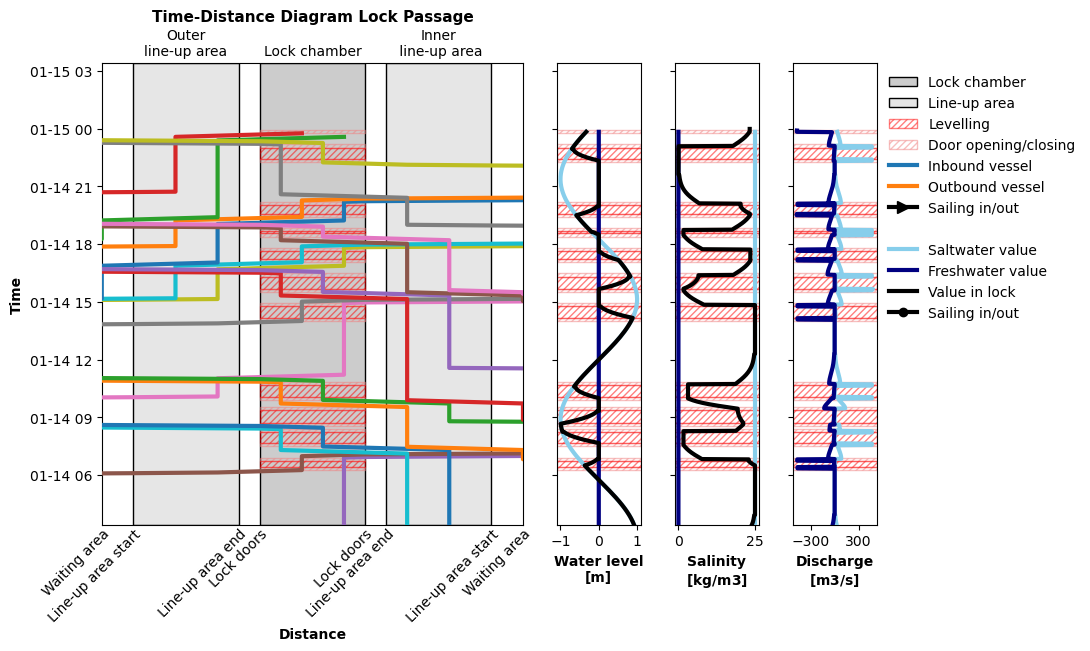

In [24]:
delays = False
entering_leaving = False

distance_to_lock_edge_start = lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_49'))['Distance'].sum()
distance_to_lock_edge_end = lock_1.env.vessel_traffic_service.provide_sailing_distance_over_route(vessels[0],nx.dijkstra_path(FG,'Node_1','Node_50'))['Distance'].sum()
lock_outer_doors = distance_to_lock_edge_start+lock_1.distance_doors1_from_first_waiting_area
lock_inner_doors = distance_to_lock_edge_end-lock_1.distance_doors1_from_first_waiting_area
lineup_1_start = lock_outer_doors - lineup_area_1.distance_to_lock_doors - lineup_area_1.lineup_length
lineup_1_end = lock_outer_doors - lineup_area_1.distance_to_lock_doors
lineup_2_start = lock_inner_doors + lineup_area_2.distance_to_lock_doors + lineup_area_2.lineup_length
lineup_2_end = lock_inner_doors + lineup_area_2.distance_to_lock_doors

fig,axes = plt.subplots(1,4,figsize=[10,6],gridspec_kw = {'width_ratios':[5,1,1,1]})
ax = axes[0]
for time,distance in zip(times,distances):
    ax.plot(distance,time,linewidth=3,zorder=3)
vessel1, = ax.plot([-1,-1],color='C0',linewidth=3)
vessel2, = ax.plot([-1,-1],color='C1',linewidth=3)
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    if len(vessel_df) < 120:
        continue
    arrival_time = datetime.datetime.fromtimestamp(_vessel_.arrival_time)
    if _vessel_.route[0] == 'Node_98':
        sail_in_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_2 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_inner_doors-40,sail_in_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
            ax.plot(lock_outer_doors-40,sail_out_time_vessel_2+pd.Timedelta(40/4,'s'),'C1',marker='<',markersize=8)
        if delays:
            ax.plot([final_geometry.length,0],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C1',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_1_start-lineup_1_end)+lineup_1_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(50+annotate_location,annotate_text_location),
                        xycoords='data',xytext=(5, 0), textcoords='offset points', rotation=90,verticalalignment='center',horizontalalignment='center',color='C1')        

    else:
        sail_in_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to first set of lock doors stop')].Time
        sail_out_time_vessel_1 = pd.DataFrame(_vessel_.log).loc[_vessel_.log['Action'].index('Sailing to second set of lock doors stop')].Time
        if entering_leaving:
            ax.plot(lock_outer_doors+40,sail_in_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
            ax.plot(lock_inner_doors+40,sail_out_time_vessel_1+pd.Timedelta(40/4,'s'),'C0',marker='>',markersize=8)
        if delays:
            ax.plot([0,final_geometry.length],[arrival_time,arrival_time+pd.Timedelta(int(final_geometry.length/4),'s')],color='C0',linestyle='--',linewidth=2)
            passage_lineup_start = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area start')].Time
            passage_lineup_stop = vessel_df.loc[_vessel_.log['Action'].index('Sailing to line-up area stop')].Time
            delayed_arrival = 0.8*(passage_lineup_stop-passage_lineup_start)+passage_lineup_start
            normal_arrival = pd.Timedelta((distance_to_lock_edge_start+2000*0.8)/4,'s')+datetime.datetime.fromtimestamp(_vessel_.arrival_time)
            annotate_location = 0.8*(lineup_2_start-lineup_2_end)+lineup_2_end
            ax.annotate('', xy=(annotate_location, delayed_arrival), xycoords='data',
                        xytext=(annotate_location, normal_arrival), textcoords='data',
                        arrowprops={'arrowstyle': '<->'})
            waiting_time = pd.Timedelta(int((delayed_arrival-normal_arrival).total_seconds()/60),'min')
            hours,remainder = divmod(waiting_time.seconds, 3600)
            minutes,_ = divmod(remainder, 60)
            annotate_text_location = 0.5*(delayed_arrival-normal_arrival)+normal_arrival
            ax.annotate(r'$\mathbf{Delay\ time}$'+':\n'+'{:02} hrs {:02} mins'.format(int(hours), int(minutes)), xy=(annotate_location-120,annotate_text_location),
                        xycoords='data',xytext=(5, 0), textcoords='offset points', rotation=270,verticalalignment='center',horizontalalignment='center',color='C0')        
        
lock_df = pd.DataFrame(lock_1.log)
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        levelling, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        door_opening_closing, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    
ylim_min = lock_df.loc[0].Time-pd.Timedelta(1,'h')
ylim_max = lock_df.iloc[-7].Time+pd.Timedelta(5,'h')
ylim_min = ylim_max - pd.Timedelta(24,'h')
#ylim_max = ylim_min + pd.Timedelta(5,'h')
#ylim_min += pd.Timedelta(12,'h')
#ylim_max = ylim_min + pd.Timedelta(12,'h')

ax.set_ylim(ylim_min,ylim_max)
ylim = ax.get_ylim()
lineup_area_fill, = ax.fill([lineup_1_start,lineup_1_start,lineup_1_end,lineup_1_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
ax.fill([lineup_2_start,lineup_2_start,lineup_2_end,lineup_2_end],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.9,0.9,0.9],edgecolor='k')
lock_chamber_fill, = ax.fill([lock_outer_doors,lock_outer_doors,lock_inner_doors,lock_inner_doors],
        [ylim[0],ylim[1],ylim[1],ylim[0]],
        zorder=0,color=[0.8,0.8,0.8],edgecolor='k')
ax.set_xlim([distance_to_lock_edge_start,distance_to_lock_edge_end])
ax.set_ylim(ylim)
ax.set_xticks([])

ax.text(50/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(200/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(700/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(800/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1300/2000, -0.025, 'Lock doors',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1400/2000, -0.025, 'Line-up area end',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(1900/2000, -0.025, 'Line-up area start',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(2050/2000, -0.025, 'Waiting area',verticalalignment='bottom',horizontalalignment='right',
        rotation_mode='anchor',rotation=45,
        transform=ax.transAxes)
ax.text(400/2000,1.075,'Outer\nline-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1000/2000,1.075,'\nLock chamber',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.text(1600/2000,1.075,'Inner\n line-up area',verticalalignment='top',horizontalalignment='center',transform=ax.transAxes)
ax.set_xlabel('Distance',labelpad=70,fontweight='bold')
ax.set_ylabel('Time',fontweight='bold')
ax.set_title('Time-Distance Diagram Lock Passage',fontsize=11,fontweight='bold',pad=30)

ax = axes[1]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=48)['Water level'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Water level'].values,
        hydrodynamic_data.sel(STATIONS=49)['Water level'].TIME.values,
        color='navy',zorder=3,linewidth=3)
lock_level, = ax.plot(lock_1.water_level.values,lock_1.water_level.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nWater level',fontsize=11,fontweight='bold')
ax.set_xticks([-1,0,1])
ax.set_xlabel('Water level\n[m]',fontweight='bold')

ax = axes[2]
ax.set_facecolor('white')
ax.plot(hydrodynamic_data.sel(STATIONS=48)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=48)['Salinity'].TIME.values,
        color='skyblue',zorder=3,linewidth=3)
ax.plot(hydrodynamic_data.sel(STATIONS=49)['Salinity'].values,
        hydrodynamic_data.sel(STATIONS=49)['Salinity'].TIME.values,
        color='navy',zorder=3,linewidth=3)
ax.plot(lock_1.salinity.values,lock_1.salinity.TIME.values,zorder=4,linewidth=3,color='k')
ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nSalinity',fontsize=11,fontweight='bold')
ax.set_xticks([0,25])
ax.set_xlabel('Salinity\n'+r'[kg/m$\mathregular{3}$]',fontweight='bold')

ax = axes[3]
ax.set_facecolor('white')
freshwater, = ax.plot(lock_1.discharge_fresh.values,lock_1.discharge_fresh.TIME.values,color='navy',linewidth=3,zorder=4)
if entering_leaving:
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_in_time_vessel_1).values,sail_in_time_vessel_1,marker='o',color='navy',markersize=6)
    ax.plot(lock_1.discharge_fresh.interp(TIME=sail_out_time_vessel_1).values,sail_out_time_vessel_1,marker='o',color='navy',markersize=6)
saltwater, = ax.plot(lock_1.discharge_saline.values,lock_1.discharge_saline.TIME.values,color='skyblue',linewidth=3,zorder=3)
if entering_leaving:
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_in_time_vessel_2).values,sail_in_time_vessel_2,marker='o',color='skyblue',markersize=6)
    ax.plot(lock_1.discharge_saline.interp(TIME=sail_out_time_vessel_2).values,sail_out_time_vessel_2,marker='o',color='skyblue',markersize=6)
sail_in_out_arrow, = ax.plot([0,0],color='k',marker='>',markersize=8,linewidth=3)
sail_in_out_point, = ax.plot([0,0],color='k',marker='o',markersize=6,linewidth=3)

ax.set_ylim(ylim)
ax.set_yticklabels([])
xlim_min,xlim_max = ax.get_xlim()
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=2,color='none',edgecolor='red',alpha=0.5)
    if info.Action == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
    if info.Action == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Time
        door_closing_time = lock_df.loc[loc-1].Time
        ax.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',zorder=1,color='none',edgecolor='lightcoral',alpha=0.5)
ax.set_xlim(xlim_min,xlim_max)
#ax.set_title('Lock\nChamber\nDischarge',fontsize=11,fontweight='bold')
ax.legend([lock_chamber_fill,lineup_area_fill,levelling,door_opening_closing,vessel1,vessel2,sail_in_out_arrow,mpl.patches.Patch(color='none'),
           saltwater,freshwater,lock_level,sail_in_out_point],
          ['Lock chamber','Line-up area','Levelling','Door opening/closing','Inbound vessel','Outbound vessel','Sailing in/out','',
           'Saltwater value','Freshwater value','Value in lock','Sailing in/out'],
          bbox_to_anchor=[1,1],frameon=False,prop={'size':10})
ax.set_xticks([-300,300])
ax.set_xlabel('Discharge\n'+r'[m$\mathregular{3}$/s]',fontweight='bold');
#fig.savefig('Basic_lock_passage.svg',dpi=500,format='svg',bbox_inches='tight');

In [25]:
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock chamber converting start':
        if lock_df.loc[loc-1,'Action'] != 'Lock doors closing stop':
            print(loc)
        if lock_df.loc[loc+1,'Action'] != 'Lock chamber converting stop':
            print(loc)

KeyError: 1041

In [ ]:
lock_df = pd.DataFrame(lock_1.log)
lock_df.tail(n=200)[0:50]

In [ ]:
salt_transport_df = pd.DataFrame(columns=['Side','Levelling start','Levelling stop','Door Open','Door Closed',
                                          'Water level start levelling','Water level stop levelling',
                                          'Ship Volume Left','Ship Volume Entered'])
for loc,info in lock_df.iterrows():
    if info.Action == 'Lock doors closing stop' and loc > 2:
        levelling_start = lock_df.loc[loc-5].Time
        levelling_stop = lock_df.loc[loc-4].Time
        index_levelling_start = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_start)).argmin()
        index_levelling_stop = np.absolute(lock_1.water_level.TIME.values-np.datetime64(levelling_stop)).argmin()
        water_level_start_levelling = lock_1.water_level[index_levelling_start].values
        water_level_stop_levelling = lock_1.water_level[index_levelling_stop].values
        door_open = (lock_df.loc[loc-2].Time-lock_df.loc[loc-3].Time)/2+lock_df.loc[loc-3].Time
        door_closed = (info.Time-lock_df.loc[loc-1].Time)/2+lock_df.loc[loc-1].Time
        volume_loss = 0
        volume_transported = 0
        for _vessel_ in vessels:
            vessel_df = pd.DataFrame(_vessel_.log)
            if vessel_df.empty:
                continue
            vessel_df_door_open_time = vessel_df[(vessel_df.Time > door_open - datetime.timedelta(seconds=lock_1.doors_open)) & 
                                                 (vessel_df.Time < door_closed + datetime.timedelta(seconds=lock_1.doors_close))]
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[0].Action == 'Passing lock stop':
                volume_loss += _vessel_.L*_vessel_.B*_vessel_.T
            if not vessel_df_door_open_time.empty and vessel_df_door_open_time.iloc[-1].Action == 'Passing lock start':
                volume_transported += _vessel_.L*_vessel_.B*_vessel_.T
        salt_transport_df.loc[len(salt_transport_df),:] = [info.Location,levelling_start,levelling_stop,door_open,door_closed,
                                                           water_level_start_levelling,water_level_stop_levelling,
                                                           volume_loss,volume_transported]

In [ ]:
salt_transport_df['Salt Exchange [kg]'] = 0.0
salt_transport_df['Salt Transported [kg]'] = 0.0
salt_transport_df['Freshwater Exchange [m3]'] = 0.0
salt_transport_df['Freshwater Transported [m3]'] = 0.0
salt_transport_df['Freshwater Levelled [m3]'] = 0.0

for loc,info in salt_transport_df.iterrows():
    if info.Side == 'Node_50':
        salinity_difference = lock_1.salinity.interp(TIME=info['Door Open']).values-np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])
        salt_transport_df.loc[loc,'Salt Exchange [kg]'] = salinity_difference*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth
        salt_transport_df.loc[loc,'Salt Transported [kg]'] = np.nanmax([0,lock_1.salinity.interp(TIME=info['Door Closed']).values])*info['Ship Volume Entered']
        salt_transport_df.loc[loc,'Freshwater Exchange [m3]'] = lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth*np.tanh((info['Door Closed']-info['Door Open']).total_seconds()/(2*lock_1.lock_length/(0.5*np.sqrt(9.81*0.8*salinity_difference*lock_1.lock_depth/(1000+0.8*25/2)))))
        salt_transport_df.loc[loc,'Freshwater Transported [m3]'] = info['Ship Volume Left']
        water_levelling_difference = info['Water level stop levelling']-info['Water level start levelling']
        if water_levelling_difference > 0:
            salt_transport_df['Freshwater Levelled [m3]'] = water_levelling_difference

In [ ]:
(salt_transport_df['Salt Transported [kg]'].sum()+salt_transport_df['Salt Exchange [kg]'].sum())/(25*lock_1.lock_length*lock_1.lock_width*lock_1.lock_depth)

In [ ]:
delay_df = pd.DataFrame(columns=['Delay'])
for _vessel_ in vessels:
    vessel_df = pd.DataFrame(_vessel_.log)
    start_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 start']
    stop_df = vessel_df[vessel_df.Action == 'Sailing from node Node_49 to node Node_50 stop']
    if stop_df.empty or start_df.empty:
        continue
    start_time = start_df.Time.iloc[0]
    stop_time = stop_df.Time.iloc[0]
    delay = stop_time-start_time-pd.Timedelta(FG.edges['Node_49','Node_50',0]['Info']['length']/vessels[0].v,'s')
    delay_df.loc[_vessel_.name,'Delay'] = delay

In [ ]:
average_vessel_delay = delay_df.Delay.sum()/len(delay_df)

In [ ]:
average_vessel_delay